In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [20]:
data_dir = Path('input')
feature_dir = Path('input')
val_dir = Path('input')
tst_dir = Path('input')
sub_dir = Path('input')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [21]:
algo_name = 'lgbcv'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [22]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 20)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
id,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,1.1898,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-2.6257,-3.3488,2.0462,0.7232,-15.0556
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1.2533,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.7683,-0.8698,0.2767,0.1016,-0.3069
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,1.0225,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.3649,-0.3905,0.1440,0.0257,-0.9014
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.6094,1.2054,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-1.2000,-1.4395,0.5321,0.2395,-1.3906
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,2.6391,1.1939,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-2.2436,-2.5579,0.9871,0.3144,-9.3609


In [23]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 19) (80000, 19)


In [24]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [36]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             n_estimators=10000,
                             num_leaves=512,
                             learning_rate=0.001,
                             min_child_samples=10,
                             subsample=.7,
                             subsample_freq=1,
                             colsample_bytree=.7,
                             random_state=seed,
                             n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.984934
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.983888
[3]	valid_0's multi_logloss: 0.982765
[4]	valid_0's multi_logloss: 0.981658
[5]	valid_0's multi_logloss: 0.980535
[6]	valid_0's multi_logloss: 0.979505
[7]	valid_0's multi_logloss: 0.978429
[8]	valid_0's multi_logloss: 0.977406
[9]	valid_0's multi_logloss: 0.976415
[10]	valid_0's multi_logloss: 0.975307
[11]	valid_0's multi_logloss: 0.974211
[12]	valid_0's multi_logloss: 0.973119
[13]	valid_0's multi_logloss: 0.972021
[14]	valid_0's multi_logloss: 0.970914
[15]	valid_0's multi_logloss: 0.969837
[16]	valid_0's multi_logloss: 0.968805
[17]	valid_0's multi_logloss: 0.967746
[18]	valid_0's multi_logloss: 0.966665
[19]	valid_0's multi_logloss: 0.965624
[20]	valid_0's multi_logloss: 0.964616
[21]	valid_0's multi_logloss: 0.963547
[22]	valid_0's multi_logloss: 0.962468
[23]	valid_0's multi_logloss: 0.961403
[24]	valid_0's multi_loglo

[207]	valid_0's multi_logloss: 0.801026
[208]	valid_0's multi_logloss: 0.80032
[209]	valid_0's multi_logloss: 0.799577
[210]	valid_0's multi_logloss: 0.79882
[211]	valid_0's multi_logloss: 0.798158
[212]	valid_0's multi_logloss: 0.797401
[213]	valid_0's multi_logloss: 0.796724
[214]	valid_0's multi_logloss: 0.795999
[215]	valid_0's multi_logloss: 0.795291
[216]	valid_0's multi_logloss: 0.794508
[217]	valid_0's multi_logloss: 0.793799
[218]	valid_0's multi_logloss: 0.793093
[219]	valid_0's multi_logloss: 0.79236
[220]	valid_0's multi_logloss: 0.79166
[221]	valid_0's multi_logloss: 0.790881
[222]	valid_0's multi_logloss: 0.790213
[223]	valid_0's multi_logloss: 0.789509
[224]	valid_0's multi_logloss: 0.788793
[225]	valid_0's multi_logloss: 0.788039
[226]	valid_0's multi_logloss: 0.787348
[227]	valid_0's multi_logloss: 0.786662
[228]	valid_0's multi_logloss: 0.785935
[229]	valid_0's multi_logloss: 0.785208
[230]	valid_0's multi_logloss: 0.784449
[231]	valid_0's multi_logloss: 0.783691
[232

[413]	valid_0's multi_logloss: 0.669287
[414]	valid_0's multi_logloss: 0.668712
[415]	valid_0's multi_logloss: 0.668137
[416]	valid_0's multi_logloss: 0.667628
[417]	valid_0's multi_logloss: 0.667102
[418]	valid_0's multi_logloss: 0.666539
[419]	valid_0's multi_logloss: 0.665998
[420]	valid_0's multi_logloss: 0.665458
[421]	valid_0's multi_logloss: 0.664883
[422]	valid_0's multi_logloss: 0.664375
[423]	valid_0's multi_logloss: 0.663804
[424]	valid_0's multi_logloss: 0.663227
[425]	valid_0's multi_logloss: 0.662711
[426]	valid_0's multi_logloss: 0.662197
[427]	valid_0's multi_logloss: 0.661635
[428]	valid_0's multi_logloss: 0.661065
[429]	valid_0's multi_logloss: 0.660616
[430]	valid_0's multi_logloss: 0.660082
[431]	valid_0's multi_logloss: 0.659526
[432]	valid_0's multi_logloss: 0.658952
[433]	valid_0's multi_logloss: 0.658401
[434]	valid_0's multi_logloss: 0.657874
[435]	valid_0's multi_logloss: 0.657349
[436]	valid_0's multi_logloss: 0.656839
[437]	valid_0's multi_logloss: 0.656341


[619]	valid_0's multi_logloss: 0.570413
[620]	valid_0's multi_logloss: 0.56998
[621]	valid_0's multi_logloss: 0.569543
[622]	valid_0's multi_logloss: 0.569127
[623]	valid_0's multi_logloss: 0.568715
[624]	valid_0's multi_logloss: 0.568296
[625]	valid_0's multi_logloss: 0.567851
[626]	valid_0's multi_logloss: 0.567425
[627]	valid_0's multi_logloss: 0.567025
[628]	valid_0's multi_logloss: 0.566586
[629]	valid_0's multi_logloss: 0.566151
[630]	valid_0's multi_logloss: 0.565732
[631]	valid_0's multi_logloss: 0.565309
[632]	valid_0's multi_logloss: 0.564906
[633]	valid_0's multi_logloss: 0.564495
[634]	valid_0's multi_logloss: 0.564137
[635]	valid_0's multi_logloss: 0.563699
[636]	valid_0's multi_logloss: 0.563312
[637]	valid_0's multi_logloss: 0.562869
[638]	valid_0's multi_logloss: 0.562478
[639]	valid_0's multi_logloss: 0.562073
[640]	valid_0's multi_logloss: 0.561654
[641]	valid_0's multi_logloss: 0.561262
[642]	valid_0's multi_logloss: 0.560857
[643]	valid_0's multi_logloss: 0.560437
[

[825]	valid_0's multi_logloss: 0.493816
[826]	valid_0's multi_logloss: 0.493488
[827]	valid_0's multi_logloss: 0.493153
[828]	valid_0's multi_logloss: 0.492804
[829]	valid_0's multi_logloss: 0.492486
[830]	valid_0's multi_logloss: 0.492136
[831]	valid_0's multi_logloss: 0.491826
[832]	valid_0's multi_logloss: 0.49152
[833]	valid_0's multi_logloss: 0.49122
[834]	valid_0's multi_logloss: 0.490928
[835]	valid_0's multi_logloss: 0.490635
[836]	valid_0's multi_logloss: 0.4903
[837]	valid_0's multi_logloss: 0.489958
[838]	valid_0's multi_logloss: 0.489658
[839]	valid_0's multi_logloss: 0.489371
[840]	valid_0's multi_logloss: 0.489069
[841]	valid_0's multi_logloss: 0.488727
[842]	valid_0's multi_logloss: 0.488438
[843]	valid_0's multi_logloss: 0.488146
[844]	valid_0's multi_logloss: 0.487824
[845]	valid_0's multi_logloss: 0.487496
[846]	valid_0's multi_logloss: 0.487176
[847]	valid_0's multi_logloss: 0.486863
[848]	valid_0's multi_logloss: 0.48652
[849]	valid_0's multi_logloss: 0.486215
[850]

[1030]	valid_0's multi_logloss: 0.434093
[1031]	valid_0's multi_logloss: 0.43382
[1032]	valid_0's multi_logloss: 0.43357
[1033]	valid_0's multi_logloss: 0.433305
[1034]	valid_0's multi_logloss: 0.433038
[1035]	valid_0's multi_logloss: 0.432802
[1036]	valid_0's multi_logloss: 0.432528
[1037]	valid_0's multi_logloss: 0.43225
[1038]	valid_0's multi_logloss: 0.432003
[1039]	valid_0's multi_logloss: 0.43173
[1040]	valid_0's multi_logloss: 0.431495
[1041]	valid_0's multi_logloss: 0.431236
[1042]	valid_0's multi_logloss: 0.431002
[1043]	valid_0's multi_logloss: 0.430737
[1044]	valid_0's multi_logloss: 0.430476
[1045]	valid_0's multi_logloss: 0.430225
[1046]	valid_0's multi_logloss: 0.430013
[1047]	valid_0's multi_logloss: 0.429778
[1048]	valid_0's multi_logloss: 0.429521
[1049]	valid_0's multi_logloss: 0.429248
[1050]	valid_0's multi_logloss: 0.42901
[1051]	valid_0's multi_logloss: 0.428768
[1052]	valid_0's multi_logloss: 0.428502
[1053]	valid_0's multi_logloss: 0.428238
[1054]	valid_0's mult

[1231]	valid_0's multi_logloss: 0.387153
[1232]	valid_0's multi_logloss: 0.386942
[1233]	valid_0's multi_logloss: 0.386723
[1234]	valid_0's multi_logloss: 0.386517
[1235]	valid_0's multi_logloss: 0.386306
[1236]	valid_0's multi_logloss: 0.386096
[1237]	valid_0's multi_logloss: 0.385879
[1238]	valid_0's multi_logloss: 0.385665
[1239]	valid_0's multi_logloss: 0.385474
[1240]	valid_0's multi_logloss: 0.385272
[1241]	valid_0's multi_logloss: 0.38506
[1242]	valid_0's multi_logloss: 0.384873
[1243]	valid_0's multi_logloss: 0.384657
[1244]	valid_0's multi_logloss: 0.384437
[1245]	valid_0's multi_logloss: 0.384235
[1246]	valid_0's multi_logloss: 0.384054
[1247]	valid_0's multi_logloss: 0.383855
[1248]	valid_0's multi_logloss: 0.38366
[1249]	valid_0's multi_logloss: 0.383467
[1250]	valid_0's multi_logloss: 0.383277
[1251]	valid_0's multi_logloss: 0.383054
[1252]	valid_0's multi_logloss: 0.382838
[1253]	valid_0's multi_logloss: 0.382645
[1254]	valid_0's multi_logloss: 0.38243
[1255]	valid_0's mu

[1433]	valid_0's multi_logloss: 0.349186
[1434]	valid_0's multi_logloss: 0.349015
[1435]	valid_0's multi_logloss: 0.348848
[1436]	valid_0's multi_logloss: 0.348673
[1437]	valid_0's multi_logloss: 0.348492
[1438]	valid_0's multi_logloss: 0.348333
[1439]	valid_0's multi_logloss: 0.348168
[1440]	valid_0's multi_logloss: 0.348001
[1441]	valid_0's multi_logloss: 0.347832
[1442]	valid_0's multi_logloss: 0.34765
[1443]	valid_0's multi_logloss: 0.347505
[1444]	valid_0's multi_logloss: 0.34735
[1445]	valid_0's multi_logloss: 0.347187
[1446]	valid_0's multi_logloss: 0.347024
[1447]	valid_0's multi_logloss: 0.346859
[1448]	valid_0's multi_logloss: 0.346682
[1449]	valid_0's multi_logloss: 0.346506
[1450]	valid_0's multi_logloss: 0.34634
[1451]	valid_0's multi_logloss: 0.346201
[1452]	valid_0's multi_logloss: 0.346041
[1453]	valid_0's multi_logloss: 0.345882
[1454]	valid_0's multi_logloss: 0.345709
[1455]	valid_0's multi_logloss: 0.34553
[1456]	valid_0's multi_logloss: 0.345353
[1457]	valid_0's mul

[1635]	valid_0's multi_logloss: 0.317999
[1636]	valid_0's multi_logloss: 0.317858
[1637]	valid_0's multi_logloss: 0.31771
[1638]	valid_0's multi_logloss: 0.317573
[1639]	valid_0's multi_logloss: 0.317428
[1640]	valid_0's multi_logloss: 0.317288
[1641]	valid_0's multi_logloss: 0.31714
[1642]	valid_0's multi_logloss: 0.317021
[1643]	valid_0's multi_logloss: 0.316873
[1644]	valid_0's multi_logloss: 0.316737
[1645]	valid_0's multi_logloss: 0.316619
[1646]	valid_0's multi_logloss: 0.316475
[1647]	valid_0's multi_logloss: 0.31634
[1648]	valid_0's multi_logloss: 0.316206
[1649]	valid_0's multi_logloss: 0.31609
[1650]	valid_0's multi_logloss: 0.315971
[1651]	valid_0's multi_logloss: 0.315833
[1652]	valid_0's multi_logloss: 0.315711
[1653]	valid_0's multi_logloss: 0.315577
[1654]	valid_0's multi_logloss: 0.315433
[1655]	valid_0's multi_logloss: 0.315285
[1656]	valid_0's multi_logloss: 0.315151
[1657]	valid_0's multi_logloss: 0.315011
[1658]	valid_0's multi_logloss: 0.314885
[1659]	valid_0's mul

[1837]	valid_0's multi_logloss: 0.292788
[1838]	valid_0's multi_logloss: 0.292671
[1839]	valid_0's multi_logloss: 0.29255
[1840]	valid_0's multi_logloss: 0.292445
[1841]	valid_0's multi_logloss: 0.292334
[1842]	valid_0's multi_logloss: 0.292219
[1843]	valid_0's multi_logloss: 0.292096
[1844]	valid_0's multi_logloss: 0.29198
[1845]	valid_0's multi_logloss: 0.291865
[1846]	valid_0's multi_logloss: 0.291746
[1847]	valid_0's multi_logloss: 0.291631
[1848]	valid_0's multi_logloss: 0.291518
[1849]	valid_0's multi_logloss: 0.291415
[1850]	valid_0's multi_logloss: 0.291295
[1851]	valid_0's multi_logloss: 0.291183
[1852]	valid_0's multi_logloss: 0.291074
[1853]	valid_0's multi_logloss: 0.290968
[1854]	valid_0's multi_logloss: 0.290844
[1855]	valid_0's multi_logloss: 0.290742
[1856]	valid_0's multi_logloss: 0.290634
[1857]	valid_0's multi_logloss: 0.290518
[1858]	valid_0's multi_logloss: 0.290406
[1859]	valid_0's multi_logloss: 0.290302
[1860]	valid_0's multi_logloss: 0.290204
[1861]	valid_0's m

[2038]	valid_0's multi_logloss: 0.27186
[2039]	valid_0's multi_logloss: 0.271765
[2040]	valid_0's multi_logloss: 0.271678
[2041]	valid_0's multi_logloss: 0.271588
[2042]	valid_0's multi_logloss: 0.271491
[2043]	valid_0's multi_logloss: 0.271398
[2044]	valid_0's multi_logloss: 0.271307
[2045]	valid_0's multi_logloss: 0.271222
[2046]	valid_0's multi_logloss: 0.271127
[2047]	valid_0's multi_logloss: 0.271035
[2048]	valid_0's multi_logloss: 0.27095
[2049]	valid_0's multi_logloss: 0.270852
[2050]	valid_0's multi_logloss: 0.270769
[2051]	valid_0's multi_logloss: 0.270665
[2052]	valid_0's multi_logloss: 0.270565
[2053]	valid_0's multi_logloss: 0.270475
[2054]	valid_0's multi_logloss: 0.270373
[2055]	valid_0's multi_logloss: 0.270283
[2056]	valid_0's multi_logloss: 0.270182
[2057]	valid_0's multi_logloss: 0.27009
[2058]	valid_0's multi_logloss: 0.269998
[2059]	valid_0's multi_logloss: 0.269905
[2060]	valid_0's multi_logloss: 0.269823
[2061]	valid_0's multi_logloss: 0.26973
[2062]	valid_0's mul

[2238]	valid_0's multi_logloss: 0.254976
[2239]	valid_0's multi_logloss: 0.25489
[2240]	valid_0's multi_logloss: 0.254825
[2241]	valid_0's multi_logloss: 0.254742
[2242]	valid_0's multi_logloss: 0.254661
[2243]	valid_0's multi_logloss: 0.25458
[2244]	valid_0's multi_logloss: 0.254502
[2245]	valid_0's multi_logloss: 0.254431
[2246]	valid_0's multi_logloss: 0.254353
[2247]	valid_0's multi_logloss: 0.254273
[2248]	valid_0's multi_logloss: 0.254202
[2249]	valid_0's multi_logloss: 0.254125
[2250]	valid_0's multi_logloss: 0.254056
[2251]	valid_0's multi_logloss: 0.253995
[2252]	valid_0's multi_logloss: 0.253913
[2253]	valid_0's multi_logloss: 0.253842
[2254]	valid_0's multi_logloss: 0.253768
[2255]	valid_0's multi_logloss: 0.253699
[2256]	valid_0's multi_logloss: 0.253629
[2257]	valid_0's multi_logloss: 0.253567
[2258]	valid_0's multi_logloss: 0.253485
[2259]	valid_0's multi_logloss: 0.253414
[2260]	valid_0's multi_logloss: 0.253336
[2261]	valid_0's multi_logloss: 0.253254
[2262]	valid_0's m

[2440]	valid_0's multi_logloss: 0.240562
[2441]	valid_0's multi_logloss: 0.240493
[2442]	valid_0's multi_logloss: 0.240432
[2443]	valid_0's multi_logloss: 0.240369
[2444]	valid_0's multi_logloss: 0.240309
[2445]	valid_0's multi_logloss: 0.240239
[2446]	valid_0's multi_logloss: 0.240167
[2447]	valid_0's multi_logloss: 0.240097
[2448]	valid_0's multi_logloss: 0.240027
[2449]	valid_0's multi_logloss: 0.239965
[2450]	valid_0's multi_logloss: 0.2399
[2451]	valid_0's multi_logloss: 0.239833
[2452]	valid_0's multi_logloss: 0.239765
[2453]	valid_0's multi_logloss: 0.239697
[2454]	valid_0's multi_logloss: 0.239629
[2455]	valid_0's multi_logloss: 0.239575
[2456]	valid_0's multi_logloss: 0.239514
[2457]	valid_0's multi_logloss: 0.239442
[2458]	valid_0's multi_logloss: 0.239379
[2459]	valid_0's multi_logloss: 0.239321
[2460]	valid_0's multi_logloss: 0.239253
[2461]	valid_0's multi_logloss: 0.239187
[2462]	valid_0's multi_logloss: 0.239118
[2463]	valid_0's multi_logloss: 0.239052
[2464]	valid_0's m

[2642]	valid_0's multi_logloss: 0.228491
[2643]	valid_0's multi_logloss: 0.228433
[2644]	valid_0's multi_logloss: 0.228374
[2645]	valid_0's multi_logloss: 0.228316
[2646]	valid_0's multi_logloss: 0.228263
[2647]	valid_0's multi_logloss: 0.228207
[2648]	valid_0's multi_logloss: 0.228154
[2649]	valid_0's multi_logloss: 0.228097
[2650]	valid_0's multi_logloss: 0.228039
[2651]	valid_0's multi_logloss: 0.22798
[2652]	valid_0's multi_logloss: 0.227923
[2653]	valid_0's multi_logloss: 0.227867
[2654]	valid_0's multi_logloss: 0.227806
[2655]	valid_0's multi_logloss: 0.227758
[2656]	valid_0's multi_logloss: 0.227705
[2657]	valid_0's multi_logloss: 0.227648
[2658]	valid_0's multi_logloss: 0.227589
[2659]	valid_0's multi_logloss: 0.227528
[2660]	valid_0's multi_logloss: 0.227472
[2661]	valid_0's multi_logloss: 0.227421
[2662]	valid_0's multi_logloss: 0.22736
[2663]	valid_0's multi_logloss: 0.227307
[2664]	valid_0's multi_logloss: 0.22726
[2665]	valid_0's multi_logloss: 0.227215
[2666]	valid_0's mu

[2843]	valid_0's multi_logloss: 0.21843
[2844]	valid_0's multi_logloss: 0.218397
[2845]	valid_0's multi_logloss: 0.218359
[2846]	valid_0's multi_logloss: 0.218313
[2847]	valid_0's multi_logloss: 0.218263
[2848]	valid_0's multi_logloss: 0.218219
[2849]	valid_0's multi_logloss: 0.218176
[2850]	valid_0's multi_logloss: 0.218135
[2851]	valid_0's multi_logloss: 0.218089
[2852]	valid_0's multi_logloss: 0.218037
[2853]	valid_0's multi_logloss: 0.217993
[2854]	valid_0's multi_logloss: 0.217947
[2855]	valid_0's multi_logloss: 0.217895
[2856]	valid_0's multi_logloss: 0.217855
[2857]	valid_0's multi_logloss: 0.217803
[2858]	valid_0's multi_logloss: 0.217759
[2859]	valid_0's multi_logloss: 0.217719
[2860]	valid_0's multi_logloss: 0.217675
[2861]	valid_0's multi_logloss: 0.217633
[2862]	valid_0's multi_logloss: 0.217585
[2863]	valid_0's multi_logloss: 0.217539
[2864]	valid_0's multi_logloss: 0.217501
[2865]	valid_0's multi_logloss: 0.217463
[2866]	valid_0's multi_logloss: 0.217416
[2867]	valid_0's 

[3044]	valid_0's multi_logloss: 0.209963
[3045]	valid_0's multi_logloss: 0.20993
[3046]	valid_0's multi_logloss: 0.209888
[3047]	valid_0's multi_logloss: 0.209853
[3048]	valid_0's multi_logloss: 0.209813
[3049]	valid_0's multi_logloss: 0.209774
[3050]	valid_0's multi_logloss: 0.209737
[3051]	valid_0's multi_logloss: 0.209702
[3052]	valid_0's multi_logloss: 0.209659
[3053]	valid_0's multi_logloss: 0.209627
[3054]	valid_0's multi_logloss: 0.209589
[3055]	valid_0's multi_logloss: 0.209555
[3056]	valid_0's multi_logloss: 0.209513
[3057]	valid_0's multi_logloss: 0.209473
[3058]	valid_0's multi_logloss: 0.20943
[3059]	valid_0's multi_logloss: 0.209396
[3060]	valid_0's multi_logloss: 0.209355
[3061]	valid_0's multi_logloss: 0.209321
[3062]	valid_0's multi_logloss: 0.209286
[3063]	valid_0's multi_logloss: 0.209246
[3064]	valid_0's multi_logloss: 0.209203
[3065]	valid_0's multi_logloss: 0.209166
[3066]	valid_0's multi_logloss: 0.209123
[3067]	valid_0's multi_logloss: 0.209086
[3068]	valid_0's m

[3246]	valid_0's multi_logloss: 0.20286
[3247]	valid_0's multi_logloss: 0.202828
[3248]	valid_0's multi_logloss: 0.202796
[3249]	valid_0's multi_logloss: 0.202759
[3250]	valid_0's multi_logloss: 0.202727
[3251]	valid_0's multi_logloss: 0.202702
[3252]	valid_0's multi_logloss: 0.202664
[3253]	valid_0's multi_logloss: 0.202635
[3254]	valid_0's multi_logloss: 0.202602
[3255]	valid_0's multi_logloss: 0.20257
[3256]	valid_0's multi_logloss: 0.202535
[3257]	valid_0's multi_logloss: 0.202507
[3258]	valid_0's multi_logloss: 0.202469
[3259]	valid_0's multi_logloss: 0.202436
[3260]	valid_0's multi_logloss: 0.202407
[3261]	valid_0's multi_logloss: 0.202378
[3262]	valid_0's multi_logloss: 0.202344
[3263]	valid_0's multi_logloss: 0.202312
[3264]	valid_0's multi_logloss: 0.202279
[3265]	valid_0's multi_logloss: 0.202244
[3266]	valid_0's multi_logloss: 0.202209
[3267]	valid_0's multi_logloss: 0.202181
[3268]	valid_0's multi_logloss: 0.202145
[3269]	valid_0's multi_logloss: 0.202118
[3270]	valid_0's m

[3447]	valid_0's multi_logloss: 0.196771
[3448]	valid_0's multi_logloss: 0.196741
[3449]	valid_0's multi_logloss: 0.196716
[3450]	valid_0's multi_logloss: 0.196691
[3451]	valid_0's multi_logloss: 0.196659
[3452]	valid_0's multi_logloss: 0.19663
[3453]	valid_0's multi_logloss: 0.196603
[3454]	valid_0's multi_logloss: 0.196573
[3455]	valid_0's multi_logloss: 0.19654
[3456]	valid_0's multi_logloss: 0.196515
[3457]	valid_0's multi_logloss: 0.196482
[3458]	valid_0's multi_logloss: 0.196451
[3459]	valid_0's multi_logloss: 0.196431
[3460]	valid_0's multi_logloss: 0.196402
[3461]	valid_0's multi_logloss: 0.19637
[3462]	valid_0's multi_logloss: 0.196351
[3463]	valid_0's multi_logloss: 0.196325
[3464]	valid_0's multi_logloss: 0.1963
[3465]	valid_0's multi_logloss: 0.196272
[3466]	valid_0's multi_logloss: 0.19624
[3467]	valid_0's multi_logloss: 0.196217
[3468]	valid_0's multi_logloss: 0.196188
[3469]	valid_0's multi_logloss: 0.196155
[3470]	valid_0's multi_logloss: 0.196129
[3471]	valid_0's multi

[3649]	valid_0's multi_logloss: 0.191559
[3650]	valid_0's multi_logloss: 0.191531
[3651]	valid_0's multi_logloss: 0.191507
[3652]	valid_0's multi_logloss: 0.191479
[3653]	valid_0's multi_logloss: 0.191455
[3654]	valid_0's multi_logloss: 0.191434
[3655]	valid_0's multi_logloss: 0.191409
[3656]	valid_0's multi_logloss: 0.191387
[3657]	valid_0's multi_logloss: 0.191367
[3658]	valid_0's multi_logloss: 0.191341
[3659]	valid_0's multi_logloss: 0.19132
[3660]	valid_0's multi_logloss: 0.191295
[3661]	valid_0's multi_logloss: 0.191268
[3662]	valid_0's multi_logloss: 0.191243
[3663]	valid_0's multi_logloss: 0.191215
[3664]	valid_0's multi_logloss: 0.191191
[3665]	valid_0's multi_logloss: 0.191165
[3666]	valid_0's multi_logloss: 0.191145
[3667]	valid_0's multi_logloss: 0.191118
[3668]	valid_0's multi_logloss: 0.191093
[3669]	valid_0's multi_logloss: 0.191073
[3670]	valid_0's multi_logloss: 0.191047
[3671]	valid_0's multi_logloss: 0.191025
[3672]	valid_0's multi_logloss: 0.191003
[3673]	valid_0's 

[3851]	valid_0's multi_logloss: 0.187113
[3852]	valid_0's multi_logloss: 0.187094
[3853]	valid_0's multi_logloss: 0.187073
[3854]	valid_0's multi_logloss: 0.187054
[3855]	valid_0's multi_logloss: 0.187038
[3856]	valid_0's multi_logloss: 0.187014
[3857]	valid_0's multi_logloss: 0.186996
[3858]	valid_0's multi_logloss: 0.186976
[3859]	valid_0's multi_logloss: 0.186952
[3860]	valid_0's multi_logloss: 0.186937
[3861]	valid_0's multi_logloss: 0.186919
[3862]	valid_0's multi_logloss: 0.186901
[3863]	valid_0's multi_logloss: 0.18688
[3864]	valid_0's multi_logloss: 0.18686
[3865]	valid_0's multi_logloss: 0.186844
[3866]	valid_0's multi_logloss: 0.186823
[3867]	valid_0's multi_logloss: 0.186801
[3868]	valid_0's multi_logloss: 0.186782
[3869]	valid_0's multi_logloss: 0.186768
[3870]	valid_0's multi_logloss: 0.186744
[3871]	valid_0's multi_logloss: 0.186721
[3872]	valid_0's multi_logloss: 0.186706
[3873]	valid_0's multi_logloss: 0.186689
[3874]	valid_0's multi_logloss: 0.186667
[3875]	valid_0's m

[4053]	valid_0's multi_logloss: 0.183301
[4054]	valid_0's multi_logloss: 0.183282
[4055]	valid_0's multi_logloss: 0.183263
[4056]	valid_0's multi_logloss: 0.183245
[4057]	valid_0's multi_logloss: 0.18323
[4058]	valid_0's multi_logloss: 0.183213
[4059]	valid_0's multi_logloss: 0.1832
[4060]	valid_0's multi_logloss: 0.18318
[4061]	valid_0's multi_logloss: 0.183166
[4062]	valid_0's multi_logloss: 0.183145
[4063]	valid_0's multi_logloss: 0.183129
[4064]	valid_0's multi_logloss: 0.183109
[4065]	valid_0's multi_logloss: 0.183093
[4066]	valid_0's multi_logloss: 0.183074
[4067]	valid_0's multi_logloss: 0.183055
[4068]	valid_0's multi_logloss: 0.183041
[4069]	valid_0's multi_logloss: 0.183022
[4070]	valid_0's multi_logloss: 0.183004
[4071]	valid_0's multi_logloss: 0.182984
[4072]	valid_0's multi_logloss: 0.182968
[4073]	valid_0's multi_logloss: 0.182951
[4074]	valid_0's multi_logloss: 0.182934
[4075]	valid_0's multi_logloss: 0.182915
[4076]	valid_0's multi_logloss: 0.182898
[4077]	valid_0's mul

[4254]	valid_0's multi_logloss: 0.180026
[4255]	valid_0's multi_logloss: 0.180011
[4256]	valid_0's multi_logloss: 0.179996
[4257]	valid_0's multi_logloss: 0.179979
[4258]	valid_0's multi_logloss: 0.179966
[4259]	valid_0's multi_logloss: 0.179949
[4260]	valid_0's multi_logloss: 0.179931
[4261]	valid_0's multi_logloss: 0.179916
[4262]	valid_0's multi_logloss: 0.179904
[4263]	valid_0's multi_logloss: 0.179889
[4264]	valid_0's multi_logloss: 0.179874
[4265]	valid_0's multi_logloss: 0.179863
[4266]	valid_0's multi_logloss: 0.179853
[4267]	valid_0's multi_logloss: 0.179838
[4268]	valid_0's multi_logloss: 0.179823
[4269]	valid_0's multi_logloss: 0.17981
[4270]	valid_0's multi_logloss: 0.179793
[4271]	valid_0's multi_logloss: 0.179776
[4272]	valid_0's multi_logloss: 0.17976
[4273]	valid_0's multi_logloss: 0.179744
[4274]	valid_0's multi_logloss: 0.179727
[4275]	valid_0's multi_logloss: 0.179712
[4276]	valid_0's multi_logloss: 0.179697
[4277]	valid_0's multi_logloss: 0.179683
[4278]	valid_0's m

[4455]	valid_0's multi_logloss: 0.177244
[4456]	valid_0's multi_logloss: 0.177234
[4457]	valid_0's multi_logloss: 0.17722
[4458]	valid_0's multi_logloss: 0.177207
[4459]	valid_0's multi_logloss: 0.177195
[4460]	valid_0's multi_logloss: 0.177181
[4461]	valid_0's multi_logloss: 0.177167
[4462]	valid_0's multi_logloss: 0.177153
[4463]	valid_0's multi_logloss: 0.177138
[4464]	valid_0's multi_logloss: 0.177123
[4465]	valid_0's multi_logloss: 0.177109
[4466]	valid_0's multi_logloss: 0.177094
[4467]	valid_0's multi_logloss: 0.177082
[4468]	valid_0's multi_logloss: 0.177071
[4469]	valid_0's multi_logloss: 0.177055
[4470]	valid_0's multi_logloss: 0.177039
[4471]	valid_0's multi_logloss: 0.177027
[4472]	valid_0's multi_logloss: 0.177015
[4473]	valid_0's multi_logloss: 0.177001
[4474]	valid_0's multi_logloss: 0.176987
[4475]	valid_0's multi_logloss: 0.176977
[4476]	valid_0's multi_logloss: 0.176967
[4477]	valid_0's multi_logloss: 0.176958
[4478]	valid_0's multi_logloss: 0.176943
[4479]	valid_0's 

[4657]	valid_0's multi_logloss: 0.17483
[4658]	valid_0's multi_logloss: 0.174819
[4659]	valid_0's multi_logloss: 0.174807
[4660]	valid_0's multi_logloss: 0.174799
[4661]	valid_0's multi_logloss: 0.17479
[4662]	valid_0's multi_logloss: 0.174778
[4663]	valid_0's multi_logloss: 0.174766
[4664]	valid_0's multi_logloss: 0.174753
[4665]	valid_0's multi_logloss: 0.174742
[4666]	valid_0's multi_logloss: 0.174732
[4667]	valid_0's multi_logloss: 0.174721
[4668]	valid_0's multi_logloss: 0.17471
[4669]	valid_0's multi_logloss: 0.174699
[4670]	valid_0's multi_logloss: 0.174691
[4671]	valid_0's multi_logloss: 0.174684
[4672]	valid_0's multi_logloss: 0.174673
[4673]	valid_0's multi_logloss: 0.174662
[4674]	valid_0's multi_logloss: 0.174649
[4675]	valid_0's multi_logloss: 0.174638
[4676]	valid_0's multi_logloss: 0.174628
[4677]	valid_0's multi_logloss: 0.174617
[4678]	valid_0's multi_logloss: 0.174608
[4679]	valid_0's multi_logloss: 0.174595
[4680]	valid_0's multi_logloss: 0.174584
[4681]	valid_0's mu

[4858]	valid_0's multi_logloss: 0.172741
[4859]	valid_0's multi_logloss: 0.17273
[4860]	valid_0's multi_logloss: 0.172721
[4861]	valid_0's multi_logloss: 0.17271
[4862]	valid_0's multi_logloss: 0.172699
[4863]	valid_0's multi_logloss: 0.172687
[4864]	valid_0's multi_logloss: 0.172676
[4865]	valid_0's multi_logloss: 0.172665
[4866]	valid_0's multi_logloss: 0.172655
[4867]	valid_0's multi_logloss: 0.172646
[4868]	valid_0's multi_logloss: 0.172638
[4869]	valid_0's multi_logloss: 0.172627
[4870]	valid_0's multi_logloss: 0.172617
[4871]	valid_0's multi_logloss: 0.172604
[4872]	valid_0's multi_logloss: 0.172596
[4873]	valid_0's multi_logloss: 0.172585
[4874]	valid_0's multi_logloss: 0.172574
[4875]	valid_0's multi_logloss: 0.172564
[4876]	valid_0's multi_logloss: 0.172556
[4877]	valid_0's multi_logloss: 0.172549
[4878]	valid_0's multi_logloss: 0.172538
[4879]	valid_0's multi_logloss: 0.172526
[4880]	valid_0's multi_logloss: 0.172514
[4881]	valid_0's multi_logloss: 0.172503
[4882]	valid_0's m

[5059]	valid_0's multi_logloss: 0.170898
[5060]	valid_0's multi_logloss: 0.170887
[5061]	valid_0's multi_logloss: 0.170878
[5062]	valid_0's multi_logloss: 0.17087
[5063]	valid_0's multi_logloss: 0.170862
[5064]	valid_0's multi_logloss: 0.170854
[5065]	valid_0's multi_logloss: 0.170847
[5066]	valid_0's multi_logloss: 0.17084
[5067]	valid_0's multi_logloss: 0.17083
[5068]	valid_0's multi_logloss: 0.170821
[5069]	valid_0's multi_logloss: 0.170812
[5070]	valid_0's multi_logloss: 0.170805
[5071]	valid_0's multi_logloss: 0.170797
[5072]	valid_0's multi_logloss: 0.170789
[5073]	valid_0's multi_logloss: 0.17078
[5074]	valid_0's multi_logloss: 0.170774
[5075]	valid_0's multi_logloss: 0.170767
[5076]	valid_0's multi_logloss: 0.170759
[5077]	valid_0's multi_logloss: 0.170752
[5078]	valid_0's multi_logloss: 0.170741
[5079]	valid_0's multi_logloss: 0.170735
[5080]	valid_0's multi_logloss: 0.170727
[5081]	valid_0's multi_logloss: 0.170719
[5082]	valid_0's multi_logloss: 0.170709
[5083]	valid_0's mul

[5261]	valid_0's multi_logloss: 0.16929
[5262]	valid_0's multi_logloss: 0.169281
[5263]	valid_0's multi_logloss: 0.169273
[5264]	valid_0's multi_logloss: 0.169266
[5265]	valid_0's multi_logloss: 0.169257
[5266]	valid_0's multi_logloss: 0.16925
[5267]	valid_0's multi_logloss: 0.169243
[5268]	valid_0's multi_logloss: 0.169236
[5269]	valid_0's multi_logloss: 0.169231
[5270]	valid_0's multi_logloss: 0.169223
[5271]	valid_0's multi_logloss: 0.169216
[5272]	valid_0's multi_logloss: 0.16921
[5273]	valid_0's multi_logloss: 0.169205
[5274]	valid_0's multi_logloss: 0.169197
[5275]	valid_0's multi_logloss: 0.169188
[5276]	valid_0's multi_logloss: 0.169179
[5277]	valid_0's multi_logloss: 0.169173
[5278]	valid_0's multi_logloss: 0.169164
[5279]	valid_0's multi_logloss: 0.169157
[5280]	valid_0's multi_logloss: 0.16915
[5281]	valid_0's multi_logloss: 0.169144
[5282]	valid_0's multi_logloss: 0.169138
[5283]	valid_0's multi_logloss: 0.169131
[5284]	valid_0's multi_logloss: 0.169123
[5285]	valid_0's mul

[5462]	valid_0's multi_logloss: 0.167886
[5463]	valid_0's multi_logloss: 0.167881
[5464]	valid_0's multi_logloss: 0.167874
[5465]	valid_0's multi_logloss: 0.167869
[5466]	valid_0's multi_logloss: 0.167862
[5467]	valid_0's multi_logloss: 0.167856
[5468]	valid_0's multi_logloss: 0.167848
[5469]	valid_0's multi_logloss: 0.167841
[5470]	valid_0's multi_logloss: 0.167833
[5471]	valid_0's multi_logloss: 0.167828
[5472]	valid_0's multi_logloss: 0.16782
[5473]	valid_0's multi_logloss: 0.167813
[5474]	valid_0's multi_logloss: 0.167808
[5475]	valid_0's multi_logloss: 0.167803
[5476]	valid_0's multi_logloss: 0.167796
[5477]	valid_0's multi_logloss: 0.167791
[5478]	valid_0's multi_logloss: 0.167785
[5479]	valid_0's multi_logloss: 0.167778
[5480]	valid_0's multi_logloss: 0.167772
[5481]	valid_0's multi_logloss: 0.167766
[5482]	valid_0's multi_logloss: 0.167761
[5483]	valid_0's multi_logloss: 0.167753
[5484]	valid_0's multi_logloss: 0.167746
[5485]	valid_0's multi_logloss: 0.167741
[5486]	valid_0's 

[5664]	valid_0's multi_logloss: 0.166634
[5665]	valid_0's multi_logloss: 0.166628
[5666]	valid_0's multi_logloss: 0.166621
[5667]	valid_0's multi_logloss: 0.166616
[5668]	valid_0's multi_logloss: 0.166609
[5669]	valid_0's multi_logloss: 0.166602
[5670]	valid_0's multi_logloss: 0.166596
[5671]	valid_0's multi_logloss: 0.166592
[5672]	valid_0's multi_logloss: 0.166585
[5673]	valid_0's multi_logloss: 0.166578
[5674]	valid_0's multi_logloss: 0.166573
[5675]	valid_0's multi_logloss: 0.16657
[5676]	valid_0's multi_logloss: 0.166564
[5677]	valid_0's multi_logloss: 0.166558
[5678]	valid_0's multi_logloss: 0.16655
[5679]	valid_0's multi_logloss: 0.166546
[5680]	valid_0's multi_logloss: 0.16654
[5681]	valid_0's multi_logloss: 0.166535
[5682]	valid_0's multi_logloss: 0.16653
[5683]	valid_0's multi_logloss: 0.166523
[5684]	valid_0's multi_logloss: 0.166518
[5685]	valid_0's multi_logloss: 0.166513
[5686]	valid_0's multi_logloss: 0.166508
[5687]	valid_0's multi_logloss: 0.166503
[5688]	valid_0's mul

[5865]	valid_0's multi_logloss: 0.16556
[5866]	valid_0's multi_logloss: 0.165554
[5867]	valid_0's multi_logloss: 0.165549
[5868]	valid_0's multi_logloss: 0.165545
[5869]	valid_0's multi_logloss: 0.16554
[5870]	valid_0's multi_logloss: 0.165534
[5871]	valid_0's multi_logloss: 0.165529
[5872]	valid_0's multi_logloss: 0.165522
[5873]	valid_0's multi_logloss: 0.165519
[5874]	valid_0's multi_logloss: 0.165514
[5875]	valid_0's multi_logloss: 0.165509
[5876]	valid_0's multi_logloss: 0.165502
[5877]	valid_0's multi_logloss: 0.165496
[5878]	valid_0's multi_logloss: 0.165493
[5879]	valid_0's multi_logloss: 0.16549
[5880]	valid_0's multi_logloss: 0.165484
[5881]	valid_0's multi_logloss: 0.16548
[5882]	valid_0's multi_logloss: 0.165475
[5883]	valid_0's multi_logloss: 0.16547
[5884]	valid_0's multi_logloss: 0.165465
[5885]	valid_0's multi_logloss: 0.165459
[5886]	valid_0's multi_logloss: 0.165453
[5887]	valid_0's multi_logloss: 0.165448
[5888]	valid_0's multi_logloss: 0.165444
[5889]	valid_0's mult

[6066]	valid_0's multi_logloss: 0.164624
[6067]	valid_0's multi_logloss: 0.164619
[6068]	valid_0's multi_logloss: 0.164614
[6069]	valid_0's multi_logloss: 0.164609
[6070]	valid_0's multi_logloss: 0.164606
[6071]	valid_0's multi_logloss: 0.1646
[6072]	valid_0's multi_logloss: 0.164598
[6073]	valid_0's multi_logloss: 0.164593
[6074]	valid_0's multi_logloss: 0.164589
[6075]	valid_0's multi_logloss: 0.164585
[6076]	valid_0's multi_logloss: 0.164579
[6077]	valid_0's multi_logloss: 0.164575
[6078]	valid_0's multi_logloss: 0.16457
[6079]	valid_0's multi_logloss: 0.164565
[6080]	valid_0's multi_logloss: 0.164562
[6081]	valid_0's multi_logloss: 0.164557
[6082]	valid_0's multi_logloss: 0.164553
[6083]	valid_0's multi_logloss: 0.164549
[6084]	valid_0's multi_logloss: 0.164545
[6085]	valid_0's multi_logloss: 0.16454
[6086]	valid_0's multi_logloss: 0.164536
[6087]	valid_0's multi_logloss: 0.164532
[6088]	valid_0's multi_logloss: 0.164528
[6089]	valid_0's multi_logloss: 0.164524
[6090]	valid_0's mul

[6268]	valid_0's multi_logloss: 0.163761
[6269]	valid_0's multi_logloss: 0.163757
[6270]	valid_0's multi_logloss: 0.163754
[6271]	valid_0's multi_logloss: 0.16375
[6272]	valid_0's multi_logloss: 0.163747
[6273]	valid_0's multi_logloss: 0.163744
[6274]	valid_0's multi_logloss: 0.163739
[6275]	valid_0's multi_logloss: 0.163736
[6276]	valid_0's multi_logloss: 0.163732
[6277]	valid_0's multi_logloss: 0.163728
[6278]	valid_0's multi_logloss: 0.163724
[6279]	valid_0's multi_logloss: 0.16372
[6280]	valid_0's multi_logloss: 0.163717
[6281]	valid_0's multi_logloss: 0.163714
[6282]	valid_0's multi_logloss: 0.163712
[6283]	valid_0's multi_logloss: 0.163708
[6284]	valid_0's multi_logloss: 0.163703
[6285]	valid_0's multi_logloss: 0.1637
[6286]	valid_0's multi_logloss: 0.163695
[6287]	valid_0's multi_logloss: 0.163691
[6288]	valid_0's multi_logloss: 0.163686
[6289]	valid_0's multi_logloss: 0.163681
[6290]	valid_0's multi_logloss: 0.163676
[6291]	valid_0's multi_logloss: 0.163672
[6292]	valid_0's mul

[6469]	valid_0's multi_logloss: 0.163026
[6470]	valid_0's multi_logloss: 0.163023
[6471]	valid_0's multi_logloss: 0.163021
[6472]	valid_0's multi_logloss: 0.163018
[6473]	valid_0's multi_logloss: 0.163014
[6474]	valid_0's multi_logloss: 0.163009
[6475]	valid_0's multi_logloss: 0.163006
[6476]	valid_0's multi_logloss: 0.163003
[6477]	valid_0's multi_logloss: 0.162999
[6478]	valid_0's multi_logloss: 0.162996
[6479]	valid_0's multi_logloss: 0.162994
[6480]	valid_0's multi_logloss: 0.16299
[6481]	valid_0's multi_logloss: 0.162986
[6482]	valid_0's multi_logloss: 0.162982
[6483]	valid_0's multi_logloss: 0.162977
[6484]	valid_0's multi_logloss: 0.162973
[6485]	valid_0's multi_logloss: 0.16297
[6486]	valid_0's multi_logloss: 0.162967
[6487]	valid_0's multi_logloss: 0.162963
[6488]	valid_0's multi_logloss: 0.162959
[6489]	valid_0's multi_logloss: 0.162956
[6490]	valid_0's multi_logloss: 0.162953
[6491]	valid_0's multi_logloss: 0.16295
[6492]	valid_0's multi_logloss: 0.162947
[6493]	valid_0's mu

[6669]	valid_0's multi_logloss: 0.162375
[6670]	valid_0's multi_logloss: 0.162373
[6671]	valid_0's multi_logloss: 0.16237
[6672]	valid_0's multi_logloss: 0.162366
[6673]	valid_0's multi_logloss: 0.162363
[6674]	valid_0's multi_logloss: 0.162359
[6675]	valid_0's multi_logloss: 0.162356
[6676]	valid_0's multi_logloss: 0.162352
[6677]	valid_0's multi_logloss: 0.162349
[6678]	valid_0's multi_logloss: 0.162346
[6679]	valid_0's multi_logloss: 0.162344
[6680]	valid_0's multi_logloss: 0.162341
[6681]	valid_0's multi_logloss: 0.162338
[6682]	valid_0's multi_logloss: 0.162334
[6683]	valid_0's multi_logloss: 0.162331
[6684]	valid_0's multi_logloss: 0.162328
[6685]	valid_0's multi_logloss: 0.162325
[6686]	valid_0's multi_logloss: 0.162323
[6687]	valid_0's multi_logloss: 0.16232
[6688]	valid_0's multi_logloss: 0.162317
[6689]	valid_0's multi_logloss: 0.162315
[6690]	valid_0's multi_logloss: 0.162312
[6691]	valid_0's multi_logloss: 0.162309
[6692]	valid_0's multi_logloss: 0.162306
[6693]	valid_0's m

[6871]	valid_0's multi_logloss: 0.161806
[6872]	valid_0's multi_logloss: 0.161804
[6873]	valid_0's multi_logloss: 0.161802
[6874]	valid_0's multi_logloss: 0.1618
[6875]	valid_0's multi_logloss: 0.161798
[6876]	valid_0's multi_logloss: 0.161794
[6877]	valid_0's multi_logloss: 0.161792
[6878]	valid_0's multi_logloss: 0.161789
[6879]	valid_0's multi_logloss: 0.161786
[6880]	valid_0's multi_logloss: 0.161783
[6881]	valid_0's multi_logloss: 0.16178
[6882]	valid_0's multi_logloss: 0.161778
[6883]	valid_0's multi_logloss: 0.161775
[6884]	valid_0's multi_logloss: 0.161773
[6885]	valid_0's multi_logloss: 0.161769
[6886]	valid_0's multi_logloss: 0.161766
[6887]	valid_0's multi_logloss: 0.161764
[6888]	valid_0's multi_logloss: 0.161763
[6889]	valid_0's multi_logloss: 0.161761
[6890]	valid_0's multi_logloss: 0.161758
[6891]	valid_0's multi_logloss: 0.161756
[6892]	valid_0's multi_logloss: 0.161754
[6893]	valid_0's multi_logloss: 0.16175
[6894]	valid_0's multi_logloss: 0.161747
[6895]	valid_0's mul

[7071]	valid_0's multi_logloss: 0.161299
[7072]	valid_0's multi_logloss: 0.161296
[7073]	valid_0's multi_logloss: 0.161294
[7074]	valid_0's multi_logloss: 0.161292
[7075]	valid_0's multi_logloss: 0.161289
[7076]	valid_0's multi_logloss: 0.161286
[7077]	valid_0's multi_logloss: 0.161284
[7078]	valid_0's multi_logloss: 0.161282
[7079]	valid_0's multi_logloss: 0.161279
[7080]	valid_0's multi_logloss: 0.161277
[7081]	valid_0's multi_logloss: 0.161275
[7082]	valid_0's multi_logloss: 0.161272
[7083]	valid_0's multi_logloss: 0.16127
[7084]	valid_0's multi_logloss: 0.161268
[7085]	valid_0's multi_logloss: 0.161265
[7086]	valid_0's multi_logloss: 0.161263
[7087]	valid_0's multi_logloss: 0.16126
[7088]	valid_0's multi_logloss: 0.161258
[7089]	valid_0's multi_logloss: 0.161257
[7090]	valid_0's multi_logloss: 0.161255
[7091]	valid_0's multi_logloss: 0.161252
[7092]	valid_0's multi_logloss: 0.161249
[7093]	valid_0's multi_logloss: 0.161247
[7094]	valid_0's multi_logloss: 0.161245
[7095]	valid_0's m

[7272]	valid_0's multi_logloss: 0.160839
[7273]	valid_0's multi_logloss: 0.160837
[7274]	valid_0's multi_logloss: 0.160835
[7275]	valid_0's multi_logloss: 0.160833
[7276]	valid_0's multi_logloss: 0.160831
[7277]	valid_0's multi_logloss: 0.160829
[7278]	valid_0's multi_logloss: 0.160827
[7279]	valid_0's multi_logloss: 0.160824
[7280]	valid_0's multi_logloss: 0.160822
[7281]	valid_0's multi_logloss: 0.16082
[7282]	valid_0's multi_logloss: 0.160818
[7283]	valid_0's multi_logloss: 0.160816
[7284]	valid_0's multi_logloss: 0.160813
[7285]	valid_0's multi_logloss: 0.160811
[7286]	valid_0's multi_logloss: 0.16081
[7287]	valid_0's multi_logloss: 0.160808
[7288]	valid_0's multi_logloss: 0.160806
[7289]	valid_0's multi_logloss: 0.160804
[7290]	valid_0's multi_logloss: 0.160802
[7291]	valid_0's multi_logloss: 0.1608
[7292]	valid_0's multi_logloss: 0.160798
[7293]	valid_0's multi_logloss: 0.160796
[7294]	valid_0's multi_logloss: 0.160794
[7295]	valid_0's multi_logloss: 0.160792
[7296]	valid_0's mul

[7472]	valid_0's multi_logloss: 0.160434
[7473]	valid_0's multi_logloss: 0.160433
[7474]	valid_0's multi_logloss: 0.16043
[7475]	valid_0's multi_logloss: 0.160429
[7476]	valid_0's multi_logloss: 0.160427
[7477]	valid_0's multi_logloss: 0.160425
[7478]	valid_0's multi_logloss: 0.160423
[7479]	valid_0's multi_logloss: 0.160421
[7480]	valid_0's multi_logloss: 0.16042
[7481]	valid_0's multi_logloss: 0.160417
[7482]	valid_0's multi_logloss: 0.160415
[7483]	valid_0's multi_logloss: 0.160413
[7484]	valid_0's multi_logloss: 0.160411
[7485]	valid_0's multi_logloss: 0.160409
[7486]	valid_0's multi_logloss: 0.160407
[7487]	valid_0's multi_logloss: 0.160405
[7488]	valid_0's multi_logloss: 0.160404
[7489]	valid_0's multi_logloss: 0.160401
[7490]	valid_0's multi_logloss: 0.1604
[7491]	valid_0's multi_logloss: 0.160398
[7492]	valid_0's multi_logloss: 0.160397
[7493]	valid_0's multi_logloss: 0.160395
[7494]	valid_0's multi_logloss: 0.160393
[7495]	valid_0's multi_logloss: 0.160391
[7496]	valid_0's mul

[7672]	valid_0's multi_logloss: 0.160078
[7673]	valid_0's multi_logloss: 0.160076
[7674]	valid_0's multi_logloss: 0.160075
[7675]	valid_0's multi_logloss: 0.160073
[7676]	valid_0's multi_logloss: 0.160072
[7677]	valid_0's multi_logloss: 0.160071
[7678]	valid_0's multi_logloss: 0.16007
[7679]	valid_0's multi_logloss: 0.160068
[7680]	valid_0's multi_logloss: 0.160066
[7681]	valid_0's multi_logloss: 0.160064
[7682]	valid_0's multi_logloss: 0.160063
[7683]	valid_0's multi_logloss: 0.160061
[7684]	valid_0's multi_logloss: 0.16006
[7685]	valid_0's multi_logloss: 0.160058
[7686]	valid_0's multi_logloss: 0.160056
[7687]	valid_0's multi_logloss: 0.160054
[7688]	valid_0's multi_logloss: 0.160052
[7689]	valid_0's multi_logloss: 0.160051
[7690]	valid_0's multi_logloss: 0.160049
[7691]	valid_0's multi_logloss: 0.160047
[7692]	valid_0's multi_logloss: 0.160045
[7693]	valid_0's multi_logloss: 0.160044
[7694]	valid_0's multi_logloss: 0.160043
[7695]	valid_0's multi_logloss: 0.160041
[7696]	valid_0's m

[7873]	valid_0's multi_logloss: 0.159753
[7874]	valid_0's multi_logloss: 0.159751
[7875]	valid_0's multi_logloss: 0.159749
[7876]	valid_0's multi_logloss: 0.159748
[7877]	valid_0's multi_logloss: 0.159747
[7878]	valid_0's multi_logloss: 0.159745
[7879]	valid_0's multi_logloss: 0.159744
[7880]	valid_0's multi_logloss: 0.159743
[7881]	valid_0's multi_logloss: 0.159741
[7882]	valid_0's multi_logloss: 0.15974
[7883]	valid_0's multi_logloss: 0.159739
[7884]	valid_0's multi_logloss: 0.159738
[7885]	valid_0's multi_logloss: 0.159736
[7886]	valid_0's multi_logloss: 0.159733
[7887]	valid_0's multi_logloss: 0.159732
[7888]	valid_0's multi_logloss: 0.159731
[7889]	valid_0's multi_logloss: 0.159729
[7890]	valid_0's multi_logloss: 0.159727
[7891]	valid_0's multi_logloss: 0.159725
[7892]	valid_0's multi_logloss: 0.159723
[7893]	valid_0's multi_logloss: 0.159722
[7894]	valid_0's multi_logloss: 0.159721
[7895]	valid_0's multi_logloss: 0.159719
[7896]	valid_0's multi_logloss: 0.159717
[7897]	valid_0's 

[8074]	valid_0's multi_logloss: 0.159464
[8075]	valid_0's multi_logloss: 0.159462
[8076]	valid_0's multi_logloss: 0.159462
[8077]	valid_0's multi_logloss: 0.159461
[8078]	valid_0's multi_logloss: 0.159459
[8079]	valid_0's multi_logloss: 0.159458
[8080]	valid_0's multi_logloss: 0.159456
[8081]	valid_0's multi_logloss: 0.159455
[8082]	valid_0's multi_logloss: 0.159454
[8083]	valid_0's multi_logloss: 0.159453
[8084]	valid_0's multi_logloss: 0.159451
[8085]	valid_0's multi_logloss: 0.15945
[8086]	valid_0's multi_logloss: 0.159449
[8087]	valid_0's multi_logloss: 0.159448
[8088]	valid_0's multi_logloss: 0.159447
[8089]	valid_0's multi_logloss: 0.159446
[8090]	valid_0's multi_logloss: 0.159445
[8091]	valid_0's multi_logloss: 0.159443
[8092]	valid_0's multi_logloss: 0.159442
[8093]	valid_0's multi_logloss: 0.15944
[8094]	valid_0's multi_logloss: 0.159439
[8095]	valid_0's multi_logloss: 0.159438
[8096]	valid_0's multi_logloss: 0.159437
[8097]	valid_0's multi_logloss: 0.159436
[8098]	valid_0's m

[8275]	valid_0's multi_logloss: 0.159224
[8276]	valid_0's multi_logloss: 0.159224
[8277]	valid_0's multi_logloss: 0.159222
[8278]	valid_0's multi_logloss: 0.159221
[8279]	valid_0's multi_logloss: 0.15922
[8280]	valid_0's multi_logloss: 0.159219
[8281]	valid_0's multi_logloss: 0.159218
[8282]	valid_0's multi_logloss: 0.159217
[8283]	valid_0's multi_logloss: 0.159216
[8284]	valid_0's multi_logloss: 0.159215
[8285]	valid_0's multi_logloss: 0.159214
[8286]	valid_0's multi_logloss: 0.159213
[8287]	valid_0's multi_logloss: 0.159211
[8288]	valid_0's multi_logloss: 0.15921
[8289]	valid_0's multi_logloss: 0.159209
[8290]	valid_0's multi_logloss: 0.159207
[8291]	valid_0's multi_logloss: 0.159206
[8292]	valid_0's multi_logloss: 0.159205
[8293]	valid_0's multi_logloss: 0.159203
[8294]	valid_0's multi_logloss: 0.159202
[8295]	valid_0's multi_logloss: 0.159201
[8296]	valid_0's multi_logloss: 0.159199
[8297]	valid_0's multi_logloss: 0.159199
[8298]	valid_0's multi_logloss: 0.159198
[8299]	valid_0's m

[8476]	valid_0's multi_logloss: 0.159004
[8477]	valid_0's multi_logloss: 0.159003
[8478]	valid_0's multi_logloss: 0.159001
[8479]	valid_0's multi_logloss: 0.159
[8480]	valid_0's multi_logloss: 0.159
[8481]	valid_0's multi_logloss: 0.158999
[8482]	valid_0's multi_logloss: 0.158998
[8483]	valid_0's multi_logloss: 0.158997
[8484]	valid_0's multi_logloss: 0.158996
[8485]	valid_0's multi_logloss: 0.158995
[8486]	valid_0's multi_logloss: 0.158994
[8487]	valid_0's multi_logloss: 0.158993
[8488]	valid_0's multi_logloss: 0.158992
[8489]	valid_0's multi_logloss: 0.158991
[8490]	valid_0's multi_logloss: 0.15899
[8491]	valid_0's multi_logloss: 0.158989
[8492]	valid_0's multi_logloss: 0.158988
[8493]	valid_0's multi_logloss: 0.158987
[8494]	valid_0's multi_logloss: 0.158985
[8495]	valid_0's multi_logloss: 0.158984
[8496]	valid_0's multi_logloss: 0.158983
[8497]	valid_0's multi_logloss: 0.158981
[8498]	valid_0's multi_logloss: 0.15898
[8499]	valid_0's multi_logloss: 0.15898
[8500]	valid_0's multi_lo

[8676]	valid_0's multi_logloss: 0.158813
[8677]	valid_0's multi_logloss: 0.158813
[8678]	valid_0's multi_logloss: 0.158811
[8679]	valid_0's multi_logloss: 0.15881
[8680]	valid_0's multi_logloss: 0.158809
[8681]	valid_0's multi_logloss: 0.158807
[8682]	valid_0's multi_logloss: 0.158806
[8683]	valid_0's multi_logloss: 0.158805
[8684]	valid_0's multi_logloss: 0.158804
[8685]	valid_0's multi_logloss: 0.158803
[8686]	valid_0's multi_logloss: 0.158802
[8687]	valid_0's multi_logloss: 0.158801
[8688]	valid_0's multi_logloss: 0.1588
[8689]	valid_0's multi_logloss: 0.158799
[8690]	valid_0's multi_logloss: 0.158799
[8691]	valid_0's multi_logloss: 0.158798
[8692]	valid_0's multi_logloss: 0.158797
[8693]	valid_0's multi_logloss: 0.158796
[8694]	valid_0's multi_logloss: 0.158795
[8695]	valid_0's multi_logloss: 0.158794
[8696]	valid_0's multi_logloss: 0.158793
[8697]	valid_0's multi_logloss: 0.158792
[8698]	valid_0's multi_logloss: 0.158791
[8699]	valid_0's multi_logloss: 0.158791
[8700]	valid_0's mu

[8876]	valid_0's multi_logloss: 0.158644
[8877]	valid_0's multi_logloss: 0.158642
[8878]	valid_0's multi_logloss: 0.158641
[8879]	valid_0's multi_logloss: 0.158641
[8880]	valid_0's multi_logloss: 0.158639
[8881]	valid_0's multi_logloss: 0.158638
[8882]	valid_0's multi_logloss: 0.158637
[8883]	valid_0's multi_logloss: 0.158636
[8884]	valid_0's multi_logloss: 0.158635
[8885]	valid_0's multi_logloss: 0.158634
[8886]	valid_0's multi_logloss: 0.158633
[8887]	valid_0's multi_logloss: 0.158633
[8888]	valid_0's multi_logloss: 0.158632
[8889]	valid_0's multi_logloss: 0.158632
[8890]	valid_0's multi_logloss: 0.158631
[8891]	valid_0's multi_logloss: 0.15863
[8892]	valid_0's multi_logloss: 0.15863
[8893]	valid_0's multi_logloss: 0.158629
[8894]	valid_0's multi_logloss: 0.158628
[8895]	valid_0's multi_logloss: 0.158628
[8896]	valid_0's multi_logloss: 0.158627
[8897]	valid_0's multi_logloss: 0.158627
[8898]	valid_0's multi_logloss: 0.158626
[8899]	valid_0's multi_logloss: 0.158625
[8900]	valid_0's m

[9076]	valid_0's multi_logloss: 0.158497
[9077]	valid_0's multi_logloss: 0.158496
[9078]	valid_0's multi_logloss: 0.158496
[9079]	valid_0's multi_logloss: 0.158495
[9080]	valid_0's multi_logloss: 0.158495
[9081]	valid_0's multi_logloss: 0.158494
[9082]	valid_0's multi_logloss: 0.158493
[9083]	valid_0's multi_logloss: 0.158493
[9084]	valid_0's multi_logloss: 0.158492
[9085]	valid_0's multi_logloss: 0.158491
[9086]	valid_0's multi_logloss: 0.15849
[9087]	valid_0's multi_logloss: 0.158489
[9088]	valid_0's multi_logloss: 0.158489
[9089]	valid_0's multi_logloss: 0.158488
[9090]	valid_0's multi_logloss: 0.158487
[9091]	valid_0's multi_logloss: 0.158487
[9092]	valid_0's multi_logloss: 0.158486
[9093]	valid_0's multi_logloss: 0.158485
[9094]	valid_0's multi_logloss: 0.158485
[9095]	valid_0's multi_logloss: 0.158485
[9096]	valid_0's multi_logloss: 0.158485
[9097]	valid_0's multi_logloss: 0.158484
[9098]	valid_0's multi_logloss: 0.158483
[9099]	valid_0's multi_logloss: 0.158482
[9100]	valid_0's 

[9277]	valid_0's multi_logloss: 0.158368
[9278]	valid_0's multi_logloss: 0.158367
[9279]	valid_0's multi_logloss: 0.158366
[9280]	valid_0's multi_logloss: 0.158366
[9281]	valid_0's multi_logloss: 0.158365
[9282]	valid_0's multi_logloss: 0.158364
[9283]	valid_0's multi_logloss: 0.158363
[9284]	valid_0's multi_logloss: 0.158362
[9285]	valid_0's multi_logloss: 0.158362
[9286]	valid_0's multi_logloss: 0.158361
[9287]	valid_0's multi_logloss: 0.158361
[9288]	valid_0's multi_logloss: 0.15836
[9289]	valid_0's multi_logloss: 0.15836
[9290]	valid_0's multi_logloss: 0.158359
[9291]	valid_0's multi_logloss: 0.158358
[9292]	valid_0's multi_logloss: 0.158357
[9293]	valid_0's multi_logloss: 0.158357
[9294]	valid_0's multi_logloss: 0.158356
[9295]	valid_0's multi_logloss: 0.158356
[9296]	valid_0's multi_logloss: 0.158355
[9297]	valid_0's multi_logloss: 0.158355
[9298]	valid_0's multi_logloss: 0.158355
[9299]	valid_0's multi_logloss: 0.158354
[9300]	valid_0's multi_logloss: 0.158354
[9301]	valid_0's m

[9480]	valid_0's multi_logloss: 0.15826
[9481]	valid_0's multi_logloss: 0.15826
[9482]	valid_0's multi_logloss: 0.158259
[9483]	valid_0's multi_logloss: 0.158258
[9484]	valid_0's multi_logloss: 0.158258
[9485]	valid_0's multi_logloss: 0.158257
[9486]	valid_0's multi_logloss: 0.158257
[9487]	valid_0's multi_logloss: 0.158256
[9488]	valid_0's multi_logloss: 0.158255
[9489]	valid_0's multi_logloss: 0.158255
[9490]	valid_0's multi_logloss: 0.158255
[9491]	valid_0's multi_logloss: 0.158254
[9492]	valid_0's multi_logloss: 0.158253
[9493]	valid_0's multi_logloss: 0.158253
[9494]	valid_0's multi_logloss: 0.158253
[9495]	valid_0's multi_logloss: 0.158252
[9496]	valid_0's multi_logloss: 0.158252
[9497]	valid_0's multi_logloss: 0.158251
[9498]	valid_0's multi_logloss: 0.158251
[9499]	valid_0's multi_logloss: 0.15825
[9500]	valid_0's multi_logloss: 0.15825
[9501]	valid_0's multi_logloss: 0.158249
[9502]	valid_0's multi_logloss: 0.158248
[9503]	valid_0's multi_logloss: 0.158248
[9504]	valid_0's mul

[9680]	valid_0's multi_logloss: 0.158167
[9681]	valid_0's multi_logloss: 0.158166
[9682]	valid_0's multi_logloss: 0.158166
[9683]	valid_0's multi_logloss: 0.158166
[9684]	valid_0's multi_logloss: 0.158166
[9685]	valid_0's multi_logloss: 0.158165
[9686]	valid_0's multi_logloss: 0.158164
[9687]	valid_0's multi_logloss: 0.158164
[9688]	valid_0's multi_logloss: 0.158163
[9689]	valid_0's multi_logloss: 0.158163
[9690]	valid_0's multi_logloss: 0.158163
[9691]	valid_0's multi_logloss: 0.158162
[9692]	valid_0's multi_logloss: 0.158161
[9693]	valid_0's multi_logloss: 0.158161
[9694]	valid_0's multi_logloss: 0.158161
[9695]	valid_0's multi_logloss: 0.15816
[9696]	valid_0's multi_logloss: 0.158159
[9697]	valid_0's multi_logloss: 0.158159
[9698]	valid_0's multi_logloss: 0.158158
[9699]	valid_0's multi_logloss: 0.158158
[9700]	valid_0's multi_logloss: 0.158157
[9701]	valid_0's multi_logloss: 0.158157
[9702]	valid_0's multi_logloss: 0.158156
[9703]	valid_0's multi_logloss: 0.158156
[9704]	valid_0's 

[9880]	valid_0's multi_logloss: 0.158089
[9881]	valid_0's multi_logloss: 0.158088
[9882]	valid_0's multi_logloss: 0.158088
[9883]	valid_0's multi_logloss: 0.158088
[9884]	valid_0's multi_logloss: 0.158087
[9885]	valid_0's multi_logloss: 0.158088
[9886]	valid_0's multi_logloss: 0.158087
[9887]	valid_0's multi_logloss: 0.158087
[9888]	valid_0's multi_logloss: 0.158087
[9889]	valid_0's multi_logloss: 0.158087
[9890]	valid_0's multi_logloss: 0.158087
[9891]	valid_0's multi_logloss: 0.158086
[9892]	valid_0's multi_logloss: 0.158085
[9893]	valid_0's multi_logloss: 0.158085
[9894]	valid_0's multi_logloss: 0.158085
[9895]	valid_0's multi_logloss: 0.158085
[9896]	valid_0's multi_logloss: 0.158085
[9897]	valid_0's multi_logloss: 0.158085
[9898]	valid_0's multi_logloss: 0.158084
[9899]	valid_0's multi_logloss: 0.158084
[9900]	valid_0's multi_logloss: 0.158083
[9901]	valid_0's multi_logloss: 0.158083
[9902]	valid_0's multi_logloss: 0.158083
[9903]	valid_0's multi_logloss: 0.158082
[9904]	valid_0's

[81]	valid_0's multi_logloss: 0.905679
[82]	valid_0's multi_logloss: 0.904706
[83]	valid_0's multi_logloss: 0.903771
[84]	valid_0's multi_logloss: 0.902805
[85]	valid_0's multi_logloss: 0.901841
[86]	valid_0's multi_logloss: 0.900889
[87]	valid_0's multi_logloss: 0.900016
[88]	valid_0's multi_logloss: 0.899151
[89]	valid_0's multi_logloss: 0.898237
[90]	valid_0's multi_logloss: 0.897314
[91]	valid_0's multi_logloss: 0.896386
[92]	valid_0's multi_logloss: 0.8955
[93]	valid_0's multi_logloss: 0.894598
[94]	valid_0's multi_logloss: 0.893659
[95]	valid_0's multi_logloss: 0.892749
[96]	valid_0's multi_logloss: 0.891829
[97]	valid_0's multi_logloss: 0.890927
[98]	valid_0's multi_logloss: 0.889987
[99]	valid_0's multi_logloss: 0.889075
[100]	valid_0's multi_logloss: 0.888174
[101]	valid_0's multi_logloss: 0.887321
[102]	valid_0's multi_logloss: 0.886434
[103]	valid_0's multi_logloss: 0.88551
[104]	valid_0's multi_logloss: 0.884628
[105]	valid_0's multi_logloss: 0.883735
[106]	valid_0's multi_

[287]	valid_0's multi_logloss: 0.745897
[288]	valid_0's multi_logloss: 0.745242
[289]	valid_0's multi_logloss: 0.744579
[290]	valid_0's multi_logloss: 0.743909
[291]	valid_0's multi_logloss: 0.743239
[292]	valid_0's multi_logloss: 0.742584
[293]	valid_0's multi_logloss: 0.74196
[294]	valid_0's multi_logloss: 0.741288
[295]	valid_0's multi_logloss: 0.740596
[296]	valid_0's multi_logloss: 0.739941
[297]	valid_0's multi_logloss: 0.739252
[298]	valid_0's multi_logloss: 0.738594
[299]	valid_0's multi_logloss: 0.737956
[300]	valid_0's multi_logloss: 0.737309
[301]	valid_0's multi_logloss: 0.736627
[302]	valid_0's multi_logloss: 0.736005
[303]	valid_0's multi_logloss: 0.735377
[304]	valid_0's multi_logloss: 0.73474
[305]	valid_0's multi_logloss: 0.734083
[306]	valid_0's multi_logloss: 0.733519
[307]	valid_0's multi_logloss: 0.732901
[308]	valid_0's multi_logloss: 0.732266
[309]	valid_0's multi_logloss: 0.731605
[310]	valid_0's multi_logloss: 0.731058
[311]	valid_0's multi_logloss: 0.730388
[3

[493]	valid_0's multi_logloss: 0.628468
[494]	valid_0's multi_logloss: 0.627987
[495]	valid_0's multi_logloss: 0.627478
[496]	valid_0's multi_logloss: 0.627005
[497]	valid_0's multi_logloss: 0.626484
[498]	valid_0's multi_logloss: 0.626044
[499]	valid_0's multi_logloss: 0.625605
[500]	valid_0's multi_logloss: 0.625088
[501]	valid_0's multi_logloss: 0.624567
[502]	valid_0's multi_logloss: 0.62408
[503]	valid_0's multi_logloss: 0.62357
[504]	valid_0's multi_logloss: 0.623071
[505]	valid_0's multi_logloss: 0.62258
[506]	valid_0's multi_logloss: 0.622077
[507]	valid_0's multi_logloss: 0.621557
[508]	valid_0's multi_logloss: 0.621063
[509]	valid_0's multi_logloss: 0.620614
[510]	valid_0's multi_logloss: 0.620121
[511]	valid_0's multi_logloss: 0.619605
[512]	valid_0's multi_logloss: 0.619096
[513]	valid_0's multi_logloss: 0.618603
[514]	valid_0's multi_logloss: 0.618116
[515]	valid_0's multi_logloss: 0.617668
[516]	valid_0's multi_logloss: 0.617204
[517]	valid_0's multi_logloss: 0.61671
[518

[700]	valid_0's multi_logloss: 0.538861
[701]	valid_0's multi_logloss: 0.538479
[702]	valid_0's multi_logloss: 0.53811
[703]	valid_0's multi_logloss: 0.537731
[704]	valid_0's multi_logloss: 0.537333
[705]	valid_0's multi_logloss: 0.536933
[706]	valid_0's multi_logloss: 0.536609
[707]	valid_0's multi_logloss: 0.536248
[708]	valid_0's multi_logloss: 0.535888
[709]	valid_0's multi_logloss: 0.535498
[710]	valid_0's multi_logloss: 0.5351
[711]	valid_0's multi_logloss: 0.534767
[712]	valid_0's multi_logloss: 0.534414
[713]	valid_0's multi_logloss: 0.534078
[714]	valid_0's multi_logloss: 0.533682
[715]	valid_0's multi_logloss: 0.533307
[716]	valid_0's multi_logloss: 0.532924
[717]	valid_0's multi_logloss: 0.532537
[718]	valid_0's multi_logloss: 0.532152
[719]	valid_0's multi_logloss: 0.531812
[720]	valid_0's multi_logloss: 0.531433
[721]	valid_0's multi_logloss: 0.531062
[722]	valid_0's multi_logloss: 0.530665
[723]	valid_0's multi_logloss: 0.530303
[724]	valid_0's multi_logloss: 0.529924
[72

[907]	valid_0's multi_logloss: 0.46923
[908]	valid_0's multi_logloss: 0.468911
[909]	valid_0's multi_logloss: 0.468606
[910]	valid_0's multi_logloss: 0.468298
[911]	valid_0's multi_logloss: 0.468009
[912]	valid_0's multi_logloss: 0.467693
[913]	valid_0's multi_logloss: 0.467399
[914]	valid_0's multi_logloss: 0.46714
[915]	valid_0's multi_logloss: 0.466837
[916]	valid_0's multi_logloss: 0.466548
[917]	valid_0's multi_logloss: 0.466265
[918]	valid_0's multi_logloss: 0.465969
[919]	valid_0's multi_logloss: 0.465662
[920]	valid_0's multi_logloss: 0.465361
[921]	valid_0's multi_logloss: 0.465082
[922]	valid_0's multi_logloss: 0.46479
[923]	valid_0's multi_logloss: 0.464474
[924]	valid_0's multi_logloss: 0.464183
[925]	valid_0's multi_logloss: 0.463878
[926]	valid_0's multi_logloss: 0.4636
[927]	valid_0's multi_logloss: 0.46333
[928]	valid_0's multi_logloss: 0.463072
[929]	valid_0's multi_logloss: 0.462768
[930]	valid_0's multi_logloss: 0.462481
[931]	valid_0's multi_logloss: 0.462198
[932]	

[1111]	valid_0's multi_logloss: 0.41488
[1112]	valid_0's multi_logloss: 0.414634
[1113]	valid_0's multi_logloss: 0.414388
[1114]	valid_0's multi_logloss: 0.414149
[1115]	valid_0's multi_logloss: 0.413897
[1116]	valid_0's multi_logloss: 0.413643
[1117]	valid_0's multi_logloss: 0.413408
[1118]	valid_0's multi_logloss: 0.413192
[1119]	valid_0's multi_logloss: 0.412937
[1120]	valid_0's multi_logloss: 0.412709
[1121]	valid_0's multi_logloss: 0.412483
[1122]	valid_0's multi_logloss: 0.412227
[1123]	valid_0's multi_logloss: 0.412007
[1124]	valid_0's multi_logloss: 0.411762
[1125]	valid_0's multi_logloss: 0.411533
[1126]	valid_0's multi_logloss: 0.411336
[1127]	valid_0's multi_logloss: 0.411103
[1128]	valid_0's multi_logloss: 0.41088
[1129]	valid_0's multi_logloss: 0.410627
[1130]	valid_0's multi_logloss: 0.410377
[1131]	valid_0's multi_logloss: 0.410141
[1132]	valid_0's multi_logloss: 0.409893
[1133]	valid_0's multi_logloss: 0.409678
[1134]	valid_0's multi_logloss: 0.409482
[1135]	valid_0's m

[1312]	valid_0's multi_logloss: 0.372196
[1313]	valid_0's multi_logloss: 0.371988
[1314]	valid_0's multi_logloss: 0.37178
[1315]	valid_0's multi_logloss: 0.371575
[1316]	valid_0's multi_logloss: 0.371389
[1317]	valid_0's multi_logloss: 0.371191
[1318]	valid_0's multi_logloss: 0.370998
[1319]	valid_0's multi_logloss: 0.370796
[1320]	valid_0's multi_logloss: 0.37062
[1321]	valid_0's multi_logloss: 0.370462
[1322]	valid_0's multi_logloss: 0.370274
[1323]	valid_0's multi_logloss: 0.370067
[1324]	valid_0's multi_logloss: 0.369869
[1325]	valid_0's multi_logloss: 0.369666
[1326]	valid_0's multi_logloss: 0.369468
[1327]	valid_0's multi_logloss: 0.369263
[1328]	valid_0's multi_logloss: 0.369083
[1329]	valid_0's multi_logloss: 0.368876
[1330]	valid_0's multi_logloss: 0.368699
[1331]	valid_0's multi_logloss: 0.368516
[1332]	valid_0's multi_logloss: 0.368333
[1333]	valid_0's multi_logloss: 0.368153
[1334]	valid_0's multi_logloss: 0.367962
[1335]	valid_0's multi_logloss: 0.367764
[1336]	valid_0's m

[1513]	valid_0's multi_logloss: 0.337186
[1514]	valid_0's multi_logloss: 0.337028
[1515]	valid_0's multi_logloss: 0.336888
[1516]	valid_0's multi_logloss: 0.336724
[1517]	valid_0's multi_logloss: 0.336599
[1518]	valid_0's multi_logloss: 0.336441
[1519]	valid_0's multi_logloss: 0.336272
[1520]	valid_0's multi_logloss: 0.336101
[1521]	valid_0's multi_logloss: 0.335949
[1522]	valid_0's multi_logloss: 0.335812
[1523]	valid_0's multi_logloss: 0.335659
[1524]	valid_0's multi_logloss: 0.335511
[1525]	valid_0's multi_logloss: 0.335344
[1526]	valid_0's multi_logloss: 0.335179
[1527]	valid_0's multi_logloss: 0.335011
[1528]	valid_0's multi_logloss: 0.334854
[1529]	valid_0's multi_logloss: 0.334702
[1530]	valid_0's multi_logloss: 0.334542
[1531]	valid_0's multi_logloss: 0.33438
[1532]	valid_0's multi_logloss: 0.334232
[1533]	valid_0's multi_logloss: 0.334079
[1534]	valid_0's multi_logloss: 0.333931
[1535]	valid_0's multi_logloss: 0.333782
[1536]	valid_0's multi_logloss: 0.333622
[1537]	valid_0's 

[1714]	valid_0's multi_logloss: 0.308528
[1715]	valid_0's multi_logloss: 0.308395
[1716]	valid_0's multi_logloss: 0.308275
[1717]	valid_0's multi_logloss: 0.308149
[1718]	valid_0's multi_logloss: 0.308014
[1719]	valid_0's multi_logloss: 0.30791
[1720]	valid_0's multi_logloss: 0.307802
[1721]	valid_0's multi_logloss: 0.307668
[1722]	valid_0's multi_logloss: 0.307542
[1723]	valid_0's multi_logloss: 0.307402
[1724]	valid_0's multi_logloss: 0.307268
[1725]	valid_0's multi_logloss: 0.30715
[1726]	valid_0's multi_logloss: 0.307016
[1727]	valid_0's multi_logloss: 0.306891
[1728]	valid_0's multi_logloss: 0.306767
[1729]	valid_0's multi_logloss: 0.306663
[1730]	valid_0's multi_logloss: 0.306539
[1731]	valid_0's multi_logloss: 0.306419
[1732]	valid_0's multi_logloss: 0.306301
[1733]	valid_0's multi_logloss: 0.30619
[1734]	valid_0's multi_logloss: 0.306075
[1735]	valid_0's multi_logloss: 0.305948
[1736]	valid_0's multi_logloss: 0.305815
[1737]	valid_0's multi_logloss: 0.305699
[1738]	valid_0's mu

[1916]	valid_0's multi_logloss: 0.28513
[1917]	valid_0's multi_logloss: 0.285037
[1918]	valid_0's multi_logloss: 0.284924
[1919]	valid_0's multi_logloss: 0.284809
[1920]	valid_0's multi_logloss: 0.284709
[1921]	valid_0's multi_logloss: 0.284596
[1922]	valid_0's multi_logloss: 0.284492
[1923]	valid_0's multi_logloss: 0.284384
[1924]	valid_0's multi_logloss: 0.284282
[1925]	valid_0's multi_logloss: 0.284187
[1926]	valid_0's multi_logloss: 0.284094
[1927]	valid_0's multi_logloss: 0.284005
[1928]	valid_0's multi_logloss: 0.283899
[1929]	valid_0's multi_logloss: 0.283785
[1930]	valid_0's multi_logloss: 0.28367
[1931]	valid_0's multi_logloss: 0.283568
[1932]	valid_0's multi_logloss: 0.283466
[1933]	valid_0's multi_logloss: 0.283353
[1934]	valid_0's multi_logloss: 0.283242
[1935]	valid_0's multi_logloss: 0.283149
[1936]	valid_0's multi_logloss: 0.28304
[1937]	valid_0's multi_logloss: 0.282937
[1938]	valid_0's multi_logloss: 0.28284
[1939]	valid_0's multi_logloss: 0.282742
[1940]	valid_0's mul

[2118]	valid_0's multi_logloss: 0.265776
[2119]	valid_0's multi_logloss: 0.265697
[2120]	valid_0's multi_logloss: 0.265606
[2121]	valid_0's multi_logloss: 0.26552
[2122]	valid_0's multi_logloss: 0.265428
[2123]	valid_0's multi_logloss: 0.265333
[2124]	valid_0's multi_logloss: 0.265253
[2125]	valid_0's multi_logloss: 0.265157
[2126]	valid_0's multi_logloss: 0.265067
[2127]	valid_0's multi_logloss: 0.264989
[2128]	valid_0's multi_logloss: 0.264894
[2129]	valid_0's multi_logloss: 0.264808
[2130]	valid_0's multi_logloss: 0.264723
[2131]	valid_0's multi_logloss: 0.264634
[2132]	valid_0's multi_logloss: 0.264558
[2133]	valid_0's multi_logloss: 0.264477
[2134]	valid_0's multi_logloss: 0.264391
[2135]	valid_0's multi_logloss: 0.264297
[2136]	valid_0's multi_logloss: 0.264208
[2137]	valid_0's multi_logloss: 0.264118
[2138]	valid_0's multi_logloss: 0.264033
[2139]	valid_0's multi_logloss: 0.263944
[2140]	valid_0's multi_logloss: 0.263855
[2141]	valid_0's multi_logloss: 0.263762
[2142]	valid_0's 

[2320]	valid_0's multi_logloss: 0.249834
[2321]	valid_0's multi_logloss: 0.249762
[2322]	valid_0's multi_logloss: 0.249706
[2323]	valid_0's multi_logloss: 0.24963
[2324]	valid_0's multi_logloss: 0.249555
[2325]	valid_0's multi_logloss: 0.249482
[2326]	valid_0's multi_logloss: 0.249406
[2327]	valid_0's multi_logloss: 0.249338
[2328]	valid_0's multi_logloss: 0.249257
[2329]	valid_0's multi_logloss: 0.249178
[2330]	valid_0's multi_logloss: 0.2491
[2331]	valid_0's multi_logloss: 0.249025
[2332]	valid_0's multi_logloss: 0.248945
[2333]	valid_0's multi_logloss: 0.248868
[2334]	valid_0's multi_logloss: 0.248795
[2335]	valid_0's multi_logloss: 0.248724
[2336]	valid_0's multi_logloss: 0.24866
[2337]	valid_0's multi_logloss: 0.248585
[2338]	valid_0's multi_logloss: 0.248522
[2339]	valid_0's multi_logloss: 0.248446
[2340]	valid_0's multi_logloss: 0.248372
[2341]	valid_0's multi_logloss: 0.248294
[2342]	valid_0's multi_logloss: 0.24822
[2343]	valid_0's multi_logloss: 0.248147
[2344]	valid_0's mult

[2521]	valid_0's multi_logloss: 0.236425
[2522]	valid_0's multi_logloss: 0.236365
[2523]	valid_0's multi_logloss: 0.236299
[2524]	valid_0's multi_logloss: 0.236234
[2525]	valid_0's multi_logloss: 0.236175
[2526]	valid_0's multi_logloss: 0.236111
[2527]	valid_0's multi_logloss: 0.236052
[2528]	valid_0's multi_logloss: 0.235992
[2529]	valid_0's multi_logloss: 0.235927
[2530]	valid_0's multi_logloss: 0.235874
[2531]	valid_0's multi_logloss: 0.235807
[2532]	valid_0's multi_logloss: 0.235745
[2533]	valid_0's multi_logloss: 0.235677
[2534]	valid_0's multi_logloss: 0.235612
[2535]	valid_0's multi_logloss: 0.235557
[2536]	valid_0's multi_logloss: 0.235506
[2537]	valid_0's multi_logloss: 0.23544
[2538]	valid_0's multi_logloss: 0.235375
[2539]	valid_0's multi_logloss: 0.235312
[2540]	valid_0's multi_logloss: 0.235253
[2541]	valid_0's multi_logloss: 0.235195
[2542]	valid_0's multi_logloss: 0.235133
[2543]	valid_0's multi_logloss: 0.23508
[2544]	valid_0's multi_logloss: 0.235016
[2545]	valid_0's m

[2722]	valid_0's multi_logloss: 0.225127
[2723]	valid_0's multi_logloss: 0.225079
[2724]	valid_0's multi_logloss: 0.225024
[2725]	valid_0's multi_logloss: 0.22498
[2726]	valid_0's multi_logloss: 0.224938
[2727]	valid_0's multi_logloss: 0.224885
[2728]	valid_0's multi_logloss: 0.224841
[2729]	valid_0's multi_logloss: 0.224791
[2730]	valid_0's multi_logloss: 0.224749
[2731]	valid_0's multi_logloss: 0.224705
[2732]	valid_0's multi_logloss: 0.224656
[2733]	valid_0's multi_logloss: 0.2246
[2734]	valid_0's multi_logloss: 0.224552
[2735]	valid_0's multi_logloss: 0.224508
[2736]	valid_0's multi_logloss: 0.224452
[2737]	valid_0's multi_logloss: 0.224404
[2738]	valid_0's multi_logloss: 0.224347
[2739]	valid_0's multi_logloss: 0.224293
[2740]	valid_0's multi_logloss: 0.22424
[2741]	valid_0's multi_logloss: 0.224188
[2742]	valid_0's multi_logloss: 0.224147
[2743]	valid_0's multi_logloss: 0.22409
[2744]	valid_0's multi_logloss: 0.224043
[2745]	valid_0's multi_logloss: 0.224009
[2746]	valid_0's mult

[2923]	valid_0's multi_logloss: 0.215783
[2924]	valid_0's multi_logloss: 0.215742
[2925]	valid_0's multi_logloss: 0.215702
[2926]	valid_0's multi_logloss: 0.215662
[2927]	valid_0's multi_logloss: 0.215614
[2928]	valid_0's multi_logloss: 0.215573
[2929]	valid_0's multi_logloss: 0.215525
[2930]	valid_0's multi_logloss: 0.215479
[2931]	valid_0's multi_logloss: 0.215437
[2932]	valid_0's multi_logloss: 0.215406
[2933]	valid_0's multi_logloss: 0.215358
[2934]	valid_0's multi_logloss: 0.215317
[2935]	valid_0's multi_logloss: 0.21528
[2936]	valid_0's multi_logloss: 0.215239
[2937]	valid_0's multi_logloss: 0.215196
[2938]	valid_0's multi_logloss: 0.215157
[2939]	valid_0's multi_logloss: 0.215117
[2940]	valid_0's multi_logloss: 0.215079
[2941]	valid_0's multi_logloss: 0.215041
[2942]	valid_0's multi_logloss: 0.214999
[2943]	valid_0's multi_logloss: 0.214966
[2944]	valid_0's multi_logloss: 0.214925
[2945]	valid_0's multi_logloss: 0.214883
[2946]	valid_0's multi_logloss: 0.214841
[2947]	valid_0's 

[3124]	valid_0's multi_logloss: 0.207796
[3125]	valid_0's multi_logloss: 0.207769
[3126]	valid_0's multi_logloss: 0.207732
[3127]	valid_0's multi_logloss: 0.207699
[3128]	valid_0's multi_logloss: 0.207661
[3129]	valid_0's multi_logloss: 0.207631
[3130]	valid_0's multi_logloss: 0.207596
[3131]	valid_0's multi_logloss: 0.207559
[3132]	valid_0's multi_logloss: 0.207525
[3133]	valid_0's multi_logloss: 0.207491
[3134]	valid_0's multi_logloss: 0.207461
[3135]	valid_0's multi_logloss: 0.207425
[3136]	valid_0's multi_logloss: 0.207392
[3137]	valid_0's multi_logloss: 0.207353
[3138]	valid_0's multi_logloss: 0.207312
[3139]	valid_0's multi_logloss: 0.207275
[3140]	valid_0's multi_logloss: 0.207235
[3141]	valid_0's multi_logloss: 0.207202
[3142]	valid_0's multi_logloss: 0.207168
[3143]	valid_0's multi_logloss: 0.20713
[3144]	valid_0's multi_logloss: 0.207094
[3145]	valid_0's multi_logloss: 0.20706
[3146]	valid_0's multi_logloss: 0.207021
[3147]	valid_0's multi_logloss: 0.206982
[3148]	valid_0's m

[3326]	valid_0's multi_logloss: 0.201106
[3327]	valid_0's multi_logloss: 0.201078
[3328]	valid_0's multi_logloss: 0.201048
[3329]	valid_0's multi_logloss: 0.201013
[3330]	valid_0's multi_logloss: 0.200983
[3331]	valid_0's multi_logloss: 0.200954
[3332]	valid_0's multi_logloss: 0.20092
[3333]	valid_0's multi_logloss: 0.200892
[3334]	valid_0's multi_logloss: 0.200858
[3335]	valid_0's multi_logloss: 0.200822
[3336]	valid_0's multi_logloss: 0.200789
[3337]	valid_0's multi_logloss: 0.200763
[3338]	valid_0's multi_logloss: 0.200735
[3339]	valid_0's multi_logloss: 0.200702
[3340]	valid_0's multi_logloss: 0.20067
[3341]	valid_0's multi_logloss: 0.200641
[3342]	valid_0's multi_logloss: 0.200609
[3343]	valid_0's multi_logloss: 0.200586
[3344]	valid_0's multi_logloss: 0.200564
[3345]	valid_0's multi_logloss: 0.200529
[3346]	valid_0's multi_logloss: 0.200495
[3347]	valid_0's multi_logloss: 0.200464
[3348]	valid_0's multi_logloss: 0.200439
[3349]	valid_0's multi_logloss: 0.200415
[3350]	valid_0's m

[3528]	valid_0's multi_logloss: 0.1953
[3529]	valid_0's multi_logloss: 0.195277
[3530]	valid_0's multi_logloss: 0.195256
[3531]	valid_0's multi_logloss: 0.195234
[3532]	valid_0's multi_logloss: 0.195205
[3533]	valid_0's multi_logloss: 0.195175
[3534]	valid_0's multi_logloss: 0.195152
[3535]	valid_0's multi_logloss: 0.195126
[3536]	valid_0's multi_logloss: 0.195103
[3537]	valid_0's multi_logloss: 0.195076
[3538]	valid_0's multi_logloss: 0.195047
[3539]	valid_0's multi_logloss: 0.195029
[3540]	valid_0's multi_logloss: 0.195003
[3541]	valid_0's multi_logloss: 0.194976
[3542]	valid_0's multi_logloss: 0.194954
[3543]	valid_0's multi_logloss: 0.194928
[3544]	valid_0's multi_logloss: 0.194899
[3545]	valid_0's multi_logloss: 0.19487
[3546]	valid_0's multi_logloss: 0.19484
[3547]	valid_0's multi_logloss: 0.194809
[3548]	valid_0's multi_logloss: 0.194786
[3549]	valid_0's multi_logloss: 0.194762
[3550]	valid_0's multi_logloss: 0.194734
[3551]	valid_0's multi_logloss: 0.194706
[3552]	valid_0's mul

[3729]	valid_0's multi_logloss: 0.190425
[3730]	valid_0's multi_logloss: 0.190402
[3731]	valid_0's multi_logloss: 0.190376
[3732]	valid_0's multi_logloss: 0.19035
[3733]	valid_0's multi_logloss: 0.190329
[3734]	valid_0's multi_logloss: 0.190304
[3735]	valid_0's multi_logloss: 0.190287
[3736]	valid_0's multi_logloss: 0.190262
[3737]	valid_0's multi_logloss: 0.19024
[3738]	valid_0's multi_logloss: 0.190214
[3739]	valid_0's multi_logloss: 0.190191
[3740]	valid_0's multi_logloss: 0.190176
[3741]	valid_0's multi_logloss: 0.190151
[3742]	valid_0's multi_logloss: 0.19013
[3743]	valid_0's multi_logloss: 0.190104
[3744]	valid_0's multi_logloss: 0.190083
[3745]	valid_0's multi_logloss: 0.19006
[3746]	valid_0's multi_logloss: 0.19004
[3747]	valid_0's multi_logloss: 0.190015
[3748]	valid_0's multi_logloss: 0.189995
[3749]	valid_0's multi_logloss: 0.189971
[3750]	valid_0's multi_logloss: 0.189948
[3751]	valid_0's multi_logloss: 0.189927
[3752]	valid_0's multi_logloss: 0.189907
[3753]	valid_0's mult

[3931]	valid_0's multi_logloss: 0.18625
[3932]	valid_0's multi_logloss: 0.186229
[3933]	valid_0's multi_logloss: 0.186213
[3934]	valid_0's multi_logloss: 0.186195
[3935]	valid_0's multi_logloss: 0.186172
[3936]	valid_0's multi_logloss: 0.186157
[3937]	valid_0's multi_logloss: 0.186139
[3938]	valid_0's multi_logloss: 0.186121
[3939]	valid_0's multi_logloss: 0.186102
[3940]	valid_0's multi_logloss: 0.18608
[3941]	valid_0's multi_logloss: 0.186063
[3942]	valid_0's multi_logloss: 0.186042
[3943]	valid_0's multi_logloss: 0.186023
[3944]	valid_0's multi_logloss: 0.186005
[3945]	valid_0's multi_logloss: 0.185983
[3946]	valid_0's multi_logloss: 0.185966
[3947]	valid_0's multi_logloss: 0.185948
[3948]	valid_0's multi_logloss: 0.185927
[3949]	valid_0's multi_logloss: 0.185905
[3950]	valid_0's multi_logloss: 0.185888
[3951]	valid_0's multi_logloss: 0.185871
[3952]	valid_0's multi_logloss: 0.185849
[3953]	valid_0's multi_logloss: 0.185829
[3954]	valid_0's multi_logloss: 0.185807
[3955]	valid_0's m

[4133]	valid_0's multi_logloss: 0.182632
[4134]	valid_0's multi_logloss: 0.182619
[4135]	valid_0's multi_logloss: 0.1826
[4136]	valid_0's multi_logloss: 0.182584
[4137]	valid_0's multi_logloss: 0.182569
[4138]	valid_0's multi_logloss: 0.182555
[4139]	valid_0's multi_logloss: 0.182535
[4140]	valid_0's multi_logloss: 0.182516
[4141]	valid_0's multi_logloss: 0.182498
[4142]	valid_0's multi_logloss: 0.182478
[4143]	valid_0's multi_logloss: 0.182459
[4144]	valid_0's multi_logloss: 0.182441
[4145]	valid_0's multi_logloss: 0.182429
[4146]	valid_0's multi_logloss: 0.182411
[4147]	valid_0's multi_logloss: 0.182392
[4148]	valid_0's multi_logloss: 0.182375
[4149]	valid_0's multi_logloss: 0.182357
[4150]	valid_0's multi_logloss: 0.182339
[4151]	valid_0's multi_logloss: 0.182323
[4152]	valid_0's multi_logloss: 0.182305
[4153]	valid_0's multi_logloss: 0.182286
[4154]	valid_0's multi_logloss: 0.18227
[4155]	valid_0's multi_logloss: 0.182252
[4156]	valid_0's multi_logloss: 0.182234
[4157]	valid_0's mu

[4333]	valid_0's multi_logloss: 0.179507
[4334]	valid_0's multi_logloss: 0.179495
[4335]	valid_0's multi_logloss: 0.179482
[4336]	valid_0's multi_logloss: 0.179466
[4337]	valid_0's multi_logloss: 0.179453
[4338]	valid_0's multi_logloss: 0.179439
[4339]	valid_0's multi_logloss: 0.179424
[4340]	valid_0's multi_logloss: 0.179408
[4341]	valid_0's multi_logloss: 0.179397
[4342]	valid_0's multi_logloss: 0.179387
[4343]	valid_0's multi_logloss: 0.179371
[4344]	valid_0's multi_logloss: 0.179355
[4345]	valid_0's multi_logloss: 0.179339
[4346]	valid_0's multi_logloss: 0.179326
[4347]	valid_0's multi_logloss: 0.179313
[4348]	valid_0's multi_logloss: 0.179302
[4349]	valid_0's multi_logloss: 0.179288
[4350]	valid_0's multi_logloss: 0.179276
[4351]	valid_0's multi_logloss: 0.179265
[4352]	valid_0's multi_logloss: 0.179249
[4353]	valid_0's multi_logloss: 0.179234
[4354]	valid_0's multi_logloss: 0.179221
[4355]	valid_0's multi_logloss: 0.179208
[4356]	valid_0's multi_logloss: 0.179192
[4357]	valid_0's

[4534]	valid_0's multi_logloss: 0.176865
[4535]	valid_0's multi_logloss: 0.176851
[4536]	valid_0's multi_logloss: 0.176842
[4537]	valid_0's multi_logloss: 0.176828
[4538]	valid_0's multi_logloss: 0.176814
[4539]	valid_0's multi_logloss: 0.176807
[4540]	valid_0's multi_logloss: 0.176795
[4541]	valid_0's multi_logloss: 0.17678
[4542]	valid_0's multi_logloss: 0.176769
[4543]	valid_0's multi_logloss: 0.176759
[4544]	valid_0's multi_logloss: 0.176746
[4545]	valid_0's multi_logloss: 0.176734
[4546]	valid_0's multi_logloss: 0.17672
[4547]	valid_0's multi_logloss: 0.176708
[4548]	valid_0's multi_logloss: 0.176695
[4549]	valid_0's multi_logloss: 0.176685
[4550]	valid_0's multi_logloss: 0.176672
[4551]	valid_0's multi_logloss: 0.17666
[4552]	valid_0's multi_logloss: 0.176651
[4553]	valid_0's multi_logloss: 0.176637
[4554]	valid_0's multi_logloss: 0.176624
[4555]	valid_0's multi_logloss: 0.176612
[4556]	valid_0's multi_logloss: 0.176598
[4557]	valid_0's multi_logloss: 0.176587
[4558]	valid_0's mu

[4735]	valid_0's multi_logloss: 0.174596
[4736]	valid_0's multi_logloss: 0.174584
[4737]	valid_0's multi_logloss: 0.174575
[4738]	valid_0's multi_logloss: 0.174563
[4739]	valid_0's multi_logloss: 0.174552
[4740]	valid_0's multi_logloss: 0.174544
[4741]	valid_0's multi_logloss: 0.174533
[4742]	valid_0's multi_logloss: 0.174522
[4743]	valid_0's multi_logloss: 0.174509
[4744]	valid_0's multi_logloss: 0.174501
[4745]	valid_0's multi_logloss: 0.174489
[4746]	valid_0's multi_logloss: 0.174481
[4747]	valid_0's multi_logloss: 0.174471
[4748]	valid_0's multi_logloss: 0.174458
[4749]	valid_0's multi_logloss: 0.174446
[4750]	valid_0's multi_logloss: 0.174436
[4751]	valid_0's multi_logloss: 0.174425
[4752]	valid_0's multi_logloss: 0.174415
[4753]	valid_0's multi_logloss: 0.174404
[4754]	valid_0's multi_logloss: 0.174394
[4755]	valid_0's multi_logloss: 0.174385
[4756]	valid_0's multi_logloss: 0.174372
[4757]	valid_0's multi_logloss: 0.174363
[4758]	valid_0's multi_logloss: 0.174352
[4759]	valid_0's

[4936]	valid_0's multi_logloss: 0.172569
[4937]	valid_0's multi_logloss: 0.172559
[4938]	valid_0's multi_logloss: 0.172549
[4939]	valid_0's multi_logloss: 0.172539
[4940]	valid_0's multi_logloss: 0.172531
[4941]	valid_0's multi_logloss: 0.172524
[4942]	valid_0's multi_logloss: 0.172514
[4943]	valid_0's multi_logloss: 0.172503
[4944]	valid_0's multi_logloss: 0.172494
[4945]	valid_0's multi_logloss: 0.172486
[4946]	valid_0's multi_logloss: 0.172479
[4947]	valid_0's multi_logloss: 0.172472
[4948]	valid_0's multi_logloss: 0.172464
[4949]	valid_0's multi_logloss: 0.172454
[4950]	valid_0's multi_logloss: 0.172444
[4951]	valid_0's multi_logloss: 0.172435
[4952]	valid_0's multi_logloss: 0.172428
[4953]	valid_0's multi_logloss: 0.172421
[4954]	valid_0's multi_logloss: 0.172412
[4955]	valid_0's multi_logloss: 0.172401
[4956]	valid_0's multi_logloss: 0.172391
[4957]	valid_0's multi_logloss: 0.172383
[4958]	valid_0's multi_logloss: 0.172372
[4959]	valid_0's multi_logloss: 0.172361
[4960]	valid_0's

[5137]	valid_0's multi_logloss: 0.170827
[5138]	valid_0's multi_logloss: 0.170818
[5139]	valid_0's multi_logloss: 0.170808
[5140]	valid_0's multi_logloss: 0.170799
[5141]	valid_0's multi_logloss: 0.170789
[5142]	valid_0's multi_logloss: 0.170783
[5143]	valid_0's multi_logloss: 0.170774
[5144]	valid_0's multi_logloss: 0.170766
[5145]	valid_0's multi_logloss: 0.170758
[5146]	valid_0's multi_logloss: 0.170751
[5147]	valid_0's multi_logloss: 0.170742
[5148]	valid_0's multi_logloss: 0.170734
[5149]	valid_0's multi_logloss: 0.170724
[5150]	valid_0's multi_logloss: 0.170715
[5151]	valid_0's multi_logloss: 0.170707
[5152]	valid_0's multi_logloss: 0.170701
[5153]	valid_0's multi_logloss: 0.170694
[5154]	valid_0's multi_logloss: 0.170687
[5155]	valid_0's multi_logloss: 0.170683
[5156]	valid_0's multi_logloss: 0.170675
[5157]	valid_0's multi_logloss: 0.170665
[5158]	valid_0's multi_logloss: 0.170658
[5159]	valid_0's multi_logloss: 0.170649
[5160]	valid_0's multi_logloss: 0.17064
[5161]	valid_0's 

[5338]	valid_0's multi_logloss: 0.169277
[5339]	valid_0's multi_logloss: 0.169271
[5340]	valid_0's multi_logloss: 0.169264
[5341]	valid_0's multi_logloss: 0.169258
[5342]	valid_0's multi_logloss: 0.169253
[5343]	valid_0's multi_logloss: 0.169248
[5344]	valid_0's multi_logloss: 0.169242
[5345]	valid_0's multi_logloss: 0.169234
[5346]	valid_0's multi_logloss: 0.169225
[5347]	valid_0's multi_logloss: 0.16922
[5348]	valid_0's multi_logloss: 0.169213
[5349]	valid_0's multi_logloss: 0.169206
[5350]	valid_0's multi_logloss: 0.169198
[5351]	valid_0's multi_logloss: 0.169191
[5352]	valid_0's multi_logloss: 0.169184
[5353]	valid_0's multi_logloss: 0.169177
[5354]	valid_0's multi_logloss: 0.169172
[5355]	valid_0's multi_logloss: 0.169166
[5356]	valid_0's multi_logloss: 0.169159
[5357]	valid_0's multi_logloss: 0.169153
[5358]	valid_0's multi_logloss: 0.169145
[5359]	valid_0's multi_logloss: 0.169139
[5360]	valid_0's multi_logloss: 0.169131
[5361]	valid_0's multi_logloss: 0.169123
[5362]	valid_0's 

[5538]	valid_0's multi_logloss: 0.167925
[5539]	valid_0's multi_logloss: 0.16792
[5540]	valid_0's multi_logloss: 0.167914
[5541]	valid_0's multi_logloss: 0.167907
[5542]	valid_0's multi_logloss: 0.167903
[5543]	valid_0's multi_logloss: 0.167896
[5544]	valid_0's multi_logloss: 0.167891
[5545]	valid_0's multi_logloss: 0.167883
[5546]	valid_0's multi_logloss: 0.167877
[5547]	valid_0's multi_logloss: 0.167872
[5548]	valid_0's multi_logloss: 0.167864
[5549]	valid_0's multi_logloss: 0.167857
[5550]	valid_0's multi_logloss: 0.167849
[5551]	valid_0's multi_logloss: 0.167845
[5552]	valid_0's multi_logloss: 0.167839
[5553]	valid_0's multi_logloss: 0.167833
[5554]	valid_0's multi_logloss: 0.167827
[5555]	valid_0's multi_logloss: 0.167821
[5556]	valid_0's multi_logloss: 0.167815
[5557]	valid_0's multi_logloss: 0.167808
[5558]	valid_0's multi_logloss: 0.167802
[5559]	valid_0's multi_logloss: 0.167795
[5560]	valid_0's multi_logloss: 0.167789
[5561]	valid_0's multi_logloss: 0.167782
[5562]	valid_0's 

[5739]	valid_0's multi_logloss: 0.166742
[5740]	valid_0's multi_logloss: 0.166736
[5741]	valid_0's multi_logloss: 0.166729
[5742]	valid_0's multi_logloss: 0.166724
[5743]	valid_0's multi_logloss: 0.166719
[5744]	valid_0's multi_logloss: 0.166712
[5745]	valid_0's multi_logloss: 0.166706
[5746]	valid_0's multi_logloss: 0.166701
[5747]	valid_0's multi_logloss: 0.166695
[5748]	valid_0's multi_logloss: 0.166689
[5749]	valid_0's multi_logloss: 0.166683
[5750]	valid_0's multi_logloss: 0.166678
[5751]	valid_0's multi_logloss: 0.166671
[5752]	valid_0's multi_logloss: 0.166665
[5753]	valid_0's multi_logloss: 0.166659
[5754]	valid_0's multi_logloss: 0.166652
[5755]	valid_0's multi_logloss: 0.166648
[5756]	valid_0's multi_logloss: 0.166643
[5757]	valid_0's multi_logloss: 0.166637
[5758]	valid_0's multi_logloss: 0.166633
[5759]	valid_0's multi_logloss: 0.166629
[5760]	valid_0's multi_logloss: 0.166622
[5761]	valid_0's multi_logloss: 0.166616
[5762]	valid_0's multi_logloss: 0.166613
[5763]	valid_0's

[5940]	valid_0's multi_logloss: 0.165697
[5941]	valid_0's multi_logloss: 0.165692
[5942]	valid_0's multi_logloss: 0.165687
[5943]	valid_0's multi_logloss: 0.165682
[5944]	valid_0's multi_logloss: 0.165677
[5945]	valid_0's multi_logloss: 0.165673
[5946]	valid_0's multi_logloss: 0.165668
[5947]	valid_0's multi_logloss: 0.165663
[5948]	valid_0's multi_logloss: 0.165658
[5949]	valid_0's multi_logloss: 0.165652
[5950]	valid_0's multi_logloss: 0.165646
[5951]	valid_0's multi_logloss: 0.165639
[5952]	valid_0's multi_logloss: 0.165636
[5953]	valid_0's multi_logloss: 0.165631
[5954]	valid_0's multi_logloss: 0.165628
[5955]	valid_0's multi_logloss: 0.165624
[5956]	valid_0's multi_logloss: 0.165619
[5957]	valid_0's multi_logloss: 0.165614
[5958]	valid_0's multi_logloss: 0.16561
[5959]	valid_0's multi_logloss: 0.165604
[5960]	valid_0's multi_logloss: 0.165601
[5961]	valid_0's multi_logloss: 0.165596
[5962]	valid_0's multi_logloss: 0.165591
[5963]	valid_0's multi_logloss: 0.165586
[5964]	valid_0's 

[6142]	valid_0's multi_logloss: 0.164764
[6143]	valid_0's multi_logloss: 0.164761
[6144]	valid_0's multi_logloss: 0.164756
[6145]	valid_0's multi_logloss: 0.164752
[6146]	valid_0's multi_logloss: 0.164748
[6147]	valid_0's multi_logloss: 0.164742
[6148]	valid_0's multi_logloss: 0.164737
[6149]	valid_0's multi_logloss: 0.164732
[6150]	valid_0's multi_logloss: 0.164727
[6151]	valid_0's multi_logloss: 0.164724
[6152]	valid_0's multi_logloss: 0.164718
[6153]	valid_0's multi_logloss: 0.164714
[6154]	valid_0's multi_logloss: 0.164711
[6155]	valid_0's multi_logloss: 0.164706
[6156]	valid_0's multi_logloss: 0.164701
[6157]	valid_0's multi_logloss: 0.164697
[6158]	valid_0's multi_logloss: 0.164692
[6159]	valid_0's multi_logloss: 0.164687
[6160]	valid_0's multi_logloss: 0.164683
[6161]	valid_0's multi_logloss: 0.164678
[6162]	valid_0's multi_logloss: 0.164673
[6163]	valid_0's multi_logloss: 0.164669
[6164]	valid_0's multi_logloss: 0.164665
[6165]	valid_0's multi_logloss: 0.16466
[6166]	valid_0's 

[6344]	valid_0's multi_logloss: 0.163936
[6345]	valid_0's multi_logloss: 0.163932
[6346]	valid_0's multi_logloss: 0.163928
[6347]	valid_0's multi_logloss: 0.163925
[6348]	valid_0's multi_logloss: 0.163921
[6349]	valid_0's multi_logloss: 0.163917
[6350]	valid_0's multi_logloss: 0.163913
[6351]	valid_0's multi_logloss: 0.163909
[6352]	valid_0's multi_logloss: 0.163904
[6353]	valid_0's multi_logloss: 0.1639
[6354]	valid_0's multi_logloss: 0.163897
[6355]	valid_0's multi_logloss: 0.163893
[6356]	valid_0's multi_logloss: 0.163889
[6357]	valid_0's multi_logloss: 0.163886
[6358]	valid_0's multi_logloss: 0.163881
[6359]	valid_0's multi_logloss: 0.163877
[6360]	valid_0's multi_logloss: 0.163873
[6361]	valid_0's multi_logloss: 0.163868
[6362]	valid_0's multi_logloss: 0.163865
[6363]	valid_0's multi_logloss: 0.163861
[6364]	valid_0's multi_logloss: 0.163857
[6365]	valid_0's multi_logloss: 0.163853
[6366]	valid_0's multi_logloss: 0.163849
[6367]	valid_0's multi_logloss: 0.163844
[6368]	valid_0's m

[6545]	valid_0's multi_logloss: 0.163212
[6546]	valid_0's multi_logloss: 0.163208
[6547]	valid_0's multi_logloss: 0.163205
[6548]	valid_0's multi_logloss: 0.163202
[6549]	valid_0's multi_logloss: 0.1632
[6550]	valid_0's multi_logloss: 0.163195
[6551]	valid_0's multi_logloss: 0.163192
[6552]	valid_0's multi_logloss: 0.163189
[6553]	valid_0's multi_logloss: 0.163186
[6554]	valid_0's multi_logloss: 0.163184
[6555]	valid_0's multi_logloss: 0.163181
[6556]	valid_0's multi_logloss: 0.163177
[6557]	valid_0's multi_logloss: 0.163174
[6558]	valid_0's multi_logloss: 0.163169
[6559]	valid_0's multi_logloss: 0.163166
[6560]	valid_0's multi_logloss: 0.163163
[6561]	valid_0's multi_logloss: 0.16316
[6562]	valid_0's multi_logloss: 0.163157
[6563]	valid_0's multi_logloss: 0.163154
[6564]	valid_0's multi_logloss: 0.16315
[6565]	valid_0's multi_logloss: 0.163147
[6566]	valid_0's multi_logloss: 0.163144
[6567]	valid_0's multi_logloss: 0.16314
[6568]	valid_0's multi_logloss: 0.163136
[6569]	valid_0's mult

[6746]	valid_0's multi_logloss: 0.162582
[6747]	valid_0's multi_logloss: 0.162579
[6748]	valid_0's multi_logloss: 0.162576
[6749]	valid_0's multi_logloss: 0.162573
[6750]	valid_0's multi_logloss: 0.16257
[6751]	valid_0's multi_logloss: 0.162567
[6752]	valid_0's multi_logloss: 0.162565
[6753]	valid_0's multi_logloss: 0.162561
[6754]	valid_0's multi_logloss: 0.162558
[6755]	valid_0's multi_logloss: 0.162555
[6756]	valid_0's multi_logloss: 0.162552
[6757]	valid_0's multi_logloss: 0.162549
[6758]	valid_0's multi_logloss: 0.162546
[6759]	valid_0's multi_logloss: 0.162543
[6760]	valid_0's multi_logloss: 0.162539
[6761]	valid_0's multi_logloss: 0.162537
[6762]	valid_0's multi_logloss: 0.162533
[6763]	valid_0's multi_logloss: 0.16253
[6764]	valid_0's multi_logloss: 0.162528
[6765]	valid_0's multi_logloss: 0.162526
[6766]	valid_0's multi_logloss: 0.162523
[6767]	valid_0's multi_logloss: 0.16252
[6768]	valid_0's multi_logloss: 0.162517
[6769]	valid_0's multi_logloss: 0.162515
[6770]	valid_0's mu

[6947]	valid_0's multi_logloss: 0.162027
[6948]	valid_0's multi_logloss: 0.162024
[6949]	valid_0's multi_logloss: 0.162022
[6950]	valid_0's multi_logloss: 0.162019
[6951]	valid_0's multi_logloss: 0.162016
[6952]	valid_0's multi_logloss: 0.162013
[6953]	valid_0's multi_logloss: 0.162011
[6954]	valid_0's multi_logloss: 0.162008
[6955]	valid_0's multi_logloss: 0.162006
[6956]	valid_0's multi_logloss: 0.162003
[6957]	valid_0's multi_logloss: 0.162001
[6958]	valid_0's multi_logloss: 0.161999
[6959]	valid_0's multi_logloss: 0.161996
[6960]	valid_0's multi_logloss: 0.161993
[6961]	valid_0's multi_logloss: 0.161991
[6962]	valid_0's multi_logloss: 0.161988
[6963]	valid_0's multi_logloss: 0.161985
[6964]	valid_0's multi_logloss: 0.161982
[6965]	valid_0's multi_logloss: 0.161979
[6966]	valid_0's multi_logloss: 0.161977
[6967]	valid_0's multi_logloss: 0.161974
[6968]	valid_0's multi_logloss: 0.161971
[6969]	valid_0's multi_logloss: 0.161968
[6970]	valid_0's multi_logloss: 0.161966
[6971]	valid_0's

[7149]	valid_0's multi_logloss: 0.161528
[7150]	valid_0's multi_logloss: 0.161526
[7151]	valid_0's multi_logloss: 0.161524
[7152]	valid_0's multi_logloss: 0.161522
[7153]	valid_0's multi_logloss: 0.161519
[7154]	valid_0's multi_logloss: 0.161516
[7155]	valid_0's multi_logloss: 0.161514
[7156]	valid_0's multi_logloss: 0.161512
[7157]	valid_0's multi_logloss: 0.16151
[7158]	valid_0's multi_logloss: 0.161507
[7159]	valid_0's multi_logloss: 0.161505
[7160]	valid_0's multi_logloss: 0.161502
[7161]	valid_0's multi_logloss: 0.161499
[7162]	valid_0's multi_logloss: 0.161497
[7163]	valid_0's multi_logloss: 0.161495
[7164]	valid_0's multi_logloss: 0.161492
[7165]	valid_0's multi_logloss: 0.16149
[7166]	valid_0's multi_logloss: 0.161488
[7167]	valid_0's multi_logloss: 0.161486
[7168]	valid_0's multi_logloss: 0.161483
[7169]	valid_0's multi_logloss: 0.161481
[7170]	valid_0's multi_logloss: 0.16148
[7171]	valid_0's multi_logloss: 0.161477
[7172]	valid_0's multi_logloss: 0.161475
[7173]	valid_0's mu

[7349]	valid_0's multi_logloss: 0.161083
[7350]	valid_0's multi_logloss: 0.161081
[7351]	valid_0's multi_logloss: 0.161078
[7352]	valid_0's multi_logloss: 0.161075
[7353]	valid_0's multi_logloss: 0.161073
[7354]	valid_0's multi_logloss: 0.161072
[7355]	valid_0's multi_logloss: 0.161069
[7356]	valid_0's multi_logloss: 0.161066
[7357]	valid_0's multi_logloss: 0.161064
[7358]	valid_0's multi_logloss: 0.161062
[7359]	valid_0's multi_logloss: 0.16106
[7360]	valid_0's multi_logloss: 0.161058
[7361]	valid_0's multi_logloss: 0.161056
[7362]	valid_0's multi_logloss: 0.161054
[7363]	valid_0's multi_logloss: 0.161052
[7364]	valid_0's multi_logloss: 0.16105
[7365]	valid_0's multi_logloss: 0.161048
[7366]	valid_0's multi_logloss: 0.161046
[7367]	valid_0's multi_logloss: 0.161044
[7368]	valid_0's multi_logloss: 0.161042
[7369]	valid_0's multi_logloss: 0.161041
[7370]	valid_0's multi_logloss: 0.161038
[7371]	valid_0's multi_logloss: 0.161036
[7372]	valid_0's multi_logloss: 0.161035
[7373]	valid_0's m

[7550]	valid_0's multi_logloss: 0.160682
[7551]	valid_0's multi_logloss: 0.16068
[7552]	valid_0's multi_logloss: 0.160678
[7553]	valid_0's multi_logloss: 0.160676
[7554]	valid_0's multi_logloss: 0.160674
[7555]	valid_0's multi_logloss: 0.160672
[7556]	valid_0's multi_logloss: 0.16067
[7557]	valid_0's multi_logloss: 0.160668
[7558]	valid_0's multi_logloss: 0.160667
[7559]	valid_0's multi_logloss: 0.160664
[7560]	valid_0's multi_logloss: 0.160662
[7561]	valid_0's multi_logloss: 0.160661
[7562]	valid_0's multi_logloss: 0.160659
[7563]	valid_0's multi_logloss: 0.160657
[7564]	valid_0's multi_logloss: 0.160655
[7565]	valid_0's multi_logloss: 0.160653
[7566]	valid_0's multi_logloss: 0.160651
[7567]	valid_0's multi_logloss: 0.160649
[7568]	valid_0's multi_logloss: 0.160647
[7569]	valid_0's multi_logloss: 0.160645
[7570]	valid_0's multi_logloss: 0.160644
[7571]	valid_0's multi_logloss: 0.160641
[7572]	valid_0's multi_logloss: 0.160639
[7573]	valid_0's multi_logloss: 0.160638
[7574]	valid_0's m

[7750]	valid_0's multi_logloss: 0.160326
[7751]	valid_0's multi_logloss: 0.160324
[7752]	valid_0's multi_logloss: 0.160322
[7753]	valid_0's multi_logloss: 0.16032
[7754]	valid_0's multi_logloss: 0.160319
[7755]	valid_0's multi_logloss: 0.160317
[7756]	valid_0's multi_logloss: 0.160316
[7757]	valid_0's multi_logloss: 0.160315
[7758]	valid_0's multi_logloss: 0.160313
[7759]	valid_0's multi_logloss: 0.160311
[7760]	valid_0's multi_logloss: 0.160309
[7761]	valid_0's multi_logloss: 0.160308
[7762]	valid_0's multi_logloss: 0.160307
[7763]	valid_0's multi_logloss: 0.160305
[7764]	valid_0's multi_logloss: 0.160303
[7765]	valid_0's multi_logloss: 0.160301
[7766]	valid_0's multi_logloss: 0.160299
[7767]	valid_0's multi_logloss: 0.160297
[7768]	valid_0's multi_logloss: 0.160295
[7769]	valid_0's multi_logloss: 0.160294
[7770]	valid_0's multi_logloss: 0.160292
[7771]	valid_0's multi_logloss: 0.16029
[7772]	valid_0's multi_logloss: 0.160288
[7773]	valid_0's multi_logloss: 0.160286
[7774]	valid_0's m

[7950]	valid_0's multi_logloss: 0.160016
[7951]	valid_0's multi_logloss: 0.160015
[7952]	valid_0's multi_logloss: 0.160013
[7953]	valid_0's multi_logloss: 0.160012
[7954]	valid_0's multi_logloss: 0.160011
[7955]	valid_0's multi_logloss: 0.160009
[7956]	valid_0's multi_logloss: 0.160009
[7957]	valid_0's multi_logloss: 0.160007
[7958]	valid_0's multi_logloss: 0.160006
[7959]	valid_0's multi_logloss: 0.160005
[7960]	valid_0's multi_logloss: 0.160004
[7961]	valid_0's multi_logloss: 0.160002
[7962]	valid_0's multi_logloss: 0.16
[7963]	valid_0's multi_logloss: 0.159999
[7964]	valid_0's multi_logloss: 0.159997
[7965]	valid_0's multi_logloss: 0.159996
[7966]	valid_0's multi_logloss: 0.159994
[7967]	valid_0's multi_logloss: 0.159993
[7968]	valid_0's multi_logloss: 0.159992
[7969]	valid_0's multi_logloss: 0.15999
[7970]	valid_0's multi_logloss: 0.159989
[7971]	valid_0's multi_logloss: 0.159988
[7972]	valid_0's multi_logloss: 0.159986
[7973]	valid_0's multi_logloss: 0.159985
[7974]	valid_0's mult

[8152]	valid_0's multi_logloss: 0.159736
[8153]	valid_0's multi_logloss: 0.159734
[8154]	valid_0's multi_logloss: 0.159733
[8155]	valid_0's multi_logloss: 0.159732
[8156]	valid_0's multi_logloss: 0.159731
[8157]	valid_0's multi_logloss: 0.159731
[8158]	valid_0's multi_logloss: 0.159729
[8159]	valid_0's multi_logloss: 0.159728
[8160]	valid_0's multi_logloss: 0.159727
[8161]	valid_0's multi_logloss: 0.159726
[8162]	valid_0's multi_logloss: 0.159724
[8163]	valid_0's multi_logloss: 0.159723
[8164]	valid_0's multi_logloss: 0.159722
[8165]	valid_0's multi_logloss: 0.15972
[8166]	valid_0's multi_logloss: 0.159719
[8167]	valid_0's multi_logloss: 0.159718
[8168]	valid_0's multi_logloss: 0.159716
[8169]	valid_0's multi_logloss: 0.159714
[8170]	valid_0's multi_logloss: 0.159713
[8171]	valid_0's multi_logloss: 0.159712
[8172]	valid_0's multi_logloss: 0.15971
[8173]	valid_0's multi_logloss: 0.159709
[8174]	valid_0's multi_logloss: 0.159707
[8175]	valid_0's multi_logloss: 0.159706
[8176]	valid_0's m

[8353]	valid_0's multi_logloss: 0.159492
[8354]	valid_0's multi_logloss: 0.159491
[8355]	valid_0's multi_logloss: 0.159489
[8356]	valid_0's multi_logloss: 0.159488
[8357]	valid_0's multi_logloss: 0.159487
[8358]	valid_0's multi_logloss: 0.159486
[8359]	valid_0's multi_logloss: 0.159485
[8360]	valid_0's multi_logloss: 0.159484
[8361]	valid_0's multi_logloss: 0.159483
[8362]	valid_0's multi_logloss: 0.159481
[8363]	valid_0's multi_logloss: 0.15948
[8364]	valid_0's multi_logloss: 0.159479
[8365]	valid_0's multi_logloss: 0.159478
[8366]	valid_0's multi_logloss: 0.159477
[8367]	valid_0's multi_logloss: 0.159475
[8368]	valid_0's multi_logloss: 0.159474
[8369]	valid_0's multi_logloss: 0.159473
[8370]	valid_0's multi_logloss: 0.159472
[8371]	valid_0's multi_logloss: 0.15947
[8372]	valid_0's multi_logloss: 0.159469
[8373]	valid_0's multi_logloss: 0.159467
[8374]	valid_0's multi_logloss: 0.159466
[8375]	valid_0's multi_logloss: 0.159465
[8376]	valid_0's multi_logloss: 0.159463
[8377]	valid_0's m

[8555]	valid_0's multi_logloss: 0.159279
[8556]	valid_0's multi_logloss: 0.159278
[8557]	valid_0's multi_logloss: 0.159277
[8558]	valid_0's multi_logloss: 0.159276
[8559]	valid_0's multi_logloss: 0.159275
[8560]	valid_0's multi_logloss: 0.159273
[8561]	valid_0's multi_logloss: 0.159272
[8562]	valid_0's multi_logloss: 0.159271
[8563]	valid_0's multi_logloss: 0.15927
[8564]	valid_0's multi_logloss: 0.159269
[8565]	valid_0's multi_logloss: 0.159268
[8566]	valid_0's multi_logloss: 0.159267
[8567]	valid_0's multi_logloss: 0.159265
[8568]	valid_0's multi_logloss: 0.159264
[8569]	valid_0's multi_logloss: 0.159263
[8570]	valid_0's multi_logloss: 0.159263
[8571]	valid_0's multi_logloss: 0.159262
[8572]	valid_0's multi_logloss: 0.159261
[8573]	valid_0's multi_logloss: 0.15926
[8574]	valid_0's multi_logloss: 0.159259
[8575]	valid_0's multi_logloss: 0.159259
[8576]	valid_0's multi_logloss: 0.159258
[8577]	valid_0's multi_logloss: 0.159258
[8578]	valid_0's multi_logloss: 0.159257
[8579]	valid_0's m

[8755]	valid_0's multi_logloss: 0.15909
[8756]	valid_0's multi_logloss: 0.159089
[8757]	valid_0's multi_logloss: 0.159088
[8758]	valid_0's multi_logloss: 0.159088
[8759]	valid_0's multi_logloss: 0.159086
[8760]	valid_0's multi_logloss: 0.159085
[8761]	valid_0's multi_logloss: 0.159084
[8762]	valid_0's multi_logloss: 0.159084
[8763]	valid_0's multi_logloss: 0.159083
[8764]	valid_0's multi_logloss: 0.159082
[8765]	valid_0's multi_logloss: 0.159082
[8766]	valid_0's multi_logloss: 0.159081
[8767]	valid_0's multi_logloss: 0.159081
[8768]	valid_0's multi_logloss: 0.159079
[8769]	valid_0's multi_logloss: 0.159079
[8770]	valid_0's multi_logloss: 0.159079
[8771]	valid_0's multi_logloss: 0.159077
[8772]	valid_0's multi_logloss: 0.159077
[8773]	valid_0's multi_logloss: 0.159075
[8774]	valid_0's multi_logloss: 0.159075
[8775]	valid_0's multi_logloss: 0.159074
[8776]	valid_0's multi_logloss: 0.159073
[8777]	valid_0's multi_logloss: 0.159072
[8778]	valid_0's multi_logloss: 0.159071
[8779]	valid_0's 

[8956]	valid_0's multi_logloss: 0.158922
[8957]	valid_0's multi_logloss: 0.158921
[8958]	valid_0's multi_logloss: 0.158921
[8959]	valid_0's multi_logloss: 0.158919
[8960]	valid_0's multi_logloss: 0.158918
[8961]	valid_0's multi_logloss: 0.158917
[8962]	valid_0's multi_logloss: 0.158917
[8963]	valid_0's multi_logloss: 0.158917
[8964]	valid_0's multi_logloss: 0.158916
[8965]	valid_0's multi_logloss: 0.158915
[8966]	valid_0's multi_logloss: 0.158915
[8967]	valid_0's multi_logloss: 0.158914
[8968]	valid_0's multi_logloss: 0.158913
[8969]	valid_0's multi_logloss: 0.158912
[8970]	valid_0's multi_logloss: 0.158912
[8971]	valid_0's multi_logloss: 0.158911
[8972]	valid_0's multi_logloss: 0.15891
[8973]	valid_0's multi_logloss: 0.158909
[8974]	valid_0's multi_logloss: 0.158908
[8975]	valid_0's multi_logloss: 0.158907
[8976]	valid_0's multi_logloss: 0.158907
[8977]	valid_0's multi_logloss: 0.158906
[8978]	valid_0's multi_logloss: 0.158905
[8979]	valid_0's multi_logloss: 0.158904
[8980]	valid_0's 

[9156]	valid_0's multi_logloss: 0.158775
[9157]	valid_0's multi_logloss: 0.158774
[9158]	valid_0's multi_logloss: 0.158773
[9159]	valid_0's multi_logloss: 0.158772
[9160]	valid_0's multi_logloss: 0.158772
[9161]	valid_0's multi_logloss: 0.158771
[9162]	valid_0's multi_logloss: 0.158771
[9163]	valid_0's multi_logloss: 0.158769
[9164]	valid_0's multi_logloss: 0.158768
[9165]	valid_0's multi_logloss: 0.158768
[9166]	valid_0's multi_logloss: 0.158767
[9167]	valid_0's multi_logloss: 0.158766
[9168]	valid_0's multi_logloss: 0.158766
[9169]	valid_0's multi_logloss: 0.158765
[9170]	valid_0's multi_logloss: 0.158764
[9171]	valid_0's multi_logloss: 0.158764
[9172]	valid_0's multi_logloss: 0.158764
[9173]	valid_0's multi_logloss: 0.158764
[9174]	valid_0's multi_logloss: 0.158762
[9175]	valid_0's multi_logloss: 0.158762
[9176]	valid_0's multi_logloss: 0.158761
[9177]	valid_0's multi_logloss: 0.158761
[9178]	valid_0's multi_logloss: 0.15876
[9179]	valid_0's multi_logloss: 0.15876
[9180]	valid_0's m

[9358]	valid_0's multi_logloss: 0.158652
[9359]	valid_0's multi_logloss: 0.158652
[9360]	valid_0's multi_logloss: 0.158651
[9361]	valid_0's multi_logloss: 0.158651
[9362]	valid_0's multi_logloss: 0.15865
[9363]	valid_0's multi_logloss: 0.15865
[9364]	valid_0's multi_logloss: 0.158649
[9365]	valid_0's multi_logloss: 0.158649
[9366]	valid_0's multi_logloss: 0.158647
[9367]	valid_0's multi_logloss: 0.158647
[9368]	valid_0's multi_logloss: 0.158647
[9369]	valid_0's multi_logloss: 0.158646
[9370]	valid_0's multi_logloss: 0.158645
[9371]	valid_0's multi_logloss: 0.158644
[9372]	valid_0's multi_logloss: 0.158644
[9373]	valid_0's multi_logloss: 0.158643
[9374]	valid_0's multi_logloss: 0.158643
[9375]	valid_0's multi_logloss: 0.158643
[9376]	valid_0's multi_logloss: 0.158643
[9377]	valid_0's multi_logloss: 0.158642
[9378]	valid_0's multi_logloss: 0.158641
[9379]	valid_0's multi_logloss: 0.15864
[9380]	valid_0's multi_logloss: 0.158639
[9381]	valid_0's multi_logloss: 0.158639
[9382]	valid_0's mu

[9558]	valid_0's multi_logloss: 0.158543
[9559]	valid_0's multi_logloss: 0.158542
[9560]	valid_0's multi_logloss: 0.158542
[9561]	valid_0's multi_logloss: 0.158541
[9562]	valid_0's multi_logloss: 0.158541
[9563]	valid_0's multi_logloss: 0.15854
[9564]	valid_0's multi_logloss: 0.15854
[9565]	valid_0's multi_logloss: 0.158539
[9566]	valid_0's multi_logloss: 0.158538
[9567]	valid_0's multi_logloss: 0.158538
[9568]	valid_0's multi_logloss: 0.158538
[9569]	valid_0's multi_logloss: 0.158537
[9570]	valid_0's multi_logloss: 0.158537
[9571]	valid_0's multi_logloss: 0.158537
[9572]	valid_0's multi_logloss: 0.158536
[9573]	valid_0's multi_logloss: 0.158535
[9574]	valid_0's multi_logloss: 0.158535
[9575]	valid_0's multi_logloss: 0.158534
[9576]	valid_0's multi_logloss: 0.158533
[9577]	valid_0's multi_logloss: 0.158533
[9578]	valid_0's multi_logloss: 0.158532
[9579]	valid_0's multi_logloss: 0.158532
[9580]	valid_0's multi_logloss: 0.158531
[9581]	valid_0's multi_logloss: 0.158531
[9582]	valid_0's m

[9758]	valid_0's multi_logloss: 0.158448
[9759]	valid_0's multi_logloss: 0.158448
[9760]	valid_0's multi_logloss: 0.158447
[9761]	valid_0's multi_logloss: 0.158447
[9762]	valid_0's multi_logloss: 0.158446
[9763]	valid_0's multi_logloss: 0.158446
[9764]	valid_0's multi_logloss: 0.158446
[9765]	valid_0's multi_logloss: 0.158446
[9766]	valid_0's multi_logloss: 0.158446
[9767]	valid_0's multi_logloss: 0.158445
[9768]	valid_0's multi_logloss: 0.158445
[9769]	valid_0's multi_logloss: 0.158445
[9770]	valid_0's multi_logloss: 0.158444
[9771]	valid_0's multi_logloss: 0.158444
[9772]	valid_0's multi_logloss: 0.158443
[9773]	valid_0's multi_logloss: 0.158443
[9774]	valid_0's multi_logloss: 0.158442
[9775]	valid_0's multi_logloss: 0.158442
[9776]	valid_0's multi_logloss: 0.158442
[9777]	valid_0's multi_logloss: 0.158441
[9778]	valid_0's multi_logloss: 0.15844
[9779]	valid_0's multi_logloss: 0.15844
[9780]	valid_0's multi_logloss: 0.158439
[9781]	valid_0's multi_logloss: 0.158439
[9782]	valid_0's m

[9960]	valid_0's multi_logloss: 0.158373
[9961]	valid_0's multi_logloss: 0.158373
[9962]	valid_0's multi_logloss: 0.158372
[9963]	valid_0's multi_logloss: 0.158372
[9964]	valid_0's multi_logloss: 0.158372
[9965]	valid_0's multi_logloss: 0.158371
[9966]	valid_0's multi_logloss: 0.15837
[9967]	valid_0's multi_logloss: 0.15837
[9968]	valid_0's multi_logloss: 0.15837
[9969]	valid_0's multi_logloss: 0.15837
[9970]	valid_0's multi_logloss: 0.158369
[9971]	valid_0's multi_logloss: 0.158369
[9972]	valid_0's multi_logloss: 0.158369
[9973]	valid_0's multi_logloss: 0.158368
[9974]	valid_0's multi_logloss: 0.158367
[9975]	valid_0's multi_logloss: 0.158367
[9976]	valid_0's multi_logloss: 0.158366
[9977]	valid_0's multi_logloss: 0.158366
[9978]	valid_0's multi_logloss: 0.158366
[9979]	valid_0's multi_logloss: 0.158366
[9980]	valid_0's multi_logloss: 0.158366
[9981]	valid_0's multi_logloss: 0.158365
[9982]	valid_0's multi_logloss: 0.158365
[9983]	valid_0's multi_logloss: 0.158365
[9984]	valid_0's mul

[163]	valid_0's multi_logloss: 0.835889
[164]	valid_0's multi_logloss: 0.835066
[165]	valid_0's multi_logloss: 0.834264
[166]	valid_0's multi_logloss: 0.83342
[167]	valid_0's multi_logloss: 0.832593
[168]	valid_0's multi_logloss: 0.831762
[169]	valid_0's multi_logloss: 0.830949
[170]	valid_0's multi_logloss: 0.830174
[171]	valid_0's multi_logloss: 0.82937
[172]	valid_0's multi_logloss: 0.828545
[173]	valid_0's multi_logloss: 0.827754
[174]	valid_0's multi_logloss: 0.82693
[175]	valid_0's multi_logloss: 0.826159
[176]	valid_0's multi_logloss: 0.825335
[177]	valid_0's multi_logloss: 0.824589
[178]	valid_0's multi_logloss: 0.823846
[179]	valid_0's multi_logloss: 0.823103
[180]	valid_0's multi_logloss: 0.822291
[181]	valid_0's multi_logloss: 0.82151
[182]	valid_0's multi_logloss: 0.820721
[183]	valid_0's multi_logloss: 0.819904
[184]	valid_0's multi_logloss: 0.819131
[185]	valid_0's multi_logloss: 0.81836
[186]	valid_0's multi_logloss: 0.817558
[187]	valid_0's multi_logloss: 0.816834
[188]

[369]	valid_0's multi_logloss: 0.69526
[370]	valid_0's multi_logloss: 0.694701
[371]	valid_0's multi_logloss: 0.694105
[372]	valid_0's multi_logloss: 0.69355
[373]	valid_0's multi_logloss: 0.69293
[374]	valid_0's multi_logloss: 0.692371
[375]	valid_0's multi_logloss: 0.691752
[376]	valid_0's multi_logloss: 0.691158
[377]	valid_0's multi_logloss: 0.69055
[378]	valid_0's multi_logloss: 0.689985
[379]	valid_0's multi_logloss: 0.689398
[380]	valid_0's multi_logloss: 0.688786
[381]	valid_0's multi_logloss: 0.688196
[382]	valid_0's multi_logloss: 0.687591
[383]	valid_0's multi_logloss: 0.687006
[384]	valid_0's multi_logloss: 0.686404
[385]	valid_0's multi_logloss: 0.685852
[386]	valid_0's multi_logloss: 0.685244
[387]	valid_0's multi_logloss: 0.684634
[388]	valid_0's multi_logloss: 0.68404
[389]	valid_0's multi_logloss: 0.683482
[390]	valid_0's multi_logloss: 0.682883
[391]	valid_0's multi_logloss: 0.68231
[392]	valid_0's multi_logloss: 0.681719
[393]	valid_0's multi_logloss: 0.681157
[394]	

[575]	valid_0's multi_logloss: 0.590178
[576]	valid_0's multi_logloss: 0.58979
[577]	valid_0's multi_logloss: 0.589394
[578]	valid_0's multi_logloss: 0.588938
[579]	valid_0's multi_logloss: 0.588508
[580]	valid_0's multi_logloss: 0.588119
[581]	valid_0's multi_logloss: 0.587688
[582]	valid_0's multi_logloss: 0.587301
[583]	valid_0's multi_logloss: 0.586911
[584]	valid_0's multi_logloss: 0.58647
[585]	valid_0's multi_logloss: 0.586068
[586]	valid_0's multi_logloss: 0.585625
[587]	valid_0's multi_logloss: 0.585171
[588]	valid_0's multi_logloss: 0.584745
[589]	valid_0's multi_logloss: 0.58429
[590]	valid_0's multi_logloss: 0.583838
[591]	valid_0's multi_logloss: 0.583401
[592]	valid_0's multi_logloss: 0.582967
[593]	valid_0's multi_logloss: 0.582572
[594]	valid_0's multi_logloss: 0.582158
[595]	valid_0's multi_logloss: 0.581762
[596]	valid_0's multi_logloss: 0.581298
[597]	valid_0's multi_logloss: 0.580875
[598]	valid_0's multi_logloss: 0.580443
[599]	valid_0's multi_logloss: 0.579981
[60

[782]	valid_0's multi_logloss: 0.509747
[783]	valid_0's multi_logloss: 0.509403
[784]	valid_0's multi_logloss: 0.509107
[785]	valid_0's multi_logloss: 0.508738
[786]	valid_0's multi_logloss: 0.508382
[787]	valid_0's multi_logloss: 0.508026
[788]	valid_0's multi_logloss: 0.507677
[789]	valid_0's multi_logloss: 0.507308
[790]	valid_0's multi_logloss: 0.50696
[791]	valid_0's multi_logloss: 0.506623
[792]	valid_0's multi_logloss: 0.506268
[793]	valid_0's multi_logloss: 0.505942
[794]	valid_0's multi_logloss: 0.50558
[795]	valid_0's multi_logloss: 0.505247
[796]	valid_0's multi_logloss: 0.504908
[797]	valid_0's multi_logloss: 0.504613
[798]	valid_0's multi_logloss: 0.504248
[799]	valid_0's multi_logloss: 0.503916
[800]	valid_0's multi_logloss: 0.503571
[801]	valid_0's multi_logloss: 0.503242
[802]	valid_0's multi_logloss: 0.502905
[803]	valid_0's multi_logloss: 0.502554
[804]	valid_0's multi_logloss: 0.502235
[805]	valid_0's multi_logloss: 0.501893
[806]	valid_0's multi_logloss: 0.501563
[8

[989]	valid_0's multi_logloss: 0.446546
[990]	valid_0's multi_logloss: 0.446267
[991]	valid_0's multi_logloss: 0.445988
[992]	valid_0's multi_logloss: 0.445749
[993]	valid_0's multi_logloss: 0.445486
[994]	valid_0's multi_logloss: 0.445221
[995]	valid_0's multi_logloss: 0.444972
[996]	valid_0's multi_logloss: 0.44468
[997]	valid_0's multi_logloss: 0.444427
[998]	valid_0's multi_logloss: 0.444157
[999]	valid_0's multi_logloss: 0.44388
[1000]	valid_0's multi_logloss: 0.443588
[1001]	valid_0's multi_logloss: 0.443333
[1002]	valid_0's multi_logloss: 0.443085
[1003]	valid_0's multi_logloss: 0.442808
[1004]	valid_0's multi_logloss: 0.442574
[1005]	valid_0's multi_logloss: 0.442308
[1006]	valid_0's multi_logloss: 0.442034
[1007]	valid_0's multi_logloss: 0.441775
[1008]	valid_0's multi_logloss: 0.441488
[1009]	valid_0's multi_logloss: 0.44124
[1010]	valid_0's multi_logloss: 0.440964
[1011]	valid_0's multi_logloss: 0.440721
[1012]	valid_0's multi_logloss: 0.440476
[1013]	valid_0's multi_logloss

[1190]	valid_0's multi_logloss: 0.397687
[1191]	valid_0's multi_logloss: 0.397451
[1192]	valid_0's multi_logloss: 0.397232
[1193]	valid_0's multi_logloss: 0.397017
[1194]	valid_0's multi_logloss: 0.396789
[1195]	valid_0's multi_logloss: 0.396595
[1196]	valid_0's multi_logloss: 0.396369
[1197]	valid_0's multi_logloss: 0.396161
[1198]	valid_0's multi_logloss: 0.395946
[1199]	valid_0's multi_logloss: 0.395737
[1200]	valid_0's multi_logloss: 0.395527
[1201]	valid_0's multi_logloss: 0.395299
[1202]	valid_0's multi_logloss: 0.395064
[1203]	valid_0's multi_logloss: 0.394841
[1204]	valid_0's multi_logloss: 0.394627
[1205]	valid_0's multi_logloss: 0.394394
[1206]	valid_0's multi_logloss: 0.394183
[1207]	valid_0's multi_logloss: 0.393987
[1208]	valid_0's multi_logloss: 0.393762
[1209]	valid_0's multi_logloss: 0.393554
[1210]	valid_0's multi_logloss: 0.393345
[1211]	valid_0's multi_logloss: 0.39314
[1212]	valid_0's multi_logloss: 0.392941
[1213]	valid_0's multi_logloss: 0.392722
[1214]	valid_0's 

[1391]	valid_0's multi_logloss: 0.358324
[1392]	valid_0's multi_logloss: 0.358166
[1393]	valid_0's multi_logloss: 0.358006
[1394]	valid_0's multi_logloss: 0.357814
[1395]	valid_0's multi_logloss: 0.357622
[1396]	valid_0's multi_logloss: 0.357433
[1397]	valid_0's multi_logloss: 0.357261
[1398]	valid_0's multi_logloss: 0.35709
[1399]	valid_0's multi_logloss: 0.356921
[1400]	valid_0's multi_logloss: 0.356734
[1401]	valid_0's multi_logloss: 0.356546
[1402]	valid_0's multi_logloss: 0.356377
[1403]	valid_0's multi_logloss: 0.356207
[1404]	valid_0's multi_logloss: 0.356043
[1405]	valid_0's multi_logloss: 0.355867
[1406]	valid_0's multi_logloss: 0.355683
[1407]	valid_0's multi_logloss: 0.355521
[1408]	valid_0's multi_logloss: 0.355336
[1409]	valid_0's multi_logloss: 0.355155
[1410]	valid_0's multi_logloss: 0.354972
[1411]	valid_0's multi_logloss: 0.354799
[1412]	valid_0's multi_logloss: 0.354617
[1413]	valid_0's multi_logloss: 0.354432
[1414]	valid_0's multi_logloss: 0.354267
[1415]	valid_0's 

[1592]	valid_0's multi_logloss: 0.326039
[1593]	valid_0's multi_logloss: 0.325905
[1594]	valid_0's multi_logloss: 0.325758
[1595]	valid_0's multi_logloss: 0.325627
[1596]	valid_0's multi_logloss: 0.325477
[1597]	valid_0's multi_logloss: 0.325321
[1598]	valid_0's multi_logloss: 0.325165
[1599]	valid_0's multi_logloss: 0.325013
[1600]	valid_0's multi_logloss: 0.324855
[1601]	valid_0's multi_logloss: 0.324697
[1602]	valid_0's multi_logloss: 0.324544
[1603]	valid_0's multi_logloss: 0.324389
[1604]	valid_0's multi_logloss: 0.324241
[1605]	valid_0's multi_logloss: 0.324097
[1606]	valid_0's multi_logloss: 0.323959
[1607]	valid_0's multi_logloss: 0.323806
[1608]	valid_0's multi_logloss: 0.323659
[1609]	valid_0's multi_logloss: 0.323505
[1610]	valid_0's multi_logloss: 0.323356
[1611]	valid_0's multi_logloss: 0.323214
[1612]	valid_0's multi_logloss: 0.323064
[1613]	valid_0's multi_logloss: 0.322923
[1614]	valid_0's multi_logloss: 0.322779
[1615]	valid_0's multi_logloss: 0.322628
[1616]	valid_0's

[1794]	valid_0's multi_logloss: 0.299608
[1795]	valid_0's multi_logloss: 0.299482
[1796]	valid_0's multi_logloss: 0.299367
[1797]	valid_0's multi_logloss: 0.29924
[1798]	valid_0's multi_logloss: 0.299124
[1799]	valid_0's multi_logloss: 0.299003
[1800]	valid_0's multi_logloss: 0.298899
[1801]	valid_0's multi_logloss: 0.298771
[1802]	valid_0's multi_logloss: 0.298669
[1803]	valid_0's multi_logloss: 0.298544
[1804]	valid_0's multi_logloss: 0.298422
[1805]	valid_0's multi_logloss: 0.2983
[1806]	valid_0's multi_logloss: 0.298195
[1807]	valid_0's multi_logloss: 0.298075
[1808]	valid_0's multi_logloss: 0.297972
[1809]	valid_0's multi_logloss: 0.297858
[1810]	valid_0's multi_logloss: 0.297746
[1811]	valid_0's multi_logloss: 0.29762
[1812]	valid_0's multi_logloss: 0.297501
[1813]	valid_0's multi_logloss: 0.297407
[1814]	valid_0's multi_logloss: 0.297286
[1815]	valid_0's multi_logloss: 0.297183
[1816]	valid_0's multi_logloss: 0.297074
[1817]	valid_0's multi_logloss: 0.296964
[1818]	valid_0's mul

[1995]	valid_0's multi_logloss: 0.277911
[1996]	valid_0's multi_logloss: 0.277805
[1997]	valid_0's multi_logloss: 0.277701
[1998]	valid_0's multi_logloss: 0.277604
[1999]	valid_0's multi_logloss: 0.277499
[2000]	valid_0's multi_logloss: 0.277402
[2001]	valid_0's multi_logloss: 0.277295
[2002]	valid_0's multi_logloss: 0.277191
[2003]	valid_0's multi_logloss: 0.277093
[2004]	valid_0's multi_logloss: 0.277011
[2005]	valid_0's multi_logloss: 0.276904
[2006]	valid_0's multi_logloss: 0.276802
[2007]	valid_0's multi_logloss: 0.276712
[2008]	valid_0's multi_logloss: 0.276608
[2009]	valid_0's multi_logloss: 0.276524
[2010]	valid_0's multi_logloss: 0.276435
[2011]	valid_0's multi_logloss: 0.276339
[2012]	valid_0's multi_logloss: 0.276234
[2013]	valid_0's multi_logloss: 0.276136
[2014]	valid_0's multi_logloss: 0.276032
[2015]	valid_0's multi_logloss: 0.275928
[2016]	valid_0's multi_logloss: 0.275829
[2017]	valid_0's multi_logloss: 0.275723
[2018]	valid_0's multi_logloss: 0.275624
[2019]	valid_0's

[2196]	valid_0's multi_logloss: 0.260093
[2197]	valid_0's multi_logloss: 0.260006
[2198]	valid_0's multi_logloss: 0.259924
[2199]	valid_0's multi_logloss: 0.259851
[2200]	valid_0's multi_logloss: 0.259773
[2201]	valid_0's multi_logloss: 0.259694
[2202]	valid_0's multi_logloss: 0.259609
[2203]	valid_0's multi_logloss: 0.259519
[2204]	valid_0's multi_logloss: 0.259447
[2205]	valid_0's multi_logloss: 0.259377
[2206]	valid_0's multi_logloss: 0.259291
[2207]	valid_0's multi_logloss: 0.259223
[2208]	valid_0's multi_logloss: 0.259144
[2209]	valid_0's multi_logloss: 0.259069
[2210]	valid_0's multi_logloss: 0.258985
[2211]	valid_0's multi_logloss: 0.258905
[2212]	valid_0's multi_logloss: 0.258824
[2213]	valid_0's multi_logloss: 0.258747
[2214]	valid_0's multi_logloss: 0.258671
[2215]	valid_0's multi_logloss: 0.258601
[2216]	valid_0's multi_logloss: 0.258531
[2217]	valid_0's multi_logloss: 0.258444
[2218]	valid_0's multi_logloss: 0.258372
[2219]	valid_0's multi_logloss: 0.258298
[2220]	valid_0's

[2398]	valid_0's multi_logloss: 0.24519
[2399]	valid_0's multi_logloss: 0.245125
[2400]	valid_0's multi_logloss: 0.245064
[2401]	valid_0's multi_logloss: 0.244997
[2402]	valid_0's multi_logloss: 0.244923
[2403]	valid_0's multi_logloss: 0.244857
[2404]	valid_0's multi_logloss: 0.244783
[2405]	valid_0's multi_logloss: 0.244715
[2406]	valid_0's multi_logloss: 0.24465
[2407]	valid_0's multi_logloss: 0.244581
[2408]	valid_0's multi_logloss: 0.244515
[2409]	valid_0's multi_logloss: 0.244442
[2410]	valid_0's multi_logloss: 0.244376
[2411]	valid_0's multi_logloss: 0.244306
[2412]	valid_0's multi_logloss: 0.244235
[2413]	valid_0's multi_logloss: 0.244169
[2414]	valid_0's multi_logloss: 0.244101
[2415]	valid_0's multi_logloss: 0.244029
[2416]	valid_0's multi_logloss: 0.243965
[2417]	valid_0's multi_logloss: 0.243909
[2418]	valid_0's multi_logloss: 0.243839
[2419]	valid_0's multi_logloss: 0.243774
[2420]	valid_0's multi_logloss: 0.243714
[2421]	valid_0's multi_logloss: 0.243639
[2422]	valid_0's m

[2599]	valid_0's multi_logloss: 0.232739
[2600]	valid_0's multi_logloss: 0.232689
[2601]	valid_0's multi_logloss: 0.23263
[2602]	valid_0's multi_logloss: 0.232575
[2603]	valid_0's multi_logloss: 0.232517
[2604]	valid_0's multi_logloss: 0.232458
[2605]	valid_0's multi_logloss: 0.232399
[2606]	valid_0's multi_logloss: 0.232343
[2607]	valid_0's multi_logloss: 0.232295
[2608]	valid_0's multi_logloss: 0.232243
[2609]	valid_0's multi_logloss: 0.232189
[2610]	valid_0's multi_logloss: 0.232138
[2611]	valid_0's multi_logloss: 0.23208
[2612]	valid_0's multi_logloss: 0.232016
[2613]	valid_0's multi_logloss: 0.231958
[2614]	valid_0's multi_logloss: 0.231904
[2615]	valid_0's multi_logloss: 0.231846
[2616]	valid_0's multi_logloss: 0.231791
[2617]	valid_0's multi_logloss: 0.231741
[2618]	valid_0's multi_logloss: 0.231687
[2619]	valid_0's multi_logloss: 0.231633
[2620]	valid_0's multi_logloss: 0.231579
[2621]	valid_0's multi_logloss: 0.231517
[2622]	valid_0's multi_logloss: 0.231459
[2623]	valid_0's m

[2801]	valid_0's multi_logloss: 0.222221
[2802]	valid_0's multi_logloss: 0.222174
[2803]	valid_0's multi_logloss: 0.222124
[2804]	valid_0's multi_logloss: 0.222073
[2805]	valid_0's multi_logloss: 0.222023
[2806]	valid_0's multi_logloss: 0.221976
[2807]	valid_0's multi_logloss: 0.22193
[2808]	valid_0's multi_logloss: 0.221877
[2809]	valid_0's multi_logloss: 0.221828
[2810]	valid_0's multi_logloss: 0.221781
[2811]	valid_0's multi_logloss: 0.221739
[2812]	valid_0's multi_logloss: 0.221686
[2813]	valid_0's multi_logloss: 0.221634
[2814]	valid_0's multi_logloss: 0.221594
[2815]	valid_0's multi_logloss: 0.221548
[2816]	valid_0's multi_logloss: 0.221496
[2817]	valid_0's multi_logloss: 0.221453
[2818]	valid_0's multi_logloss: 0.221407
[2819]	valid_0's multi_logloss: 0.221364
[2820]	valid_0's multi_logloss: 0.221315
[2821]	valid_0's multi_logloss: 0.221263
[2822]	valid_0's multi_logloss: 0.22121
[2823]	valid_0's multi_logloss: 0.221163
[2824]	valid_0's multi_logloss: 0.221121
[2825]	valid_0's m

[3003]	valid_0's multi_logloss: 0.21337
[3004]	valid_0's multi_logloss: 0.213326
[3005]	valid_0's multi_logloss: 0.213293
[3006]	valid_0's multi_logloss: 0.213251
[3007]	valid_0's multi_logloss: 0.213218
[3008]	valid_0's multi_logloss: 0.21318
[3009]	valid_0's multi_logloss: 0.213148
[3010]	valid_0's multi_logloss: 0.213104
[3011]	valid_0's multi_logloss: 0.213058
[3012]	valid_0's multi_logloss: 0.213019
[3013]	valid_0's multi_logloss: 0.212975
[3014]	valid_0's multi_logloss: 0.212934
[3015]	valid_0's multi_logloss: 0.212893
[3016]	valid_0's multi_logloss: 0.212851
[3017]	valid_0's multi_logloss: 0.21281
[3018]	valid_0's multi_logloss: 0.212767
[3019]	valid_0's multi_logloss: 0.212738
[3020]	valid_0's multi_logloss: 0.212695
[3021]	valid_0's multi_logloss: 0.21265
[3022]	valid_0's multi_logloss: 0.212608
[3023]	valid_0's multi_logloss: 0.212568
[3024]	valid_0's multi_logloss: 0.212525
[3025]	valid_0's multi_logloss: 0.212491
[3026]	valid_0's multi_logloss: 0.212454
[3027]	valid_0's mul

[3204]	valid_0's multi_logloss: 0.20601
[3205]	valid_0's multi_logloss: 0.205978
[3206]	valid_0's multi_logloss: 0.20595
[3207]	valid_0's multi_logloss: 0.205917
[3208]	valid_0's multi_logloss: 0.205885
[3209]	valid_0's multi_logloss: 0.205851
[3210]	valid_0's multi_logloss: 0.205818
[3211]	valid_0's multi_logloss: 0.205785
[3212]	valid_0's multi_logloss: 0.205754
[3213]	valid_0's multi_logloss: 0.20572
[3214]	valid_0's multi_logloss: 0.205688
[3215]	valid_0's multi_logloss: 0.205663
[3216]	valid_0's multi_logloss: 0.205627
[3217]	valid_0's multi_logloss: 0.205589
[3218]	valid_0's multi_logloss: 0.20556
[3219]	valid_0's multi_logloss: 0.205529
[3220]	valid_0's multi_logloss: 0.205501
[3221]	valid_0's multi_logloss: 0.205463
[3222]	valid_0's multi_logloss: 0.205429
[3223]	valid_0's multi_logloss: 0.205399
[3224]	valid_0's multi_logloss: 0.205366
[3225]	valid_0's multi_logloss: 0.205331
[3226]	valid_0's multi_logloss: 0.205296
[3227]	valid_0's multi_logloss: 0.205267
[3228]	valid_0's mul

[3407]	valid_0's multi_logloss: 0.199715
[3408]	valid_0's multi_logloss: 0.199686
[3409]	valid_0's multi_logloss: 0.19966
[3410]	valid_0's multi_logloss: 0.199633
[3411]	valid_0's multi_logloss: 0.199604
[3412]	valid_0's multi_logloss: 0.199574
[3413]	valid_0's multi_logloss: 0.199545
[3414]	valid_0's multi_logloss: 0.199515
[3415]	valid_0's multi_logloss: 0.199485
[3416]	valid_0's multi_logloss: 0.199452
[3417]	valid_0's multi_logloss: 0.199424
[3418]	valid_0's multi_logloss: 0.199392
[3419]	valid_0's multi_logloss: 0.199361
[3420]	valid_0's multi_logloss: 0.199332
[3421]	valid_0's multi_logloss: 0.199304
[3422]	valid_0's multi_logloss: 0.199274
[3423]	valid_0's multi_logloss: 0.19924
[3424]	valid_0's multi_logloss: 0.199206
[3425]	valid_0's multi_logloss: 0.199182
[3426]	valid_0's multi_logloss: 0.199154
[3427]	valid_0's multi_logloss: 0.199128
[3428]	valid_0's multi_logloss: 0.199097
[3429]	valid_0's multi_logloss: 0.199065
[3430]	valid_0's multi_logloss: 0.199033
[3431]	valid_0's m

[3608]	valid_0's multi_logloss: 0.194302
[3609]	valid_0's multi_logloss: 0.194275
[3610]	valid_0's multi_logloss: 0.194255
[3611]	valid_0's multi_logloss: 0.194231
[3612]	valid_0's multi_logloss: 0.194207
[3613]	valid_0's multi_logloss: 0.194182
[3614]	valid_0's multi_logloss: 0.194162
[3615]	valid_0's multi_logloss: 0.194136
[3616]	valid_0's multi_logloss: 0.194112
[3617]	valid_0's multi_logloss: 0.194089
[3618]	valid_0's multi_logloss: 0.194063
[3619]	valid_0's multi_logloss: 0.19404
[3620]	valid_0's multi_logloss: 0.194012
[3621]	valid_0's multi_logloss: 0.193989
[3622]	valid_0's multi_logloss: 0.193971
[3623]	valid_0's multi_logloss: 0.193947
[3624]	valid_0's multi_logloss: 0.193921
[3625]	valid_0's multi_logloss: 0.193898
[3626]	valid_0's multi_logloss: 0.193875
[3627]	valid_0's multi_logloss: 0.19385
[3628]	valid_0's multi_logloss: 0.193827
[3629]	valid_0's multi_logloss: 0.193801
[3630]	valid_0's multi_logloss: 0.193781
[3631]	valid_0's multi_logloss: 0.193756
[3632]	valid_0's m

[3809]	valid_0's multi_logloss: 0.189721
[3810]	valid_0's multi_logloss: 0.189702
[3811]	valid_0's multi_logloss: 0.189684
[3812]	valid_0's multi_logloss: 0.189663
[3813]	valid_0's multi_logloss: 0.189643
[3814]	valid_0's multi_logloss: 0.189619
[3815]	valid_0's multi_logloss: 0.1896
[3816]	valid_0's multi_logloss: 0.189578
[3817]	valid_0's multi_logloss: 0.18956
[3818]	valid_0's multi_logloss: 0.189539
[3819]	valid_0's multi_logloss: 0.189522
[3820]	valid_0's multi_logloss: 0.189498
[3821]	valid_0's multi_logloss: 0.189474
[3822]	valid_0's multi_logloss: 0.189458
[3823]	valid_0's multi_logloss: 0.189435
[3824]	valid_0's multi_logloss: 0.189412
[3825]	valid_0's multi_logloss: 0.189394
[3826]	valid_0's multi_logloss: 0.189374
[3827]	valid_0's multi_logloss: 0.189359
[3828]	valid_0's multi_logloss: 0.189336
[3829]	valid_0's multi_logloss: 0.189311
[3830]	valid_0's multi_logloss: 0.189289
[3831]	valid_0's multi_logloss: 0.189271
[3832]	valid_0's multi_logloss: 0.189251
[3833]	valid_0's mu

[4011]	valid_0's multi_logloss: 0.185792
[4012]	valid_0's multi_logloss: 0.185773
[4013]	valid_0's multi_logloss: 0.185753
[4014]	valid_0's multi_logloss: 0.185735
[4015]	valid_0's multi_logloss: 0.185717
[4016]	valid_0's multi_logloss: 0.185699
[4017]	valid_0's multi_logloss: 0.185681
[4018]	valid_0's multi_logloss: 0.185663
[4019]	valid_0's multi_logloss: 0.185646
[4020]	valid_0's multi_logloss: 0.185627
[4021]	valid_0's multi_logloss: 0.185611
[4022]	valid_0's multi_logloss: 0.185595
[4023]	valid_0's multi_logloss: 0.185574
[4024]	valid_0's multi_logloss: 0.185554
[4025]	valid_0's multi_logloss: 0.185535
[4026]	valid_0's multi_logloss: 0.185517
[4027]	valid_0's multi_logloss: 0.185499
[4028]	valid_0's multi_logloss: 0.18548
[4029]	valid_0's multi_logloss: 0.185459
[4030]	valid_0's multi_logloss: 0.185445
[4031]	valid_0's multi_logloss: 0.185425
[4032]	valid_0's multi_logloss: 0.18541
[4033]	valid_0's multi_logloss: 0.18539
[4034]	valid_0's multi_logloss: 0.185374
[4035]	valid_0's mu

[4212]	valid_0's multi_logloss: 0.1824
[4213]	valid_0's multi_logloss: 0.182387
[4214]	valid_0's multi_logloss: 0.182373
[4215]	valid_0's multi_logloss: 0.182355
[4216]	valid_0's multi_logloss: 0.182338
[4217]	valid_0's multi_logloss: 0.182324
[4218]	valid_0's multi_logloss: 0.182311
[4219]	valid_0's multi_logloss: 0.182293
[4220]	valid_0's multi_logloss: 0.182275
[4221]	valid_0's multi_logloss: 0.18226
[4222]	valid_0's multi_logloss: 0.182248
[4223]	valid_0's multi_logloss: 0.182229
[4224]	valid_0's multi_logloss: 0.182211
[4225]	valid_0's multi_logloss: 0.182197
[4226]	valid_0's multi_logloss: 0.18218
[4227]	valid_0's multi_logloss: 0.182163
[4228]	valid_0's multi_logloss: 0.182151
[4229]	valid_0's multi_logloss: 0.182134
[4230]	valid_0's multi_logloss: 0.182122
[4231]	valid_0's multi_logloss: 0.182107
[4232]	valid_0's multi_logloss: 0.182095
[4233]	valid_0's multi_logloss: 0.182076
[4234]	valid_0's multi_logloss: 0.182062
[4235]	valid_0's multi_logloss: 0.18205
[4236]	valid_0's mult

[4413]	valid_0's multi_logloss: 0.1795
[4414]	valid_0's multi_logloss: 0.179487
[4415]	valid_0's multi_logloss: 0.179472
[4416]	valid_0's multi_logloss: 0.17946
[4417]	valid_0's multi_logloss: 0.179447
[4418]	valid_0's multi_logloss: 0.179434
[4419]	valid_0's multi_logloss: 0.179422
[4420]	valid_0's multi_logloss: 0.179409
[4421]	valid_0's multi_logloss: 0.179396
[4422]	valid_0's multi_logloss: 0.179383
[4423]	valid_0's multi_logloss: 0.179371
[4424]	valid_0's multi_logloss: 0.179355
[4425]	valid_0's multi_logloss: 0.179345
[4426]	valid_0's multi_logloss: 0.179331
[4427]	valid_0's multi_logloss: 0.17932
[4428]	valid_0's multi_logloss: 0.179308
[4429]	valid_0's multi_logloss: 0.179293
[4430]	valid_0's multi_logloss: 0.179281
[4431]	valid_0's multi_logloss: 0.179266
[4432]	valid_0's multi_logloss: 0.179253
[4433]	valid_0's multi_logloss: 0.17924
[4434]	valid_0's multi_logloss: 0.179225
[4435]	valid_0's multi_logloss: 0.17921
[4436]	valid_0's multi_logloss: 0.179196
[4437]	valid_0's multi

[4614]	valid_0's multi_logloss: 0.177008
[4615]	valid_0's multi_logloss: 0.176998
[4616]	valid_0's multi_logloss: 0.176986
[4617]	valid_0's multi_logloss: 0.176974
[4618]	valid_0's multi_logloss: 0.176962
[4619]	valid_0's multi_logloss: 0.17695
[4620]	valid_0's multi_logloss: 0.176938
[4621]	valid_0's multi_logloss: 0.176927
[4622]	valid_0's multi_logloss: 0.176914
[4623]	valid_0's multi_logloss: 0.176902
[4624]	valid_0's multi_logloss: 0.176893
[4625]	valid_0's multi_logloss: 0.176881
[4626]	valid_0's multi_logloss: 0.176868
[4627]	valid_0's multi_logloss: 0.176855
[4628]	valid_0's multi_logloss: 0.176844
[4629]	valid_0's multi_logloss: 0.176834
[4630]	valid_0's multi_logloss: 0.17682
[4631]	valid_0's multi_logloss: 0.176807
[4632]	valid_0's multi_logloss: 0.176797
[4633]	valid_0's multi_logloss: 0.176787
[4634]	valid_0's multi_logloss: 0.176777
[4635]	valid_0's multi_logloss: 0.176764
[4636]	valid_0's multi_logloss: 0.176756
[4637]	valid_0's multi_logloss: 0.176749
[4638]	valid_0's m

[4814]	valid_0's multi_logloss: 0.174889
[4815]	valid_0's multi_logloss: 0.174877
[4816]	valid_0's multi_logloss: 0.174867
[4817]	valid_0's multi_logloss: 0.174857
[4818]	valid_0's multi_logloss: 0.174848
[4819]	valid_0's multi_logloss: 0.174835
[4820]	valid_0's multi_logloss: 0.174826
[4821]	valid_0's multi_logloss: 0.174816
[4822]	valid_0's multi_logloss: 0.174804
[4823]	valid_0's multi_logloss: 0.174794
[4824]	valid_0's multi_logloss: 0.174785
[4825]	valid_0's multi_logloss: 0.174777
[4826]	valid_0's multi_logloss: 0.174767
[4827]	valid_0's multi_logloss: 0.174757
[4828]	valid_0's multi_logloss: 0.174744
[4829]	valid_0's multi_logloss: 0.174735
[4830]	valid_0's multi_logloss: 0.174727
[4831]	valid_0's multi_logloss: 0.174718
[4832]	valid_0's multi_logloss: 0.174707
[4833]	valid_0's multi_logloss: 0.174696
[4834]	valid_0's multi_logloss: 0.174686
[4835]	valid_0's multi_logloss: 0.174674
[4836]	valid_0's multi_logloss: 0.174663
[4837]	valid_0's multi_logloss: 0.174653
[4838]	valid_0's

[5016]	valid_0's multi_logloss: 0.172963
[5017]	valid_0's multi_logloss: 0.172953
[5018]	valid_0's multi_logloss: 0.172945
[5019]	valid_0's multi_logloss: 0.172937
[5020]	valid_0's multi_logloss: 0.172926
[5021]	valid_0's multi_logloss: 0.172917
[5022]	valid_0's multi_logloss: 0.172909
[5023]	valid_0's multi_logloss: 0.172899
[5024]	valid_0's multi_logloss: 0.172888
[5025]	valid_0's multi_logloss: 0.17288
[5026]	valid_0's multi_logloss: 0.172871
[5027]	valid_0's multi_logloss: 0.172865
[5028]	valid_0's multi_logloss: 0.172857
[5029]	valid_0's multi_logloss: 0.172847
[5030]	valid_0's multi_logloss: 0.172836
[5031]	valid_0's multi_logloss: 0.172828
[5032]	valid_0's multi_logloss: 0.172822
[5033]	valid_0's multi_logloss: 0.172815
[5034]	valid_0's multi_logloss: 0.172805
[5035]	valid_0's multi_logloss: 0.172796
[5036]	valid_0's multi_logloss: 0.172789
[5037]	valid_0's multi_logloss: 0.17278
[5038]	valid_0's multi_logloss: 0.172771
[5039]	valid_0's multi_logloss: 0.172762
[5040]	valid_0's m

[5218]	valid_0's multi_logloss: 0.171304
[5219]	valid_0's multi_logloss: 0.171297
[5220]	valid_0's multi_logloss: 0.17129
[5221]	valid_0's multi_logloss: 0.171281
[5222]	valid_0's multi_logloss: 0.171272
[5223]	valid_0's multi_logloss: 0.171265
[5224]	valid_0's multi_logloss: 0.171257
[5225]	valid_0's multi_logloss: 0.171248
[5226]	valid_0's multi_logloss: 0.17124
[5227]	valid_0's multi_logloss: 0.171232
[5228]	valid_0's multi_logloss: 0.171225
[5229]	valid_0's multi_logloss: 0.171218
[5230]	valid_0's multi_logloss: 0.171209
[5231]	valid_0's multi_logloss: 0.171201
[5232]	valid_0's multi_logloss: 0.171195
[5233]	valid_0's multi_logloss: 0.171186
[5234]	valid_0's multi_logloss: 0.171179
[5235]	valid_0's multi_logloss: 0.171173
[5236]	valid_0's multi_logloss: 0.171167
[5237]	valid_0's multi_logloss: 0.171159
[5238]	valid_0's multi_logloss: 0.171151
[5239]	valid_0's multi_logloss: 0.171143
[5240]	valid_0's multi_logloss: 0.171136
[5241]	valid_0's multi_logloss: 0.171128
[5242]	valid_0's m

[5418]	valid_0's multi_logloss: 0.169863
[5419]	valid_0's multi_logloss: 0.169855
[5420]	valid_0's multi_logloss: 0.169848
[5421]	valid_0's multi_logloss: 0.169843
[5422]	valid_0's multi_logloss: 0.169837
[5423]	valid_0's multi_logloss: 0.16983
[5424]	valid_0's multi_logloss: 0.169821
[5425]	valid_0's multi_logloss: 0.169814
[5426]	valid_0's multi_logloss: 0.169806
[5427]	valid_0's multi_logloss: 0.169799
[5428]	valid_0's multi_logloss: 0.169791
[5429]	valid_0's multi_logloss: 0.169784
[5430]	valid_0's multi_logloss: 0.169777
[5431]	valid_0's multi_logloss: 0.169771
[5432]	valid_0's multi_logloss: 0.169763
[5433]	valid_0's multi_logloss: 0.169756
[5434]	valid_0's multi_logloss: 0.16975
[5435]	valid_0's multi_logloss: 0.169743
[5436]	valid_0's multi_logloss: 0.169737
[5437]	valid_0's multi_logloss: 0.169728
[5438]	valid_0's multi_logloss: 0.169721
[5439]	valid_0's multi_logloss: 0.169716
[5440]	valid_0's multi_logloss: 0.169709
[5441]	valid_0's multi_logloss: 0.169703
[5442]	valid_0's m

[5619]	valid_0's multi_logloss: 0.168587
[5620]	valid_0's multi_logloss: 0.168582
[5621]	valid_0's multi_logloss: 0.168578
[5622]	valid_0's multi_logloss: 0.168573
[5623]	valid_0's multi_logloss: 0.168565
[5624]	valid_0's multi_logloss: 0.16856
[5625]	valid_0's multi_logloss: 0.168552
[5626]	valid_0's multi_logloss: 0.168546
[5627]	valid_0's multi_logloss: 0.168541
[5628]	valid_0's multi_logloss: 0.168535
[5629]	valid_0's multi_logloss: 0.168528
[5630]	valid_0's multi_logloss: 0.168521
[5631]	valid_0's multi_logloss: 0.168515
[5632]	valid_0's multi_logloss: 0.168508
[5633]	valid_0's multi_logloss: 0.168504
[5634]	valid_0's multi_logloss: 0.168498
[5635]	valid_0's multi_logloss: 0.168491
[5636]	valid_0's multi_logloss: 0.168485
[5637]	valid_0's multi_logloss: 0.168479
[5638]	valid_0's multi_logloss: 0.168474
[5639]	valid_0's multi_logloss: 0.168467
[5640]	valid_0's multi_logloss: 0.16846
[5641]	valid_0's multi_logloss: 0.168457
[5642]	valid_0's multi_logloss: 0.168451
[5643]	valid_0's m

[5819]	valid_0's multi_logloss: 0.16748
[5820]	valid_0's multi_logloss: 0.167474
[5821]	valid_0's multi_logloss: 0.167469
[5822]	valid_0's multi_logloss: 0.167464
[5823]	valid_0's multi_logloss: 0.167457
[5824]	valid_0's multi_logloss: 0.167453
[5825]	valid_0's multi_logloss: 0.167449
[5826]	valid_0's multi_logloss: 0.167444
[5827]	valid_0's multi_logloss: 0.167438
[5828]	valid_0's multi_logloss: 0.167433
[5829]	valid_0's multi_logloss: 0.167428
[5830]	valid_0's multi_logloss: 0.167422
[5831]	valid_0's multi_logloss: 0.167417
[5832]	valid_0's multi_logloss: 0.167412
[5833]	valid_0's multi_logloss: 0.167408
[5834]	valid_0's multi_logloss: 0.167402
[5835]	valid_0's multi_logloss: 0.167396
[5836]	valid_0's multi_logloss: 0.16739
[5837]	valid_0's multi_logloss: 0.167385
[5838]	valid_0's multi_logloss: 0.16738
[5839]	valid_0's multi_logloss: 0.167374
[5840]	valid_0's multi_logloss: 0.167368
[5841]	valid_0's multi_logloss: 0.167361
[5842]	valid_0's multi_logloss: 0.167356
[5843]	valid_0's mu

[6020]	valid_0's multi_logloss: 0.166509
[6021]	valid_0's multi_logloss: 0.166505
[6022]	valid_0's multi_logloss: 0.166501
[6023]	valid_0's multi_logloss: 0.166497
[6024]	valid_0's multi_logloss: 0.166493
[6025]	valid_0's multi_logloss: 0.166489
[6026]	valid_0's multi_logloss: 0.166484
[6027]	valid_0's multi_logloss: 0.16648
[6028]	valid_0's multi_logloss: 0.166475
[6029]	valid_0's multi_logloss: 0.16647
[6030]	valid_0's multi_logloss: 0.166463
[6031]	valid_0's multi_logloss: 0.166461
[6032]	valid_0's multi_logloss: 0.166455
[6033]	valid_0's multi_logloss: 0.16645
[6034]	valid_0's multi_logloss: 0.166445
[6035]	valid_0's multi_logloss: 0.166441
[6036]	valid_0's multi_logloss: 0.166437
[6037]	valid_0's multi_logloss: 0.166432
[6038]	valid_0's multi_logloss: 0.166426
[6039]	valid_0's multi_logloss: 0.166421
[6040]	valid_0's multi_logloss: 0.166415
[6041]	valid_0's multi_logloss: 0.166411
[6042]	valid_0's multi_logloss: 0.166408
[6043]	valid_0's multi_logloss: 0.166405
[6044]	valid_0's mu

[6221]	valid_0's multi_logloss: 0.165644
[6222]	valid_0's multi_logloss: 0.16564
[6223]	valid_0's multi_logloss: 0.165638
[6224]	valid_0's multi_logloss: 0.165634
[6225]	valid_0's multi_logloss: 0.165629
[6226]	valid_0's multi_logloss: 0.165627
[6227]	valid_0's multi_logloss: 0.165623
[6228]	valid_0's multi_logloss: 0.16562
[6229]	valid_0's multi_logloss: 0.165616
[6230]	valid_0's multi_logloss: 0.165611
[6231]	valid_0's multi_logloss: 0.165606
[6232]	valid_0's multi_logloss: 0.165603
[6233]	valid_0's multi_logloss: 0.165598
[6234]	valid_0's multi_logloss: 0.165593
[6235]	valid_0's multi_logloss: 0.165589
[6236]	valid_0's multi_logloss: 0.165585
[6237]	valid_0's multi_logloss: 0.165583
[6238]	valid_0's multi_logloss: 0.165579
[6239]	valid_0's multi_logloss: 0.165574
[6240]	valid_0's multi_logloss: 0.165571
[6241]	valid_0's multi_logloss: 0.165567
[6242]	valid_0's multi_logloss: 0.165563
[6243]	valid_0's multi_logloss: 0.165559
[6244]	valid_0's multi_logloss: 0.165555
[6245]	valid_0's m

[6423]	valid_0's multi_logloss: 0.164885
[6424]	valid_0's multi_logloss: 0.164881
[6425]	valid_0's multi_logloss: 0.164877
[6426]	valid_0's multi_logloss: 0.164874
[6427]	valid_0's multi_logloss: 0.16487
[6428]	valid_0's multi_logloss: 0.164867
[6429]	valid_0's multi_logloss: 0.164862
[6430]	valid_0's multi_logloss: 0.16486
[6431]	valid_0's multi_logloss: 0.164857
[6432]	valid_0's multi_logloss: 0.164853
[6433]	valid_0's multi_logloss: 0.164852
[6434]	valid_0's multi_logloss: 0.164848
[6435]	valid_0's multi_logloss: 0.164844
[6436]	valid_0's multi_logloss: 0.16484
[6437]	valid_0's multi_logloss: 0.164837
[6438]	valid_0's multi_logloss: 0.164834
[6439]	valid_0's multi_logloss: 0.164832
[6440]	valid_0's multi_logloss: 0.164828
[6441]	valid_0's multi_logloss: 0.164823
[6442]	valid_0's multi_logloss: 0.164821
[6443]	valid_0's multi_logloss: 0.164818
[6444]	valid_0's multi_logloss: 0.164815
[6445]	valid_0's multi_logloss: 0.164812
[6446]	valid_0's multi_logloss: 0.164809
[6447]	valid_0's mu

[6624]	valid_0's multi_logloss: 0.164219
[6625]	valid_0's multi_logloss: 0.164215
[6626]	valid_0's multi_logloss: 0.164212
[6627]	valid_0's multi_logloss: 0.16421
[6628]	valid_0's multi_logloss: 0.164206
[6629]	valid_0's multi_logloss: 0.164202
[6630]	valid_0's multi_logloss: 0.164199
[6631]	valid_0's multi_logloss: 0.164195
[6632]	valid_0's multi_logloss: 0.164192
[6633]	valid_0's multi_logloss: 0.164188
[6634]	valid_0's multi_logloss: 0.164184
[6635]	valid_0's multi_logloss: 0.164181
[6636]	valid_0's multi_logloss: 0.164178
[6637]	valid_0's multi_logloss: 0.164176
[6638]	valid_0's multi_logloss: 0.164173
[6639]	valid_0's multi_logloss: 0.164169
[6640]	valid_0's multi_logloss: 0.164167
[6641]	valid_0's multi_logloss: 0.164165
[6642]	valid_0's multi_logloss: 0.164163
[6643]	valid_0's multi_logloss: 0.16416
[6644]	valid_0's multi_logloss: 0.164157
[6645]	valid_0's multi_logloss: 0.164154
[6646]	valid_0's multi_logloss: 0.164151
[6647]	valid_0's multi_logloss: 0.164148
[6648]	valid_0's m

[6825]	valid_0's multi_logloss: 0.163636
[6826]	valid_0's multi_logloss: 0.163634
[6827]	valid_0's multi_logloss: 0.163631
[6828]	valid_0's multi_logloss: 0.163629
[6829]	valid_0's multi_logloss: 0.163626
[6830]	valid_0's multi_logloss: 0.163622
[6831]	valid_0's multi_logloss: 0.163619
[6832]	valid_0's multi_logloss: 0.163616
[6833]	valid_0's multi_logloss: 0.163614
[6834]	valid_0's multi_logloss: 0.163612
[6835]	valid_0's multi_logloss: 0.16361
[6836]	valid_0's multi_logloss: 0.163608
[6837]	valid_0's multi_logloss: 0.163605
[6838]	valid_0's multi_logloss: 0.163601
[6839]	valid_0's multi_logloss: 0.1636
[6840]	valid_0's multi_logloss: 0.163596
[6841]	valid_0's multi_logloss: 0.163594
[6842]	valid_0's multi_logloss: 0.163591
[6843]	valid_0's multi_logloss: 0.163589
[6844]	valid_0's multi_logloss: 0.163586
[6845]	valid_0's multi_logloss: 0.163582
[6846]	valid_0's multi_logloss: 0.163579
[6847]	valid_0's multi_logloss: 0.163576
[6848]	valid_0's multi_logloss: 0.163575
[6849]	valid_0's mu

[7025]	valid_0's multi_logloss: 0.163127
[7026]	valid_0's multi_logloss: 0.163125
[7027]	valid_0's multi_logloss: 0.163122
[7028]	valid_0's multi_logloss: 0.163119
[7029]	valid_0's multi_logloss: 0.163116
[7030]	valid_0's multi_logloss: 0.163114
[7031]	valid_0's multi_logloss: 0.163111
[7032]	valid_0's multi_logloss: 0.163108
[7033]	valid_0's multi_logloss: 0.163106
[7034]	valid_0's multi_logloss: 0.163103
[7035]	valid_0's multi_logloss: 0.163101
[7036]	valid_0's multi_logloss: 0.163099
[7037]	valid_0's multi_logloss: 0.163096
[7038]	valid_0's multi_logloss: 0.163094
[7039]	valid_0's multi_logloss: 0.163092
[7040]	valid_0's multi_logloss: 0.163089
[7041]	valid_0's multi_logloss: 0.163085
[7042]	valid_0's multi_logloss: 0.163084
[7043]	valid_0's multi_logloss: 0.163081
[7044]	valid_0's multi_logloss: 0.163079
[7045]	valid_0's multi_logloss: 0.163076
[7046]	valid_0's multi_logloss: 0.163074
[7047]	valid_0's multi_logloss: 0.163072
[7048]	valid_0's multi_logloss: 0.16307
[7049]	valid_0's 

[7226]	valid_0's multi_logloss: 0.16265
[7227]	valid_0's multi_logloss: 0.162648
[7228]	valid_0's multi_logloss: 0.162645
[7229]	valid_0's multi_logloss: 0.162643
[7230]	valid_0's multi_logloss: 0.16264
[7231]	valid_0's multi_logloss: 0.162639
[7232]	valid_0's multi_logloss: 0.162637
[7233]	valid_0's multi_logloss: 0.162634
[7234]	valid_0's multi_logloss: 0.162631
[7235]	valid_0's multi_logloss: 0.162628
[7236]	valid_0's multi_logloss: 0.162627
[7237]	valid_0's multi_logloss: 0.162626
[7238]	valid_0's multi_logloss: 0.162624
[7239]	valid_0's multi_logloss: 0.162621
[7240]	valid_0's multi_logloss: 0.162619
[7241]	valid_0's multi_logloss: 0.162616
[7242]	valid_0's multi_logloss: 0.162614
[7243]	valid_0's multi_logloss: 0.162612
[7244]	valid_0's multi_logloss: 0.16261
[7245]	valid_0's multi_logloss: 0.162608
[7246]	valid_0's multi_logloss: 0.162606
[7247]	valid_0's multi_logloss: 0.162604
[7248]	valid_0's multi_logloss: 0.162601
[7249]	valid_0's multi_logloss: 0.162599
[7250]	valid_0's mu

[7428]	valid_0's multi_logloss: 0.162233
[7429]	valid_0's multi_logloss: 0.162231
[7430]	valid_0's multi_logloss: 0.16223
[7431]	valid_0's multi_logloss: 0.162228
[7432]	valid_0's multi_logloss: 0.162226
[7433]	valid_0's multi_logloss: 0.162225
[7434]	valid_0's multi_logloss: 0.162223
[7435]	valid_0's multi_logloss: 0.162221
[7436]	valid_0's multi_logloss: 0.162219
[7437]	valid_0's multi_logloss: 0.162218
[7438]	valid_0's multi_logloss: 0.162216
[7439]	valid_0's multi_logloss: 0.162214
[7440]	valid_0's multi_logloss: 0.162212
[7441]	valid_0's multi_logloss: 0.162211
[7442]	valid_0's multi_logloss: 0.162208
[7443]	valid_0's multi_logloss: 0.162206
[7444]	valid_0's multi_logloss: 0.162204
[7445]	valid_0's multi_logloss: 0.162202
[7446]	valid_0's multi_logloss: 0.1622
[7447]	valid_0's multi_logloss: 0.162198
[7448]	valid_0's multi_logloss: 0.162197
[7449]	valid_0's multi_logloss: 0.162195
[7450]	valid_0's multi_logloss: 0.162193
[7451]	valid_0's multi_logloss: 0.16219
[7452]	valid_0's mul

[7629]	valid_0's multi_logloss: 0.161873
[7630]	valid_0's multi_logloss: 0.161872
[7631]	valid_0's multi_logloss: 0.16187
[7632]	valid_0's multi_logloss: 0.161867
[7633]	valid_0's multi_logloss: 0.161866
[7634]	valid_0's multi_logloss: 0.161865
[7635]	valid_0's multi_logloss: 0.161863
[7636]	valid_0's multi_logloss: 0.161861
[7637]	valid_0's multi_logloss: 0.16186
[7638]	valid_0's multi_logloss: 0.161858
[7639]	valid_0's multi_logloss: 0.161857
[7640]	valid_0's multi_logloss: 0.161855
[7641]	valid_0's multi_logloss: 0.161853
[7642]	valid_0's multi_logloss: 0.161851
[7643]	valid_0's multi_logloss: 0.16185
[7644]	valid_0's multi_logloss: 0.161848
[7645]	valid_0's multi_logloss: 0.161847
[7646]	valid_0's multi_logloss: 0.161845
[7647]	valid_0's multi_logloss: 0.161843
[7648]	valid_0's multi_logloss: 0.16184
[7649]	valid_0's multi_logloss: 0.161838
[7650]	valid_0's multi_logloss: 0.161837
[7651]	valid_0's multi_logloss: 0.161834
[7652]	valid_0's multi_logloss: 0.161832
[7653]	valid_0's mul

[7830]	valid_0's multi_logloss: 0.161542
[7831]	valid_0's multi_logloss: 0.161541
[7832]	valid_0's multi_logloss: 0.161539
[7833]	valid_0's multi_logloss: 0.161538
[7834]	valid_0's multi_logloss: 0.161537
[7835]	valid_0's multi_logloss: 0.161535
[7836]	valid_0's multi_logloss: 0.161533
[7837]	valid_0's multi_logloss: 0.161532
[7838]	valid_0's multi_logloss: 0.161531
[7839]	valid_0's multi_logloss: 0.161529
[7840]	valid_0's multi_logloss: 0.161527
[7841]	valid_0's multi_logloss: 0.161525
[7842]	valid_0's multi_logloss: 0.161525
[7843]	valid_0's multi_logloss: 0.161524
[7844]	valid_0's multi_logloss: 0.161522
[7845]	valid_0's multi_logloss: 0.161521
[7846]	valid_0's multi_logloss: 0.161519
[7847]	valid_0's multi_logloss: 0.161517
[7848]	valid_0's multi_logloss: 0.161516
[7849]	valid_0's multi_logloss: 0.161515
[7850]	valid_0's multi_logloss: 0.161514
[7851]	valid_0's multi_logloss: 0.161512
[7852]	valid_0's multi_logloss: 0.16151
[7853]	valid_0's multi_logloss: 0.161509
[7854]	valid_0's 

[8031]	valid_0's multi_logloss: 0.161257
[8032]	valid_0's multi_logloss: 0.161256
[8033]	valid_0's multi_logloss: 0.161255
[8034]	valid_0's multi_logloss: 0.161254
[8035]	valid_0's multi_logloss: 0.161252
[8036]	valid_0's multi_logloss: 0.161251
[8037]	valid_0's multi_logloss: 0.16125
[8038]	valid_0's multi_logloss: 0.161249
[8039]	valid_0's multi_logloss: 0.161247
[8040]	valid_0's multi_logloss: 0.161246
[8041]	valid_0's multi_logloss: 0.161245
[8042]	valid_0's multi_logloss: 0.161244
[8043]	valid_0's multi_logloss: 0.161242
[8044]	valid_0's multi_logloss: 0.161241
[8045]	valid_0's multi_logloss: 0.161239
[8046]	valid_0's multi_logloss: 0.161238
[8047]	valid_0's multi_logloss: 0.161236
[8048]	valid_0's multi_logloss: 0.161235
[8049]	valid_0's multi_logloss: 0.161233
[8050]	valid_0's multi_logloss: 0.161232
[8051]	valid_0's multi_logloss: 0.161231
[8052]	valid_0's multi_logloss: 0.16123
[8053]	valid_0's multi_logloss: 0.161229
[8054]	valid_0's multi_logloss: 0.161228
[8055]	valid_0's m

[8231]	valid_0's multi_logloss: 0.161002
[8232]	valid_0's multi_logloss: 0.161001
[8233]	valid_0's multi_logloss: 0.161001
[8234]	valid_0's multi_logloss: 0.161
[8235]	valid_0's multi_logloss: 0.160999
[8236]	valid_0's multi_logloss: 0.160997
[8237]	valid_0's multi_logloss: 0.160996
[8238]	valid_0's multi_logloss: 0.160995
[8239]	valid_0's multi_logloss: 0.160993
[8240]	valid_0's multi_logloss: 0.160992
[8241]	valid_0's multi_logloss: 0.160991
[8242]	valid_0's multi_logloss: 0.16099
[8243]	valid_0's multi_logloss: 0.160989
[8244]	valid_0's multi_logloss: 0.160988
[8245]	valid_0's multi_logloss: 0.160987
[8246]	valid_0's multi_logloss: 0.160986
[8247]	valid_0's multi_logloss: 0.160985
[8248]	valid_0's multi_logloss: 0.160984
[8249]	valid_0's multi_logloss: 0.160983
[8250]	valid_0's multi_logloss: 0.160982
[8251]	valid_0's multi_logloss: 0.16098
[8252]	valid_0's multi_logloss: 0.16098
[8253]	valid_0's multi_logloss: 0.160978
[8254]	valid_0's multi_logloss: 0.160977
[8255]	valid_0's multi

[8431]	valid_0's multi_logloss: 0.160786
[8432]	valid_0's multi_logloss: 0.160785
[8433]	valid_0's multi_logloss: 0.160784
[8434]	valid_0's multi_logloss: 0.160784
[8435]	valid_0's multi_logloss: 0.160783
[8436]	valid_0's multi_logloss: 0.160782
[8437]	valid_0's multi_logloss: 0.160781
[8438]	valid_0's multi_logloss: 0.160781
[8439]	valid_0's multi_logloss: 0.16078
[8440]	valid_0's multi_logloss: 0.160779
[8441]	valid_0's multi_logloss: 0.160777
[8442]	valid_0's multi_logloss: 0.160776
[8443]	valid_0's multi_logloss: 0.160775
[8444]	valid_0's multi_logloss: 0.160774
[8445]	valid_0's multi_logloss: 0.160774
[8446]	valid_0's multi_logloss: 0.160772
[8447]	valid_0's multi_logloss: 0.160772
[8448]	valid_0's multi_logloss: 0.16077
[8449]	valid_0's multi_logloss: 0.160769
[8450]	valid_0's multi_logloss: 0.160768
[8451]	valid_0's multi_logloss: 0.160767
[8452]	valid_0's multi_logloss: 0.160765
[8453]	valid_0's multi_logloss: 0.160764
[8454]	valid_0's multi_logloss: 0.160763
[8455]	valid_0's m

[8631]	valid_0's multi_logloss: 0.160602
[8632]	valid_0's multi_logloss: 0.160601
[8633]	valid_0's multi_logloss: 0.160601
[8634]	valid_0's multi_logloss: 0.1606
[8635]	valid_0's multi_logloss: 0.160599
[8636]	valid_0's multi_logloss: 0.160598
[8637]	valid_0's multi_logloss: 0.160597
[8638]	valid_0's multi_logloss: 0.160596
[8639]	valid_0's multi_logloss: 0.160595
[8640]	valid_0's multi_logloss: 0.160594
[8641]	valid_0's multi_logloss: 0.160593
[8642]	valid_0's multi_logloss: 0.160592
[8643]	valid_0's multi_logloss: 0.160591
[8644]	valid_0's multi_logloss: 0.160591
[8645]	valid_0's multi_logloss: 0.16059
[8646]	valid_0's multi_logloss: 0.160589
[8647]	valid_0's multi_logloss: 0.160588
[8648]	valid_0's multi_logloss: 0.160587
[8649]	valid_0's multi_logloss: 0.160587
[8650]	valid_0's multi_logloss: 0.160585
[8651]	valid_0's multi_logloss: 0.160584
[8652]	valid_0's multi_logloss: 0.160583
[8653]	valid_0's multi_logloss: 0.160583
[8654]	valid_0's multi_logloss: 0.160581
[8655]	valid_0's mu

[8832]	valid_0's multi_logloss: 0.160437
[8833]	valid_0's multi_logloss: 0.160436
[8834]	valid_0's multi_logloss: 0.160435
[8835]	valid_0's multi_logloss: 0.160435
[8836]	valid_0's multi_logloss: 0.160434
[8837]	valid_0's multi_logloss: 0.160433
[8838]	valid_0's multi_logloss: 0.160432
[8839]	valid_0's multi_logloss: 0.160431
[8840]	valid_0's multi_logloss: 0.160431
[8841]	valid_0's multi_logloss: 0.160431
[8842]	valid_0's multi_logloss: 0.16043
[8843]	valid_0's multi_logloss: 0.160429
[8844]	valid_0's multi_logloss: 0.160428
[8845]	valid_0's multi_logloss: 0.160427
[8846]	valid_0's multi_logloss: 0.160426
[8847]	valid_0's multi_logloss: 0.160426
[8848]	valid_0's multi_logloss: 0.160425
[8849]	valid_0's multi_logloss: 0.160424
[8850]	valid_0's multi_logloss: 0.160423
[8851]	valid_0's multi_logloss: 0.160423
[8852]	valid_0's multi_logloss: 0.160422
[8853]	valid_0's multi_logloss: 0.160421
[8854]	valid_0's multi_logloss: 0.160421
[8855]	valid_0's multi_logloss: 0.16042
[8856]	valid_0's m

[9033]	valid_0's multi_logloss: 0.160299
[9034]	valid_0's multi_logloss: 0.160299
[9035]	valid_0's multi_logloss: 0.160297
[9036]	valid_0's multi_logloss: 0.160297
[9037]	valid_0's multi_logloss: 0.160296
[9038]	valid_0's multi_logloss: 0.160295
[9039]	valid_0's multi_logloss: 0.160294
[9040]	valid_0's multi_logloss: 0.160294
[9041]	valid_0's multi_logloss: 0.160293
[9042]	valid_0's multi_logloss: 0.160293
[9043]	valid_0's multi_logloss: 0.160292
[9044]	valid_0's multi_logloss: 0.160291
[9045]	valid_0's multi_logloss: 0.160291
[9046]	valid_0's multi_logloss: 0.16029
[9047]	valid_0's multi_logloss: 0.16029
[9048]	valid_0's multi_logloss: 0.16029
[9049]	valid_0's multi_logloss: 0.160289
[9050]	valid_0's multi_logloss: 0.160288
[9051]	valid_0's multi_logloss: 0.160288
[9052]	valid_0's multi_logloss: 0.160288
[9053]	valid_0's multi_logloss: 0.160287
[9054]	valid_0's multi_logloss: 0.160286
[9055]	valid_0's multi_logloss: 0.160285
[9056]	valid_0's multi_logloss: 0.160284
[9057]	valid_0's mu

[9234]	valid_0's multi_logloss: 0.160181
[9235]	valid_0's multi_logloss: 0.160179
[9236]	valid_0's multi_logloss: 0.160179
[9237]	valid_0's multi_logloss: 0.160178
[9238]	valid_0's multi_logloss: 0.160176
[9239]	valid_0's multi_logloss: 0.160176
[9240]	valid_0's multi_logloss: 0.160175
[9241]	valid_0's multi_logloss: 0.160174
[9242]	valid_0's multi_logloss: 0.160173
[9243]	valid_0's multi_logloss: 0.160173
[9244]	valid_0's multi_logloss: 0.160173
[9245]	valid_0's multi_logloss: 0.160172
[9246]	valid_0's multi_logloss: 0.160172
[9247]	valid_0's multi_logloss: 0.160171
[9248]	valid_0's multi_logloss: 0.16017
[9249]	valid_0's multi_logloss: 0.160169
[9250]	valid_0's multi_logloss: 0.160168
[9251]	valid_0's multi_logloss: 0.160168
[9252]	valid_0's multi_logloss: 0.160167
[9253]	valid_0's multi_logloss: 0.160166
[9254]	valid_0's multi_logloss: 0.160166
[9255]	valid_0's multi_logloss: 0.160165
[9256]	valid_0's multi_logloss: 0.160165
[9257]	valid_0's multi_logloss: 0.160164
[9258]	valid_0's 

[9436]	valid_0's multi_logloss: 0.160069
[9437]	valid_0's multi_logloss: 0.160069
[9438]	valid_0's multi_logloss: 0.160068
[9439]	valid_0's multi_logloss: 0.160067
[9440]	valid_0's multi_logloss: 0.160067
[9441]	valid_0's multi_logloss: 0.160066
[9442]	valid_0's multi_logloss: 0.160066
[9443]	valid_0's multi_logloss: 0.160066
[9444]	valid_0's multi_logloss: 0.160065
[9445]	valid_0's multi_logloss: 0.160065
[9446]	valid_0's multi_logloss: 0.160064
[9447]	valid_0's multi_logloss: 0.160064
[9448]	valid_0's multi_logloss: 0.160063
[9449]	valid_0's multi_logloss: 0.160063
[9450]	valid_0's multi_logloss: 0.160062
[9451]	valid_0's multi_logloss: 0.160061
[9452]	valid_0's multi_logloss: 0.160061
[9453]	valid_0's multi_logloss: 0.16006
[9454]	valid_0's multi_logloss: 0.160061
[9455]	valid_0's multi_logloss: 0.16006
[9456]	valid_0's multi_logloss: 0.16006
[9457]	valid_0's multi_logloss: 0.160059
[9458]	valid_0's multi_logloss: 0.160058
[9459]	valid_0's multi_logloss: 0.160058
[9460]	valid_0's mu

[9637]	valid_0's multi_logloss: 0.159988
[9638]	valid_0's multi_logloss: 0.159988
[9639]	valid_0's multi_logloss: 0.159987
[9640]	valid_0's multi_logloss: 0.159986
[9641]	valid_0's multi_logloss: 0.159986
[9642]	valid_0's multi_logloss: 0.159986
[9643]	valid_0's multi_logloss: 0.159986
[9644]	valid_0's multi_logloss: 0.159985
[9645]	valid_0's multi_logloss: 0.159985
[9646]	valid_0's multi_logloss: 0.159984
[9647]	valid_0's multi_logloss: 0.159984
[9648]	valid_0's multi_logloss: 0.159984
[9649]	valid_0's multi_logloss: 0.159983
[9650]	valid_0's multi_logloss: 0.159983
[9651]	valid_0's multi_logloss: 0.159983
[9652]	valid_0's multi_logloss: 0.159982
[9653]	valid_0's multi_logloss: 0.159982
[9654]	valid_0's multi_logloss: 0.159981
[9655]	valid_0's multi_logloss: 0.159981
[9656]	valid_0's multi_logloss: 0.159981
[9657]	valid_0's multi_logloss: 0.15998
[9658]	valid_0's multi_logloss: 0.159979
[9659]	valid_0's multi_logloss: 0.159979
[9660]	valid_0's multi_logloss: 0.159978
[9661]	valid_0's 

[9838]	valid_0's multi_logloss: 0.159916
[9839]	valid_0's multi_logloss: 0.159915
[9840]	valid_0's multi_logloss: 0.159915
[9841]	valid_0's multi_logloss: 0.159915
[9842]	valid_0's multi_logloss: 0.159914
[9843]	valid_0's multi_logloss: 0.159914
[9844]	valid_0's multi_logloss: 0.159913
[9845]	valid_0's multi_logloss: 0.159913
[9846]	valid_0's multi_logloss: 0.159913
[9847]	valid_0's multi_logloss: 0.159913
[9848]	valid_0's multi_logloss: 0.159913
[9849]	valid_0's multi_logloss: 0.159913
[9850]	valid_0's multi_logloss: 0.159912
[9851]	valid_0's multi_logloss: 0.159912
[9852]	valid_0's multi_logloss: 0.159912
[9853]	valid_0's multi_logloss: 0.159911
[9854]	valid_0's multi_logloss: 0.159911
[9855]	valid_0's multi_logloss: 0.159911
[9856]	valid_0's multi_logloss: 0.159911
[9857]	valid_0's multi_logloss: 0.159911
[9858]	valid_0's multi_logloss: 0.15991
[9859]	valid_0's multi_logloss: 0.159911
[9860]	valid_0's multi_logloss: 0.15991
[9861]	valid_0's multi_logloss: 0.15991
[9862]	valid_0's mu

[35]	valid_0's multi_logloss: 0.949355
[36]	valid_0's multi_logloss: 0.948369
[37]	valid_0's multi_logloss: 0.947384
[38]	valid_0's multi_logloss: 0.946387
[39]	valid_0's multi_logloss: 0.945408
[40]	valid_0's multi_logloss: 0.944455
[41]	valid_0's multi_logloss: 0.94346
[42]	valid_0's multi_logloss: 0.942474
[43]	valid_0's multi_logloss: 0.941456
[44]	valid_0's multi_logloss: 0.940552
[45]	valid_0's multi_logloss: 0.939625
[46]	valid_0's multi_logloss: 0.938684
[47]	valid_0's multi_logloss: 0.937737
[48]	valid_0's multi_logloss: 0.936765
[49]	valid_0's multi_logloss: 0.935749
[50]	valid_0's multi_logloss: 0.934837
[51]	valid_0's multi_logloss: 0.933839
[52]	valid_0's multi_logloss: 0.932884
[53]	valid_0's multi_logloss: 0.931904
[54]	valid_0's multi_logloss: 0.930975
[55]	valid_0's multi_logloss: 0.930029
[56]	valid_0's multi_logloss: 0.929123
[57]	valid_0's multi_logloss: 0.928244
[58]	valid_0's multi_logloss: 0.927324
[59]	valid_0's multi_logloss: 0.926339
[60]	valid_0's multi_loglo

[244]	valid_0's multi_logloss: 0.77506
[245]	valid_0's multi_logloss: 0.77443
[246]	valid_0's multi_logloss: 0.773824
[247]	valid_0's multi_logloss: 0.773148
[248]	valid_0's multi_logloss: 0.772512
[249]	valid_0's multi_logloss: 0.771801
[250]	valid_0's multi_logloss: 0.771102
[251]	valid_0's multi_logloss: 0.770415
[252]	valid_0's multi_logloss: 0.769732
[253]	valid_0's multi_logloss: 0.769084
[254]	valid_0's multi_logloss: 0.768445
[255]	valid_0's multi_logloss: 0.767785
[256]	valid_0's multi_logloss: 0.767105
[257]	valid_0's multi_logloss: 0.766385
[258]	valid_0's multi_logloss: 0.765717
[259]	valid_0's multi_logloss: 0.765017
[260]	valid_0's multi_logloss: 0.764317
[261]	valid_0's multi_logloss: 0.7636
[262]	valid_0's multi_logloss: 0.762933
[263]	valid_0's multi_logloss: 0.76227
[264]	valid_0's multi_logloss: 0.761567
[265]	valid_0's multi_logloss: 0.760902
[266]	valid_0's multi_logloss: 0.760238
[267]	valid_0's multi_logloss: 0.759584
[268]	valid_0's multi_logloss: 0.758943
[269]

[452]	valid_0's multi_logloss: 0.649705
[453]	valid_0's multi_logloss: 0.6492
[454]	valid_0's multi_logloss: 0.648688
[455]	valid_0's multi_logloss: 0.648211
[456]	valid_0's multi_logloss: 0.647673
[457]	valid_0's multi_logloss: 0.64712
[458]	valid_0's multi_logloss: 0.646593
[459]	valid_0's multi_logloss: 0.646041
[460]	valid_0's multi_logloss: 0.645506
[461]	valid_0's multi_logloss: 0.645043
[462]	valid_0's multi_logloss: 0.644517
[463]	valid_0's multi_logloss: 0.643994
[464]	valid_0's multi_logloss: 0.643482
[465]	valid_0's multi_logloss: 0.642983
[466]	valid_0's multi_logloss: 0.642499
[467]	valid_0's multi_logloss: 0.641978
[468]	valid_0's multi_logloss: 0.641439
[469]	valid_0's multi_logloss: 0.640919
[470]	valid_0's multi_logloss: 0.640395
[471]	valid_0's multi_logloss: 0.63988
[472]	valid_0's multi_logloss: 0.639367
[473]	valid_0's multi_logloss: 0.638867
[474]	valid_0's multi_logloss: 0.638362
[475]	valid_0's multi_logloss: 0.637867
[476]	valid_0's multi_logloss: 0.637337
[477

[658]	valid_0's multi_logloss: 0.555813
[659]	valid_0's multi_logloss: 0.555388
[660]	valid_0's multi_logloss: 0.554986
[661]	valid_0's multi_logloss: 0.554585
[662]	valid_0's multi_logloss: 0.554164
[663]	valid_0's multi_logloss: 0.553755
[664]	valid_0's multi_logloss: 0.553343
[665]	valid_0's multi_logloss: 0.552952
[666]	valid_0's multi_logloss: 0.552621
[667]	valid_0's multi_logloss: 0.552266
[668]	valid_0's multi_logloss: 0.551871
[669]	valid_0's multi_logloss: 0.55145
[670]	valid_0's multi_logloss: 0.551043
[671]	valid_0's multi_logloss: 0.550656
[672]	valid_0's multi_logloss: 0.550255
[673]	valid_0's multi_logloss: 0.5499
[674]	valid_0's multi_logloss: 0.549484
[675]	valid_0's multi_logloss: 0.549105
[676]	valid_0's multi_logloss: 0.548727
[677]	valid_0's multi_logloss: 0.548316
[678]	valid_0's multi_logloss: 0.547913
[679]	valid_0's multi_logloss: 0.547536
[680]	valid_0's multi_logloss: 0.547116
[681]	valid_0's multi_logloss: 0.546697
[682]	valid_0's multi_logloss: 0.546336
[68

[865]	valid_0's multi_logloss: 0.482642
[866]	valid_0's multi_logloss: 0.48235
[867]	valid_0's multi_logloss: 0.482027
[868]	valid_0's multi_logloss: 0.481708
[869]	valid_0's multi_logloss: 0.481403
[870]	valid_0's multi_logloss: 0.481115
[871]	valid_0's multi_logloss: 0.480783
[872]	valid_0's multi_logloss: 0.480449
[873]	valid_0's multi_logloss: 0.480118
[874]	valid_0's multi_logloss: 0.479798
[875]	valid_0's multi_logloss: 0.479523
[876]	valid_0's multi_logloss: 0.479199
[877]	valid_0's multi_logloss: 0.478891
[878]	valid_0's multi_logloss: 0.478564
[879]	valid_0's multi_logloss: 0.478249
[880]	valid_0's multi_logloss: 0.477942
[881]	valid_0's multi_logloss: 0.47761
[882]	valid_0's multi_logloss: 0.477303
[883]	valid_0's multi_logloss: 0.476979
[884]	valid_0's multi_logloss: 0.476649
[885]	valid_0's multi_logloss: 0.47636
[886]	valid_0's multi_logloss: 0.476045
[887]	valid_0's multi_logloss: 0.475733
[888]	valid_0's multi_logloss: 0.475449
[889]	valid_0's multi_logloss: 0.475183
[89

[1069]	valid_0's multi_logloss: 0.425803
[1070]	valid_0's multi_logloss: 0.425568
[1071]	valid_0's multi_logloss: 0.425298
[1072]	valid_0's multi_logloss: 0.425036
[1073]	valid_0's multi_logloss: 0.424819
[1074]	valid_0's multi_logloss: 0.424557
[1075]	valid_0's multi_logloss: 0.4243
[1076]	valid_0's multi_logloss: 0.424061
[1077]	valid_0's multi_logloss: 0.42381
[1078]	valid_0's multi_logloss: 0.423555
[1079]	valid_0's multi_logloss: 0.423297
[1080]	valid_0's multi_logloss: 0.423051
[1081]	valid_0's multi_logloss: 0.422813
[1082]	valid_0's multi_logloss: 0.422549
[1083]	valid_0's multi_logloss: 0.422291
[1084]	valid_0's multi_logloss: 0.422029
[1085]	valid_0's multi_logloss: 0.421773
[1086]	valid_0's multi_logloss: 0.421509
[1087]	valid_0's multi_logloss: 0.421284
[1088]	valid_0's multi_logloss: 0.421066
[1089]	valid_0's multi_logloss: 0.420809
[1090]	valid_0's multi_logloss: 0.420545
[1091]	valid_0's multi_logloss: 0.420291
[1092]	valid_0's multi_logloss: 0.420048
[1093]	valid_0's mu

[1270]	valid_0's multi_logloss: 0.380863
[1271]	valid_0's multi_logloss: 0.380675
[1272]	valid_0's multi_logloss: 0.380481
[1273]	valid_0's multi_logloss: 0.380294
[1274]	valid_0's multi_logloss: 0.380085
[1275]	valid_0's multi_logloss: 0.379894
[1276]	valid_0's multi_logloss: 0.379702
[1277]	valid_0's multi_logloss: 0.379486
[1278]	valid_0's multi_logloss: 0.37928
[1279]	valid_0's multi_logloss: 0.379087
[1280]	valid_0's multi_logloss: 0.378922
[1281]	valid_0's multi_logloss: 0.378743
[1282]	valid_0's multi_logloss: 0.378533
[1283]	valid_0's multi_logloss: 0.378322
[1284]	valid_0's multi_logloss: 0.378128
[1285]	valid_0's multi_logloss: 0.377954
[1286]	valid_0's multi_logloss: 0.377755
[1287]	valid_0's multi_logloss: 0.377586
[1288]	valid_0's multi_logloss: 0.377395
[1289]	valid_0's multi_logloss: 0.377202
[1290]	valid_0's multi_logloss: 0.377009
[1291]	valid_0's multi_logloss: 0.376815
[1292]	valid_0's multi_logloss: 0.376635
[1293]	valid_0's multi_logloss: 0.376434
[1294]	valid_0's 

[1472]	valid_0's multi_logloss: 0.344426
[1473]	valid_0's multi_logloss: 0.344267
[1474]	valid_0's multi_logloss: 0.344096
[1475]	valid_0's multi_logloss: 0.343949
[1476]	valid_0's multi_logloss: 0.343779
[1477]	valid_0's multi_logloss: 0.343635
[1478]	valid_0's multi_logloss: 0.343473
[1479]	valid_0's multi_logloss: 0.343303
[1480]	valid_0's multi_logloss: 0.343131
[1481]	valid_0's multi_logloss: 0.342967
[1482]	valid_0's multi_logloss: 0.342794
[1483]	valid_0's multi_logloss: 0.342643
[1484]	valid_0's multi_logloss: 0.342476
[1485]	valid_0's multi_logloss: 0.342317
[1486]	valid_0's multi_logloss: 0.342156
[1487]	valid_0's multi_logloss: 0.341988
[1488]	valid_0's multi_logloss: 0.341833
[1489]	valid_0's multi_logloss: 0.341688
[1490]	valid_0's multi_logloss: 0.341547
[1491]	valid_0's multi_logloss: 0.341372
[1492]	valid_0's multi_logloss: 0.341203
[1493]	valid_0's multi_logloss: 0.341055
[1494]	valid_0's multi_logloss: 0.340881
[1495]	valid_0's multi_logloss: 0.340708
[1496]	valid_0's

[1673]	valid_0's multi_logloss: 0.314638
[1674]	valid_0's multi_logloss: 0.314514
[1675]	valid_0's multi_logloss: 0.314385
[1676]	valid_0's multi_logloss: 0.314242
[1677]	valid_0's multi_logloss: 0.314097
[1678]	valid_0's multi_logloss: 0.313957
[1679]	valid_0's multi_logloss: 0.313827
[1680]	valid_0's multi_logloss: 0.313687
[1681]	valid_0's multi_logloss: 0.313552
[1682]	valid_0's multi_logloss: 0.31341
[1683]	valid_0's multi_logloss: 0.313276
[1684]	valid_0's multi_logloss: 0.313133
[1685]	valid_0's multi_logloss: 0.31301
[1686]	valid_0's multi_logloss: 0.312879
[1687]	valid_0's multi_logloss: 0.312762
[1688]	valid_0's multi_logloss: 0.312623
[1689]	valid_0's multi_logloss: 0.312484
[1690]	valid_0's multi_logloss: 0.312346
[1691]	valid_0's multi_logloss: 0.312202
[1692]	valid_0's multi_logloss: 0.312088
[1693]	valid_0's multi_logloss: 0.311948
[1694]	valid_0's multi_logloss: 0.31181
[1695]	valid_0's multi_logloss: 0.311672
[1696]	valid_0's multi_logloss: 0.311543
[1697]	valid_0's mu

[1874]	valid_0's multi_logloss: 0.290376
[1875]	valid_0's multi_logloss: 0.290263
[1876]	valid_0's multi_logloss: 0.290149
[1877]	valid_0's multi_logloss: 0.290052
[1878]	valid_0's multi_logloss: 0.289949
[1879]	valid_0's multi_logloss: 0.289851
[1880]	valid_0's multi_logloss: 0.289739
[1881]	valid_0's multi_logloss: 0.289632
[1882]	valid_0's multi_logloss: 0.289515
[1883]	valid_0's multi_logloss: 0.289419
[1884]	valid_0's multi_logloss: 0.289317
[1885]	valid_0's multi_logloss: 0.289204
[1886]	valid_0's multi_logloss: 0.28909
[1887]	valid_0's multi_logloss: 0.288987
[1888]	valid_0's multi_logloss: 0.28888
[1889]	valid_0's multi_logloss: 0.288774
[1890]	valid_0's multi_logloss: 0.28866
[1891]	valid_0's multi_logloss: 0.288555
[1892]	valid_0's multi_logloss: 0.288448
[1893]	valid_0's multi_logloss: 0.288341
[1894]	valid_0's multi_logloss: 0.288235
[1895]	valid_0's multi_logloss: 0.288117
[1896]	valid_0's multi_logloss: 0.287998
[1897]	valid_0's multi_logloss: 0.287879
[1898]	valid_0's mu

[2076]	valid_0's multi_logloss: 0.270129
[2077]	valid_0's multi_logloss: 0.270054
[2078]	valid_0's multi_logloss: 0.269967
[2079]	valid_0's multi_logloss: 0.269884
[2080]	valid_0's multi_logloss: 0.269807
[2081]	valid_0's multi_logloss: 0.269714
[2082]	valid_0's multi_logloss: 0.269629
[2083]	valid_0's multi_logloss: 0.269545
[2084]	valid_0's multi_logloss: 0.269463
[2085]	valid_0's multi_logloss: 0.269382
[2086]	valid_0's multi_logloss: 0.269287
[2087]	valid_0's multi_logloss: 0.269193
[2088]	valid_0's multi_logloss: 0.269107
[2089]	valid_0's multi_logloss: 0.269017
[2090]	valid_0's multi_logloss: 0.268935
[2091]	valid_0's multi_logloss: 0.268847
[2092]	valid_0's multi_logloss: 0.268748
[2093]	valid_0's multi_logloss: 0.268673
[2094]	valid_0's multi_logloss: 0.268587
[2095]	valid_0's multi_logloss: 0.268493
[2096]	valid_0's multi_logloss: 0.268397
[2097]	valid_0's multi_logloss: 0.268302
[2098]	valid_0's multi_logloss: 0.268222
[2099]	valid_0's multi_logloss: 0.268139
[2100]	valid_0's

[2277]	valid_0's multi_logloss: 0.2538
[2278]	valid_0's multi_logloss: 0.253716
[2279]	valid_0's multi_logloss: 0.253651
[2280]	valid_0's multi_logloss: 0.253578
[2281]	valid_0's multi_logloss: 0.253497
[2282]	valid_0's multi_logloss: 0.253421
[2283]	valid_0's multi_logloss: 0.253349
[2284]	valid_0's multi_logloss: 0.25327
[2285]	valid_0's multi_logloss: 0.253199
[2286]	valid_0's multi_logloss: 0.25312
[2287]	valid_0's multi_logloss: 0.253043
[2288]	valid_0's multi_logloss: 0.252979
[2289]	valid_0's multi_logloss: 0.252906
[2290]	valid_0's multi_logloss: 0.252839
[2291]	valid_0's multi_logloss: 0.252754
[2292]	valid_0's multi_logloss: 0.252677
[2293]	valid_0's multi_logloss: 0.252599
[2294]	valid_0's multi_logloss: 0.252523
[2295]	valid_0's multi_logloss: 0.252454
[2296]	valid_0's multi_logloss: 0.252374
[2297]	valid_0's multi_logloss: 0.252305
[2298]	valid_0's multi_logloss: 0.252222
[2299]	valid_0's multi_logloss: 0.252158
[2300]	valid_0's multi_logloss: 0.252082
[2301]	valid_0's mul

[2479]	valid_0's multi_logloss: 0.239838
[2480]	valid_0's multi_logloss: 0.239771
[2481]	valid_0's multi_logloss: 0.239705
[2482]	valid_0's multi_logloss: 0.239639
[2483]	valid_0's multi_logloss: 0.239579
[2484]	valid_0's multi_logloss: 0.23951
[2485]	valid_0's multi_logloss: 0.239455
[2486]	valid_0's multi_logloss: 0.239401
[2487]	valid_0's multi_logloss: 0.239334
[2488]	valid_0's multi_logloss: 0.239277
[2489]	valid_0's multi_logloss: 0.239214
[2490]	valid_0's multi_logloss: 0.239153
[2491]	valid_0's multi_logloss: 0.239088
[2492]	valid_0's multi_logloss: 0.239021
[2493]	valid_0's multi_logloss: 0.238962
[2494]	valid_0's multi_logloss: 0.238897
[2495]	valid_0's multi_logloss: 0.238841
[2496]	valid_0's multi_logloss: 0.238784
[2497]	valid_0's multi_logloss: 0.238723
[2498]	valid_0's multi_logloss: 0.238657
[2499]	valid_0's multi_logloss: 0.238606
[2500]	valid_0's multi_logloss: 0.238553
[2501]	valid_0's multi_logloss: 0.238492
[2502]	valid_0's multi_logloss: 0.238438
[2503]	valid_0's 

[2681]	valid_0's multi_logloss: 0.22813
[2682]	valid_0's multi_logloss: 0.228072
[2683]	valid_0's multi_logloss: 0.228016
[2684]	valid_0's multi_logloss: 0.227959
[2685]	valid_0's multi_logloss: 0.227899
[2686]	valid_0's multi_logloss: 0.227852
[2687]	valid_0's multi_logloss: 0.227794
[2688]	valid_0's multi_logloss: 0.227748
[2689]	valid_0's multi_logloss: 0.227695
[2690]	valid_0's multi_logloss: 0.227645
[2691]	valid_0's multi_logloss: 0.227604
[2692]	valid_0's multi_logloss: 0.227547
[2693]	valid_0's multi_logloss: 0.227493
[2694]	valid_0's multi_logloss: 0.227435
[2695]	valid_0's multi_logloss: 0.227385
[2696]	valid_0's multi_logloss: 0.227332
[2697]	valid_0's multi_logloss: 0.22728
[2698]	valid_0's multi_logloss: 0.22724
[2699]	valid_0's multi_logloss: 0.227186
[2700]	valid_0's multi_logloss: 0.22713
[2701]	valid_0's multi_logloss: 0.227071
[2702]	valid_0's multi_logloss: 0.227018
[2703]	valid_0's multi_logloss: 0.226966
[2704]	valid_0's multi_logloss: 0.226907
[2705]	valid_0's mul

[2883]	valid_0's multi_logloss: 0.21846
[2884]	valid_0's multi_logloss: 0.218414
[2885]	valid_0's multi_logloss: 0.218364
[2886]	valid_0's multi_logloss: 0.218325
[2887]	valid_0's multi_logloss: 0.218275
[2888]	valid_0's multi_logloss: 0.218242
[2889]	valid_0's multi_logloss: 0.218194
[2890]	valid_0's multi_logloss: 0.218147
[2891]	valid_0's multi_logloss: 0.218106
[2892]	valid_0's multi_logloss: 0.218061
[2893]	valid_0's multi_logloss: 0.218023
[2894]	valid_0's multi_logloss: 0.217976
[2895]	valid_0's multi_logloss: 0.217928
[2896]	valid_0's multi_logloss: 0.217879
[2897]	valid_0's multi_logloss: 0.217834
[2898]	valid_0's multi_logloss: 0.217783
[2899]	valid_0's multi_logloss: 0.217736
[2900]	valid_0's multi_logloss: 0.217689
[2901]	valid_0's multi_logloss: 0.217649
[2902]	valid_0's multi_logloss: 0.217604
[2903]	valid_0's multi_logloss: 0.217556
[2904]	valid_0's multi_logloss: 0.217516
[2905]	valid_0's multi_logloss: 0.21747
[2906]	valid_0's multi_logloss: 0.217428
[2907]	valid_0's m

[3084]	valid_0's multi_logloss: 0.210188
[3085]	valid_0's multi_logloss: 0.21015
[3086]	valid_0's multi_logloss: 0.210109
[3087]	valid_0's multi_logloss: 0.210066
[3088]	valid_0's multi_logloss: 0.210024
[3089]	valid_0's multi_logloss: 0.209997
[3090]	valid_0's multi_logloss: 0.209961
[3091]	valid_0's multi_logloss: 0.209919
[3092]	valid_0's multi_logloss: 0.209881
[3093]	valid_0's multi_logloss: 0.209842
[3094]	valid_0's multi_logloss: 0.209808
[3095]	valid_0's multi_logloss: 0.209769
[3096]	valid_0's multi_logloss: 0.209732
[3097]	valid_0's multi_logloss: 0.20969
[3098]	valid_0's multi_logloss: 0.20966
[3099]	valid_0's multi_logloss: 0.20962
[3100]	valid_0's multi_logloss: 0.209585
[3101]	valid_0's multi_logloss: 0.209543
[3102]	valid_0's multi_logloss: 0.209503
[3103]	valid_0's multi_logloss: 0.209463
[3104]	valid_0's multi_logloss: 0.209426
[3105]	valid_0's multi_logloss: 0.209395
[3106]	valid_0's multi_logloss: 0.209359
[3107]	valid_0's multi_logloss: 0.209331
[3108]	valid_0's mul

[3286]	valid_0's multi_logloss: 0.203329
[3287]	valid_0's multi_logloss: 0.203301
[3288]	valid_0's multi_logloss: 0.203268
[3289]	valid_0's multi_logloss: 0.203238
[3290]	valid_0's multi_logloss: 0.203214
[3291]	valid_0's multi_logloss: 0.203181
[3292]	valid_0's multi_logloss: 0.203147
[3293]	valid_0's multi_logloss: 0.203112
[3294]	valid_0's multi_logloss: 0.203083
[3295]	valid_0's multi_logloss: 0.203051
[3296]	valid_0's multi_logloss: 0.203019
[3297]	valid_0's multi_logloss: 0.202984
[3298]	valid_0's multi_logloss: 0.202952
[3299]	valid_0's multi_logloss: 0.202916
[3300]	valid_0's multi_logloss: 0.202886
[3301]	valid_0's multi_logloss: 0.202853
[3302]	valid_0's multi_logloss: 0.202817
[3303]	valid_0's multi_logloss: 0.202786
[3304]	valid_0's multi_logloss: 0.202757
[3305]	valid_0's multi_logloss: 0.202722
[3306]	valid_0's multi_logloss: 0.202692
[3307]	valid_0's multi_logloss: 0.202664
[3308]	valid_0's multi_logloss: 0.202633
[3309]	valid_0's multi_logloss: 0.202602
[3310]	valid_0's

[3487]	valid_0's multi_logloss: 0.1974
[3488]	valid_0's multi_logloss: 0.197373
[3489]	valid_0's multi_logloss: 0.197344
[3490]	valid_0's multi_logloss: 0.197313
[3491]	valid_0's multi_logloss: 0.197285
[3492]	valid_0's multi_logloss: 0.197254
[3493]	valid_0's multi_logloss: 0.197225
[3494]	valid_0's multi_logloss: 0.197197
[3495]	valid_0's multi_logloss: 0.197166
[3496]	valid_0's multi_logloss: 0.197142
[3497]	valid_0's multi_logloss: 0.197113
[3498]	valid_0's multi_logloss: 0.197092
[3499]	valid_0's multi_logloss: 0.197065
[3500]	valid_0's multi_logloss: 0.197033
[3501]	valid_0's multi_logloss: 0.197004
[3502]	valid_0's multi_logloss: 0.196978
[3503]	valid_0's multi_logloss: 0.196947
[3504]	valid_0's multi_logloss: 0.196922
[3505]	valid_0's multi_logloss: 0.196894
[3506]	valid_0's multi_logloss: 0.196865
[3507]	valid_0's multi_logloss: 0.196838
[3508]	valid_0's multi_logloss: 0.196809
[3509]	valid_0's multi_logloss: 0.196789
[3510]	valid_0's multi_logloss: 0.196765
[3511]	valid_0's m

[3688]	valid_0's multi_logloss: 0.192349
[3689]	valid_0's multi_logloss: 0.192324
[3690]	valid_0's multi_logloss: 0.1923
[3691]	valid_0's multi_logloss: 0.192281
[3692]	valid_0's multi_logloss: 0.192256
[3693]	valid_0's multi_logloss: 0.192236
[3694]	valid_0's multi_logloss: 0.192212
[3695]	valid_0's multi_logloss: 0.192187
[3696]	valid_0's multi_logloss: 0.192167
[3697]	valid_0's multi_logloss: 0.192142
[3698]	valid_0's multi_logloss: 0.192115
[3699]	valid_0's multi_logloss: 0.192089
[3700]	valid_0's multi_logloss: 0.192064
[3701]	valid_0's multi_logloss: 0.192038
[3702]	valid_0's multi_logloss: 0.192018
[3703]	valid_0's multi_logloss: 0.191994
[3704]	valid_0's multi_logloss: 0.191977
[3705]	valid_0's multi_logloss: 0.191957
[3706]	valid_0's multi_logloss: 0.191932
[3707]	valid_0's multi_logloss: 0.191911
[3708]	valid_0's multi_logloss: 0.191888
[3709]	valid_0's multi_logloss: 0.191865
[3710]	valid_0's multi_logloss: 0.191844
[3711]	valid_0's multi_logloss: 0.19182
[3712]	valid_0's mu

[3889]	valid_0's multi_logloss: 0.188081
[3890]	valid_0's multi_logloss: 0.188061
[3891]	valid_0's multi_logloss: 0.188041
[3892]	valid_0's multi_logloss: 0.188019
[3893]	valid_0's multi_logloss: 0.188003
[3894]	valid_0's multi_logloss: 0.187981
[3895]	valid_0's multi_logloss: 0.187959
[3896]	valid_0's multi_logloss: 0.187944
[3897]	valid_0's multi_logloss: 0.187922
[3898]	valid_0's multi_logloss: 0.187903
[3899]	valid_0's multi_logloss: 0.187879
[3900]	valid_0's multi_logloss: 0.187861
[3901]	valid_0's multi_logloss: 0.187845
[3902]	valid_0's multi_logloss: 0.187823
[3903]	valid_0's multi_logloss: 0.187804
[3904]	valid_0's multi_logloss: 0.187785
[3905]	valid_0's multi_logloss: 0.187762
[3906]	valid_0's multi_logloss: 0.187747
[3907]	valid_0's multi_logloss: 0.187726
[3908]	valid_0's multi_logloss: 0.18771
[3909]	valid_0's multi_logloss: 0.187687
[3910]	valid_0's multi_logloss: 0.187664
[3911]	valid_0's multi_logloss: 0.187648
[3912]	valid_0's multi_logloss: 0.187627
[3913]	valid_0's 

[4091]	valid_0's multi_logloss: 0.184343
[4092]	valid_0's multi_logloss: 0.184327
[4093]	valid_0's multi_logloss: 0.18431
[4094]	valid_0's multi_logloss: 0.184296
[4095]	valid_0's multi_logloss: 0.184276
[4096]	valid_0's multi_logloss: 0.18426
[4097]	valid_0's multi_logloss: 0.184247
[4098]	valid_0's multi_logloss: 0.184229
[4099]	valid_0's multi_logloss: 0.18421
[4100]	valid_0's multi_logloss: 0.184196
[4101]	valid_0's multi_logloss: 0.184177
[4102]	valid_0's multi_logloss: 0.184158
[4103]	valid_0's multi_logloss: 0.184141
[4104]	valid_0's multi_logloss: 0.184123
[4105]	valid_0's multi_logloss: 0.184106
[4106]	valid_0's multi_logloss: 0.184091
[4107]	valid_0's multi_logloss: 0.184076
[4108]	valid_0's multi_logloss: 0.184059
[4109]	valid_0's multi_logloss: 0.18404
[4110]	valid_0's multi_logloss: 0.184026
[4111]	valid_0's multi_logloss: 0.184009
[4112]	valid_0's multi_logloss: 0.183992
[4113]	valid_0's multi_logloss: 0.183975
[4114]	valid_0's multi_logloss: 0.18396
[4115]	valid_0's mult

[4292]	valid_0's multi_logloss: 0.181134
[4293]	valid_0's multi_logloss: 0.181117
[4294]	valid_0's multi_logloss: 0.181105
[4295]	valid_0's multi_logloss: 0.18109
[4296]	valid_0's multi_logloss: 0.181073
[4297]	valid_0's multi_logloss: 0.181055
[4298]	valid_0's multi_logloss: 0.181042
[4299]	valid_0's multi_logloss: 0.181026
[4300]	valid_0's multi_logloss: 0.181011
[4301]	valid_0's multi_logloss: 0.181001
[4302]	valid_0's multi_logloss: 0.180986
[4303]	valid_0's multi_logloss: 0.180972
[4304]	valid_0's multi_logloss: 0.180956
[4305]	valid_0's multi_logloss: 0.180944
[4306]	valid_0's multi_logloss: 0.180928
[4307]	valid_0's multi_logloss: 0.180915
[4308]	valid_0's multi_logloss: 0.1809
[4309]	valid_0's multi_logloss: 0.180886
[4310]	valid_0's multi_logloss: 0.180868
[4311]	valid_0's multi_logloss: 0.180853
[4312]	valid_0's multi_logloss: 0.180836
[4313]	valid_0's multi_logloss: 0.180819
[4314]	valid_0's multi_logloss: 0.180807
[4315]	valid_0's multi_logloss: 0.180793
[4316]	valid_0's mu

[4494]	valid_0's multi_logloss: 0.178385
[4495]	valid_0's multi_logloss: 0.178375
[4496]	valid_0's multi_logloss: 0.178362
[4497]	valid_0's multi_logloss: 0.178349
[4498]	valid_0's multi_logloss: 0.178337
[4499]	valid_0's multi_logloss: 0.178323
[4500]	valid_0's multi_logloss: 0.178315
[4501]	valid_0's multi_logloss: 0.178305
[4502]	valid_0's multi_logloss: 0.178295
[4503]	valid_0's multi_logloss: 0.178282
[4504]	valid_0's multi_logloss: 0.178273
[4505]	valid_0's multi_logloss: 0.17826
[4506]	valid_0's multi_logloss: 0.178248
[4507]	valid_0's multi_logloss: 0.178235
[4508]	valid_0's multi_logloss: 0.17822
[4509]	valid_0's multi_logloss: 0.178206
[4510]	valid_0's multi_logloss: 0.178194
[4511]	valid_0's multi_logloss: 0.178181
[4512]	valid_0's multi_logloss: 0.178167
[4513]	valid_0's multi_logloss: 0.178157
[4514]	valid_0's multi_logloss: 0.178149
[4515]	valid_0's multi_logloss: 0.178137
[4516]	valid_0's multi_logloss: 0.178125
[4517]	valid_0's multi_logloss: 0.17811
[4518]	valid_0's mu

[4696]	valid_0's multi_logloss: 0.176053
[4697]	valid_0's multi_logloss: 0.176041
[4698]	valid_0's multi_logloss: 0.176031
[4699]	valid_0's multi_logloss: 0.176024
[4700]	valid_0's multi_logloss: 0.176016
[4701]	valid_0's multi_logloss: 0.176008
[4702]	valid_0's multi_logloss: 0.175995
[4703]	valid_0's multi_logloss: 0.175982
[4704]	valid_0's multi_logloss: 0.175969
[4705]	valid_0's multi_logloss: 0.175956
[4706]	valid_0's multi_logloss: 0.175947
[4707]	valid_0's multi_logloss: 0.175934
[4708]	valid_0's multi_logloss: 0.175925
[4709]	valid_0's multi_logloss: 0.175912
[4710]	valid_0's multi_logloss: 0.175899
[4711]	valid_0's multi_logloss: 0.175891
[4712]	valid_0's multi_logloss: 0.175878
[4713]	valid_0's multi_logloss: 0.175869
[4714]	valid_0's multi_logloss: 0.175861
[4715]	valid_0's multi_logloss: 0.175852
[4716]	valid_0's multi_logloss: 0.17584
[4717]	valid_0's multi_logloss: 0.175829
[4718]	valid_0's multi_logloss: 0.175822
[4719]	valid_0's multi_logloss: 0.175813
[4720]	valid_0's 

[4897]	valid_0's multi_logloss: 0.173988
[4898]	valid_0's multi_logloss: 0.173978
[4899]	valid_0's multi_logloss: 0.17397
[4900]	valid_0's multi_logloss: 0.173961
[4901]	valid_0's multi_logloss: 0.173951
[4902]	valid_0's multi_logloss: 0.173942
[4903]	valid_0's multi_logloss: 0.173933
[4904]	valid_0's multi_logloss: 0.173923
[4905]	valid_0's multi_logloss: 0.173913
[4906]	valid_0's multi_logloss: 0.173905
[4907]	valid_0's multi_logloss: 0.173895
[4908]	valid_0's multi_logloss: 0.173886
[4909]	valid_0's multi_logloss: 0.173879
[4910]	valid_0's multi_logloss: 0.173868
[4911]	valid_0's multi_logloss: 0.173858
[4912]	valid_0's multi_logloss: 0.17385
[4913]	valid_0's multi_logloss: 0.173841
[4914]	valid_0's multi_logloss: 0.173833
[4915]	valid_0's multi_logloss: 0.173822
[4916]	valid_0's multi_logloss: 0.173812
[4917]	valid_0's multi_logloss: 0.173801
[4918]	valid_0's multi_logloss: 0.17379
[4919]	valid_0's multi_logloss: 0.173782
[4920]	valid_0's multi_logloss: 0.173773
[4921]	valid_0's mu

[5098]	valid_0's multi_logloss: 0.172208
[5099]	valid_0's multi_logloss: 0.1722
[5100]	valid_0's multi_logloss: 0.172191
[5101]	valid_0's multi_logloss: 0.172182
[5102]	valid_0's multi_logloss: 0.172173
[5103]	valid_0's multi_logloss: 0.172165
[5104]	valid_0's multi_logloss: 0.172155
[5105]	valid_0's multi_logloss: 0.172148
[5106]	valid_0's multi_logloss: 0.17214
[5107]	valid_0's multi_logloss: 0.172132
[5108]	valid_0's multi_logloss: 0.172123
[5109]	valid_0's multi_logloss: 0.172115
[5110]	valid_0's multi_logloss: 0.172106
[5111]	valid_0's multi_logloss: 0.172096
[5112]	valid_0's multi_logloss: 0.172089
[5113]	valid_0's multi_logloss: 0.172083
[5114]	valid_0's multi_logloss: 0.172075
[5115]	valid_0's multi_logloss: 0.172067
[5116]	valid_0's multi_logloss: 0.172061
[5117]	valid_0's multi_logloss: 0.172053
[5118]	valid_0's multi_logloss: 0.172045
[5119]	valid_0's multi_logloss: 0.172036
[5120]	valid_0's multi_logloss: 0.172028
[5121]	valid_0's multi_logloss: 0.172021
[5122]	valid_0's mu

[5299]	valid_0's multi_logloss: 0.17063
[5300]	valid_0's multi_logloss: 0.170622
[5301]	valid_0's multi_logloss: 0.170616
[5302]	valid_0's multi_logloss: 0.170607
[5303]	valid_0's multi_logloss: 0.170601
[5304]	valid_0's multi_logloss: 0.170592
[5305]	valid_0's multi_logloss: 0.170584
[5306]	valid_0's multi_logloss: 0.170576
[5307]	valid_0's multi_logloss: 0.170568
[5308]	valid_0's multi_logloss: 0.170561
[5309]	valid_0's multi_logloss: 0.170552
[5310]	valid_0's multi_logloss: 0.170545
[5311]	valid_0's multi_logloss: 0.17054
[5312]	valid_0's multi_logloss: 0.170533
[5313]	valid_0's multi_logloss: 0.170524
[5314]	valid_0's multi_logloss: 0.170516
[5315]	valid_0's multi_logloss: 0.170511
[5316]	valid_0's multi_logloss: 0.170503
[5317]	valid_0's multi_logloss: 0.170494
[5318]	valid_0's multi_logloss: 0.170488
[5319]	valid_0's multi_logloss: 0.170481
[5320]	valid_0's multi_logloss: 0.170473
[5321]	valid_0's multi_logloss: 0.170468
[5322]	valid_0's multi_logloss: 0.17046
[5323]	valid_0's mu

[5500]	valid_0's multi_logloss: 0.169241
[5501]	valid_0's multi_logloss: 0.169234
[5502]	valid_0's multi_logloss: 0.169228
[5503]	valid_0's multi_logloss: 0.16922
[5504]	valid_0's multi_logloss: 0.169212
[5505]	valid_0's multi_logloss: 0.169206
[5506]	valid_0's multi_logloss: 0.1692
[5507]	valid_0's multi_logloss: 0.169194
[5508]	valid_0's multi_logloss: 0.169189
[5509]	valid_0's multi_logloss: 0.169182
[5510]	valid_0's multi_logloss: 0.169178
[5511]	valid_0's multi_logloss: 0.169171
[5512]	valid_0's multi_logloss: 0.169164
[5513]	valid_0's multi_logloss: 0.169156
[5514]	valid_0's multi_logloss: 0.16915
[5515]	valid_0's multi_logloss: 0.169143
[5516]	valid_0's multi_logloss: 0.169138
[5517]	valid_0's multi_logloss: 0.169133
[5518]	valid_0's multi_logloss: 0.169126
[5519]	valid_0's multi_logloss: 0.16912
[5520]	valid_0's multi_logloss: 0.169113
[5521]	valid_0's multi_logloss: 0.169106
[5522]	valid_0's multi_logloss: 0.169099
[5523]	valid_0's multi_logloss: 0.169094
[5524]	valid_0's mult

[5702]	valid_0's multi_logloss: 0.168018
[5703]	valid_0's multi_logloss: 0.168013
[5704]	valid_0's multi_logloss: 0.168009
[5705]	valid_0's multi_logloss: 0.168003
[5706]	valid_0's multi_logloss: 0.167999
[5707]	valid_0's multi_logloss: 0.167994
[5708]	valid_0's multi_logloss: 0.167988
[5709]	valid_0's multi_logloss: 0.167982
[5710]	valid_0's multi_logloss: 0.167975
[5711]	valid_0's multi_logloss: 0.16797
[5712]	valid_0's multi_logloss: 0.167966
[5713]	valid_0's multi_logloss: 0.167959
[5714]	valid_0's multi_logloss: 0.167953
[5715]	valid_0's multi_logloss: 0.167947
[5716]	valid_0's multi_logloss: 0.167942
[5717]	valid_0's multi_logloss: 0.167937
[5718]	valid_0's multi_logloss: 0.167931
[5719]	valid_0's multi_logloss: 0.167927
[5720]	valid_0's multi_logloss: 0.167921
[5721]	valid_0's multi_logloss: 0.167916
[5722]	valid_0's multi_logloss: 0.167909
[5723]	valid_0's multi_logloss: 0.167903
[5724]	valid_0's multi_logloss: 0.167897
[5725]	valid_0's multi_logloss: 0.167891
[5726]	valid_0's 

[5904]	valid_0's multi_logloss: 0.166952
[5905]	valid_0's multi_logloss: 0.166948
[5906]	valid_0's multi_logloss: 0.166944
[5907]	valid_0's multi_logloss: 0.166938
[5908]	valid_0's multi_logloss: 0.166934
[5909]	valid_0's multi_logloss: 0.166928
[5910]	valid_0's multi_logloss: 0.166923
[5911]	valid_0's multi_logloss: 0.166919
[5912]	valid_0's multi_logloss: 0.166914
[5913]	valid_0's multi_logloss: 0.16691
[5914]	valid_0's multi_logloss: 0.166904
[5915]	valid_0's multi_logloss: 0.1669
[5916]	valid_0's multi_logloss: 0.166894
[5917]	valid_0's multi_logloss: 0.166888
[5918]	valid_0's multi_logloss: 0.166883
[5919]	valid_0's multi_logloss: 0.166879
[5920]	valid_0's multi_logloss: 0.166874
[5921]	valid_0's multi_logloss: 0.166868
[5922]	valid_0's multi_logloss: 0.166863
[5923]	valid_0's multi_logloss: 0.166858
[5924]	valid_0's multi_logloss: 0.166852
[5925]	valid_0's multi_logloss: 0.166845
[5926]	valid_0's multi_logloss: 0.16684
[5927]	valid_0's multi_logloss: 0.166835
[5928]	valid_0's mul

[6104]	valid_0's multi_logloss: 0.166025
[6105]	valid_0's multi_logloss: 0.166021
[6106]	valid_0's multi_logloss: 0.166016
[6107]	valid_0's multi_logloss: 0.166013
[6108]	valid_0's multi_logloss: 0.166009
[6109]	valid_0's multi_logloss: 0.166004
[6110]	valid_0's multi_logloss: 0.166001
[6111]	valid_0's multi_logloss: 0.165996
[6112]	valid_0's multi_logloss: 0.165991
[6113]	valid_0's multi_logloss: 0.165988
[6114]	valid_0's multi_logloss: 0.165984
[6115]	valid_0's multi_logloss: 0.165979
[6116]	valid_0's multi_logloss: 0.165974
[6117]	valid_0's multi_logloss: 0.165969
[6118]	valid_0's multi_logloss: 0.165964
[6119]	valid_0's multi_logloss: 0.16596
[6120]	valid_0's multi_logloss: 0.165956
[6121]	valid_0's multi_logloss: 0.165952
[6122]	valid_0's multi_logloss: 0.165947
[6123]	valid_0's multi_logloss: 0.165943
[6124]	valid_0's multi_logloss: 0.165938
[6125]	valid_0's multi_logloss: 0.165934
[6126]	valid_0's multi_logloss: 0.165929
[6127]	valid_0's multi_logloss: 0.165925
[6128]	valid_0's 

[6305]	valid_0's multi_logloss: 0.165182
[6306]	valid_0's multi_logloss: 0.165179
[6307]	valid_0's multi_logloss: 0.165174
[6308]	valid_0's multi_logloss: 0.165171
[6309]	valid_0's multi_logloss: 0.165169
[6310]	valid_0's multi_logloss: 0.165164
[6311]	valid_0's multi_logloss: 0.165159
[6312]	valid_0's multi_logloss: 0.165155
[6313]	valid_0's multi_logloss: 0.165152
[6314]	valid_0's multi_logloss: 0.165149
[6315]	valid_0's multi_logloss: 0.165145
[6316]	valid_0's multi_logloss: 0.165141
[6317]	valid_0's multi_logloss: 0.165136
[6318]	valid_0's multi_logloss: 0.165132
[6319]	valid_0's multi_logloss: 0.165128
[6320]	valid_0's multi_logloss: 0.165123
[6321]	valid_0's multi_logloss: 0.165119
[6322]	valid_0's multi_logloss: 0.165115
[6323]	valid_0's multi_logloss: 0.165111
[6324]	valid_0's multi_logloss: 0.165106
[6325]	valid_0's multi_logloss: 0.165103
[6326]	valid_0's multi_logloss: 0.165099
[6327]	valid_0's multi_logloss: 0.165096
[6328]	valid_0's multi_logloss: 0.165093
[6329]	valid_0's

[6506]	valid_0's multi_logloss: 0.164449
[6507]	valid_0's multi_logloss: 0.164446
[6508]	valid_0's multi_logloss: 0.164442
[6509]	valid_0's multi_logloss: 0.164439
[6510]	valid_0's multi_logloss: 0.164435
[6511]	valid_0's multi_logloss: 0.164431
[6512]	valid_0's multi_logloss: 0.164428
[6513]	valid_0's multi_logloss: 0.164425
[6514]	valid_0's multi_logloss: 0.164421
[6515]	valid_0's multi_logloss: 0.164418
[6516]	valid_0's multi_logloss: 0.164415
[6517]	valid_0's multi_logloss: 0.164412
[6518]	valid_0's multi_logloss: 0.164409
[6519]	valid_0's multi_logloss: 0.164405
[6520]	valid_0's multi_logloss: 0.164401
[6521]	valid_0's multi_logloss: 0.164397
[6522]	valid_0's multi_logloss: 0.164395
[6523]	valid_0's multi_logloss: 0.164391
[6524]	valid_0's multi_logloss: 0.164388
[6525]	valid_0's multi_logloss: 0.164385
[6526]	valid_0's multi_logloss: 0.164381
[6527]	valid_0's multi_logloss: 0.164377
[6528]	valid_0's multi_logloss: 0.164373
[6529]	valid_0's multi_logloss: 0.16437
[6530]	valid_0's 

[6708]	valid_0's multi_logloss: 0.163797
[6709]	valid_0's multi_logloss: 0.163794
[6710]	valid_0's multi_logloss: 0.163791
[6711]	valid_0's multi_logloss: 0.163787
[6712]	valid_0's multi_logloss: 0.163784
[6713]	valid_0's multi_logloss: 0.16378
[6714]	valid_0's multi_logloss: 0.163777
[6715]	valid_0's multi_logloss: 0.163774
[6716]	valid_0's multi_logloss: 0.163771
[6717]	valid_0's multi_logloss: 0.163768
[6718]	valid_0's multi_logloss: 0.163764
[6719]	valid_0's multi_logloss: 0.163762
[6720]	valid_0's multi_logloss: 0.163759
[6721]	valid_0's multi_logloss: 0.163756
[6722]	valid_0's multi_logloss: 0.163753
[6723]	valid_0's multi_logloss: 0.16375
[6724]	valid_0's multi_logloss: 0.163747
[6725]	valid_0's multi_logloss: 0.163744
[6726]	valid_0's multi_logloss: 0.16374
[6727]	valid_0's multi_logloss: 0.163737
[6728]	valid_0's multi_logloss: 0.163735
[6729]	valid_0's multi_logloss: 0.163732
[6730]	valid_0's multi_logloss: 0.16373
[6731]	valid_0's multi_logloss: 0.163727
[6732]	valid_0's mul

[6909]	valid_0's multi_logloss: 0.163228
[6910]	valid_0's multi_logloss: 0.163225
[6911]	valid_0's multi_logloss: 0.163222
[6912]	valid_0's multi_logloss: 0.16322
[6913]	valid_0's multi_logloss: 0.163218
[6914]	valid_0's multi_logloss: 0.163215
[6915]	valid_0's multi_logloss: 0.163212
[6916]	valid_0's multi_logloss: 0.16321
[6917]	valid_0's multi_logloss: 0.163208
[6918]	valid_0's multi_logloss: 0.163205
[6919]	valid_0's multi_logloss: 0.163202
[6920]	valid_0's multi_logloss: 0.1632
[6921]	valid_0's multi_logloss: 0.163198
[6922]	valid_0's multi_logloss: 0.163196
[6923]	valid_0's multi_logloss: 0.163194
[6924]	valid_0's multi_logloss: 0.163192
[6925]	valid_0's multi_logloss: 0.16319
[6926]	valid_0's multi_logloss: 0.163187
[6927]	valid_0's multi_logloss: 0.163185
[6928]	valid_0's multi_logloss: 0.163181
[6929]	valid_0's multi_logloss: 0.163179
[6930]	valid_0's multi_logloss: 0.163176
[6931]	valid_0's multi_logloss: 0.163174
[6932]	valid_0's multi_logloss: 0.163171
[6933]	valid_0's mult

[7111]	valid_0's multi_logloss: 0.162712
[7112]	valid_0's multi_logloss: 0.16271
[7113]	valid_0's multi_logloss: 0.162706
[7114]	valid_0's multi_logloss: 0.162704
[7115]	valid_0's multi_logloss: 0.162702
[7116]	valid_0's multi_logloss: 0.162698
[7117]	valid_0's multi_logloss: 0.162695
[7118]	valid_0's multi_logloss: 0.162693
[7119]	valid_0's multi_logloss: 0.162692
[7120]	valid_0's multi_logloss: 0.162689
[7121]	valid_0's multi_logloss: 0.162686
[7122]	valid_0's multi_logloss: 0.162684
[7123]	valid_0's multi_logloss: 0.162682
[7124]	valid_0's multi_logloss: 0.16268
[7125]	valid_0's multi_logloss: 0.162678
[7126]	valid_0's multi_logloss: 0.162675
[7127]	valid_0's multi_logloss: 0.162672
[7128]	valid_0's multi_logloss: 0.162669
[7129]	valid_0's multi_logloss: 0.162667
[7130]	valid_0's multi_logloss: 0.162664
[7131]	valid_0's multi_logloss: 0.162662
[7132]	valid_0's multi_logloss: 0.16266
[7133]	valid_0's multi_logloss: 0.162657
[7134]	valid_0's multi_logloss: 0.162655
[7135]	valid_0's mu

[7312]	valid_0's multi_logloss: 0.162252
[7313]	valid_0's multi_logloss: 0.16225
[7314]	valid_0's multi_logloss: 0.162248
[7315]	valid_0's multi_logloss: 0.162247
[7316]	valid_0's multi_logloss: 0.162244
[7317]	valid_0's multi_logloss: 0.162242
[7318]	valid_0's multi_logloss: 0.16224
[7319]	valid_0's multi_logloss: 0.162237
[7320]	valid_0's multi_logloss: 0.162236
[7321]	valid_0's multi_logloss: 0.162233
[7322]	valid_0's multi_logloss: 0.162231
[7323]	valid_0's multi_logloss: 0.16223
[7324]	valid_0's multi_logloss: 0.162228
[7325]	valid_0's multi_logloss: 0.162225
[7326]	valid_0's multi_logloss: 0.162223
[7327]	valid_0's multi_logloss: 0.162221
[7328]	valid_0's multi_logloss: 0.162219
[7329]	valid_0's multi_logloss: 0.162216
[7330]	valid_0's multi_logloss: 0.162214
[7331]	valid_0's multi_logloss: 0.162212
[7332]	valid_0's multi_logloss: 0.162211
[7333]	valid_0's multi_logloss: 0.162208
[7334]	valid_0's multi_logloss: 0.162206
[7335]	valid_0's multi_logloss: 0.162204
[7336]	valid_0's mu

[7514]	valid_0's multi_logloss: 0.161847
[7515]	valid_0's multi_logloss: 0.161845
[7516]	valid_0's multi_logloss: 0.161844
[7517]	valid_0's multi_logloss: 0.161841
[7518]	valid_0's multi_logloss: 0.16184
[7519]	valid_0's multi_logloss: 0.161838
[7520]	valid_0's multi_logloss: 0.161836
[7521]	valid_0's multi_logloss: 0.161834
[7522]	valid_0's multi_logloss: 0.161832
[7523]	valid_0's multi_logloss: 0.16183
[7524]	valid_0's multi_logloss: 0.161828
[7525]	valid_0's multi_logloss: 0.161826
[7526]	valid_0's multi_logloss: 0.161824
[7527]	valid_0's multi_logloss: 0.161823
[7528]	valid_0's multi_logloss: 0.161822
[7529]	valid_0's multi_logloss: 0.161821
[7530]	valid_0's multi_logloss: 0.161819
[7531]	valid_0's multi_logloss: 0.161817
[7532]	valid_0's multi_logloss: 0.161815
[7533]	valid_0's multi_logloss: 0.161812
[7534]	valid_0's multi_logloss: 0.16181
[7535]	valid_0's multi_logloss: 0.161808
[7536]	valid_0's multi_logloss: 0.161805
[7537]	valid_0's multi_logloss: 0.161803
[7538]	valid_0's mu

[7716]	valid_0's multi_logloss: 0.161481
[7717]	valid_0's multi_logloss: 0.161479
[7718]	valid_0's multi_logloss: 0.161478
[7719]	valid_0's multi_logloss: 0.161476
[7720]	valid_0's multi_logloss: 0.161474
[7721]	valid_0's multi_logloss: 0.161473
[7722]	valid_0's multi_logloss: 0.161471
[7723]	valid_0's multi_logloss: 0.16147
[7724]	valid_0's multi_logloss: 0.161468
[7725]	valid_0's multi_logloss: 0.161467
[7726]	valid_0's multi_logloss: 0.161465
[7727]	valid_0's multi_logloss: 0.161464
[7728]	valid_0's multi_logloss: 0.161462
[7729]	valid_0's multi_logloss: 0.16146
[7730]	valid_0's multi_logloss: 0.161458
[7731]	valid_0's multi_logloss: 0.161457
[7732]	valid_0's multi_logloss: 0.161455
[7733]	valid_0's multi_logloss: 0.161454
[7734]	valid_0's multi_logloss: 0.161452
[7735]	valid_0's multi_logloss: 0.16145
[7736]	valid_0's multi_logloss: 0.161449
[7737]	valid_0's multi_logloss: 0.161447
[7738]	valid_0's multi_logloss: 0.161445
[7739]	valid_0's multi_logloss: 0.161442
[7740]	valid_0's mu

[7917]	valid_0's multi_logloss: 0.161163
[7918]	valid_0's multi_logloss: 0.161162
[7919]	valid_0's multi_logloss: 0.16116
[7920]	valid_0's multi_logloss: 0.161158
[7921]	valid_0's multi_logloss: 0.161157
[7922]	valid_0's multi_logloss: 0.161155
[7923]	valid_0's multi_logloss: 0.161154
[7924]	valid_0's multi_logloss: 0.161153
[7925]	valid_0's multi_logloss: 0.161151
[7926]	valid_0's multi_logloss: 0.161149
[7927]	valid_0's multi_logloss: 0.161148
[7928]	valid_0's multi_logloss: 0.161146
[7929]	valid_0's multi_logloss: 0.161145
[7930]	valid_0's multi_logloss: 0.161144
[7931]	valid_0's multi_logloss: 0.161142
[7932]	valid_0's multi_logloss: 0.16114
[7933]	valid_0's multi_logloss: 0.161138
[7934]	valid_0's multi_logloss: 0.161137
[7935]	valid_0's multi_logloss: 0.161136
[7936]	valid_0's multi_logloss: 0.161134
[7937]	valid_0's multi_logloss: 0.161133
[7938]	valid_0's multi_logloss: 0.161131
[7939]	valid_0's multi_logloss: 0.16113
[7940]	valid_0's multi_logloss: 0.161129
[7941]	valid_0's mu

[8119]	valid_0's multi_logloss: 0.160885
[8120]	valid_0's multi_logloss: 0.160884
[8121]	valid_0's multi_logloss: 0.160883
[8122]	valid_0's multi_logloss: 0.160881
[8123]	valid_0's multi_logloss: 0.16088
[8124]	valid_0's multi_logloss: 0.160879
[8125]	valid_0's multi_logloss: 0.160877
[8126]	valid_0's multi_logloss: 0.160875
[8127]	valid_0's multi_logloss: 0.160874
[8128]	valid_0's multi_logloss: 0.160872
[8129]	valid_0's multi_logloss: 0.160871
[8130]	valid_0's multi_logloss: 0.16087
[8131]	valid_0's multi_logloss: 0.160869
[8132]	valid_0's multi_logloss: 0.160868
[8133]	valid_0's multi_logloss: 0.160866
[8134]	valid_0's multi_logloss: 0.160865
[8135]	valid_0's multi_logloss: 0.160864
[8136]	valid_0's multi_logloss: 0.160863
[8137]	valid_0's multi_logloss: 0.160861
[8138]	valid_0's multi_logloss: 0.16086
[8139]	valid_0's multi_logloss: 0.160859
[8140]	valid_0's multi_logloss: 0.160858
[8141]	valid_0's multi_logloss: 0.160857
[8142]	valid_0's multi_logloss: 0.160856
[8143]	valid_0's mu

[8320]	valid_0's multi_logloss: 0.160637
[8321]	valid_0's multi_logloss: 0.160636
[8322]	valid_0's multi_logloss: 0.160634
[8323]	valid_0's multi_logloss: 0.160633
[8324]	valid_0's multi_logloss: 0.160632
[8325]	valid_0's multi_logloss: 0.160631
[8326]	valid_0's multi_logloss: 0.16063
[8327]	valid_0's multi_logloss: 0.160629
[8328]	valid_0's multi_logloss: 0.160628
[8329]	valid_0's multi_logloss: 0.160626
[8330]	valid_0's multi_logloss: 0.160625
[8331]	valid_0's multi_logloss: 0.160624
[8332]	valid_0's multi_logloss: 0.160624
[8333]	valid_0's multi_logloss: 0.160623
[8334]	valid_0's multi_logloss: 0.160622
[8335]	valid_0's multi_logloss: 0.160622
[8336]	valid_0's multi_logloss: 0.160621
[8337]	valid_0's multi_logloss: 0.160619
[8338]	valid_0's multi_logloss: 0.160618
[8339]	valid_0's multi_logloss: 0.160617
[8340]	valid_0's multi_logloss: 0.160615
[8341]	valid_0's multi_logloss: 0.160614
[8342]	valid_0's multi_logloss: 0.160613
[8343]	valid_0's multi_logloss: 0.160612
[8344]	valid_0's 

[8520]	valid_0's multi_logloss: 0.160419
[8521]	valid_0's multi_logloss: 0.160418
[8522]	valid_0's multi_logloss: 0.160417
[8523]	valid_0's multi_logloss: 0.160415
[8524]	valid_0's multi_logloss: 0.160415
[8525]	valid_0's multi_logloss: 0.160414
[8526]	valid_0's multi_logloss: 0.160414
[8527]	valid_0's multi_logloss: 0.160413
[8528]	valid_0's multi_logloss: 0.160412
[8529]	valid_0's multi_logloss: 0.16041
[8530]	valid_0's multi_logloss: 0.16041
[8531]	valid_0's multi_logloss: 0.160408
[8532]	valid_0's multi_logloss: 0.160408
[8533]	valid_0's multi_logloss: 0.160407
[8534]	valid_0's multi_logloss: 0.160405
[8535]	valid_0's multi_logloss: 0.160405
[8536]	valid_0's multi_logloss: 0.160405
[8537]	valid_0's multi_logloss: 0.160403
[8538]	valid_0's multi_logloss: 0.160403
[8539]	valid_0's multi_logloss: 0.160402
[8540]	valid_0's multi_logloss: 0.160401
[8541]	valid_0's multi_logloss: 0.1604
[8542]	valid_0's multi_logloss: 0.160399
[8543]	valid_0's multi_logloss: 0.160398
[8544]	valid_0's mul

[8722]	valid_0's multi_logloss: 0.160232
[8723]	valid_0's multi_logloss: 0.16023
[8724]	valid_0's multi_logloss: 0.160229
[8725]	valid_0's multi_logloss: 0.160228
[8726]	valid_0's multi_logloss: 0.160227
[8727]	valid_0's multi_logloss: 0.160226
[8728]	valid_0's multi_logloss: 0.160226
[8729]	valid_0's multi_logloss: 0.160224
[8730]	valid_0's multi_logloss: 0.160224
[8731]	valid_0's multi_logloss: 0.160224
[8732]	valid_0's multi_logloss: 0.160222
[8733]	valid_0's multi_logloss: 0.160222
[8734]	valid_0's multi_logloss: 0.160221
[8735]	valid_0's multi_logloss: 0.160221
[8736]	valid_0's multi_logloss: 0.160219
[8737]	valid_0's multi_logloss: 0.160219
[8738]	valid_0's multi_logloss: 0.160218
[8739]	valid_0's multi_logloss: 0.160217
[8740]	valid_0's multi_logloss: 0.160217
[8741]	valid_0's multi_logloss: 0.160216
[8742]	valid_0's multi_logloss: 0.160215
[8743]	valid_0's multi_logloss: 0.160214
[8744]	valid_0's multi_logloss: 0.160213
[8745]	valid_0's multi_logloss: 0.160213
[8746]	valid_0's 

[8924]	valid_0's multi_logloss: 0.16007
[8925]	valid_0's multi_logloss: 0.160069
[8926]	valid_0's multi_logloss: 0.160068
[8927]	valid_0's multi_logloss: 0.160067
[8928]	valid_0's multi_logloss: 0.160067
[8929]	valid_0's multi_logloss: 0.160065
[8930]	valid_0's multi_logloss: 0.160065
[8931]	valid_0's multi_logloss: 0.160064
[8932]	valid_0's multi_logloss: 0.160062
[8933]	valid_0's multi_logloss: 0.160062
[8934]	valid_0's multi_logloss: 0.160061
[8935]	valid_0's multi_logloss: 0.16006
[8936]	valid_0's multi_logloss: 0.16006
[8937]	valid_0's multi_logloss: 0.160059
[8938]	valid_0's multi_logloss: 0.160058
[8939]	valid_0's multi_logloss: 0.160057
[8940]	valid_0's multi_logloss: 0.160056
[8941]	valid_0's multi_logloss: 0.160055
[8942]	valid_0's multi_logloss: 0.160054
[8943]	valid_0's multi_logloss: 0.160054
[8944]	valid_0's multi_logloss: 0.160053
[8945]	valid_0's multi_logloss: 0.160052
[8946]	valid_0's multi_logloss: 0.160052
[8947]	valid_0's multi_logloss: 0.160051
[8948]	valid_0's mu

[9126]	valid_0's multi_logloss: 0.159916
[9127]	valid_0's multi_logloss: 0.159915
[9128]	valid_0's multi_logloss: 0.159914
[9129]	valid_0's multi_logloss: 0.159914
[9130]	valid_0's multi_logloss: 0.159913
[9131]	valid_0's multi_logloss: 0.159912
[9132]	valid_0's multi_logloss: 0.159911
[9133]	valid_0's multi_logloss: 0.159911
[9134]	valid_0's multi_logloss: 0.15991
[9135]	valid_0's multi_logloss: 0.15991
[9136]	valid_0's multi_logloss: 0.159909
[9137]	valid_0's multi_logloss: 0.159908
[9138]	valid_0's multi_logloss: 0.159907
[9139]	valid_0's multi_logloss: 0.159907
[9140]	valid_0's multi_logloss: 0.159906
[9141]	valid_0's multi_logloss: 0.159905
[9142]	valid_0's multi_logloss: 0.159904
[9143]	valid_0's multi_logloss: 0.159904
[9144]	valid_0's multi_logloss: 0.159903
[9145]	valid_0's multi_logloss: 0.159902
[9146]	valid_0's multi_logloss: 0.159902
[9147]	valid_0's multi_logloss: 0.159901
[9148]	valid_0's multi_logloss: 0.1599
[9149]	valid_0's multi_logloss: 0.159899
[9150]	valid_0's mul

[9327]	valid_0's multi_logloss: 0.159784
[9328]	valid_0's multi_logloss: 0.159784
[9329]	valid_0's multi_logloss: 0.159784
[9330]	valid_0's multi_logloss: 0.159783
[9331]	valid_0's multi_logloss: 0.159782
[9332]	valid_0's multi_logloss: 0.159782
[9333]	valid_0's multi_logloss: 0.159781
[9334]	valid_0's multi_logloss: 0.15978
[9335]	valid_0's multi_logloss: 0.15978
[9336]	valid_0's multi_logloss: 0.159779
[9337]	valid_0's multi_logloss: 0.159779
[9338]	valid_0's multi_logloss: 0.159778
[9339]	valid_0's multi_logloss: 0.159778
[9340]	valid_0's multi_logloss: 0.159777
[9341]	valid_0's multi_logloss: 0.159777
[9342]	valid_0's multi_logloss: 0.159777
[9343]	valid_0's multi_logloss: 0.159776
[9344]	valid_0's multi_logloss: 0.159776
[9345]	valid_0's multi_logloss: 0.159775
[9346]	valid_0's multi_logloss: 0.159774
[9347]	valid_0's multi_logloss: 0.159774
[9348]	valid_0's multi_logloss: 0.159773
[9349]	valid_0's multi_logloss: 0.159773
[9350]	valid_0's multi_logloss: 0.159773
[9351]	valid_0's m

[9529]	valid_0's multi_logloss: 0.159679
[9530]	valid_0's multi_logloss: 0.159679
[9531]	valid_0's multi_logloss: 0.159678
[9532]	valid_0's multi_logloss: 0.159678
[9533]	valid_0's multi_logloss: 0.159677
[9534]	valid_0's multi_logloss: 0.159677
[9535]	valid_0's multi_logloss: 0.159677
[9536]	valid_0's multi_logloss: 0.159676
[9537]	valid_0's multi_logloss: 0.159676
[9538]	valid_0's multi_logloss: 0.159675
[9539]	valid_0's multi_logloss: 0.159674
[9540]	valid_0's multi_logloss: 0.159674
[9541]	valid_0's multi_logloss: 0.159674
[9542]	valid_0's multi_logloss: 0.159674
[9543]	valid_0's multi_logloss: 0.159673
[9544]	valid_0's multi_logloss: 0.159672
[9545]	valid_0's multi_logloss: 0.159672
[9546]	valid_0's multi_logloss: 0.159672
[9547]	valid_0's multi_logloss: 0.159671
[9548]	valid_0's multi_logloss: 0.159671
[9549]	valid_0's multi_logloss: 0.15967
[9550]	valid_0's multi_logloss: 0.15967
[9551]	valid_0's multi_logloss: 0.159669
[9552]	valid_0's multi_logloss: 0.159669
[9553]	valid_0's m

[9731]	valid_0's multi_logloss: 0.159592
[9732]	valid_0's multi_logloss: 0.159592
[9733]	valid_0's multi_logloss: 0.159592
[9734]	valid_0's multi_logloss: 0.159591
[9735]	valid_0's multi_logloss: 0.15959
[9736]	valid_0's multi_logloss: 0.15959
[9737]	valid_0's multi_logloss: 0.159589
[9738]	valid_0's multi_logloss: 0.159589
[9739]	valid_0's multi_logloss: 0.159589
[9740]	valid_0's multi_logloss: 0.159589
[9741]	valid_0's multi_logloss: 0.159588
[9742]	valid_0's multi_logloss: 0.159588
[9743]	valid_0's multi_logloss: 0.159587
[9744]	valid_0's multi_logloss: 0.159587
[9745]	valid_0's multi_logloss: 0.159586
[9746]	valid_0's multi_logloss: 0.159586
[9747]	valid_0's multi_logloss: 0.159585
[9748]	valid_0's multi_logloss: 0.159585
[9749]	valid_0's multi_logloss: 0.159585
[9750]	valid_0's multi_logloss: 0.159585
[9751]	valid_0's multi_logloss: 0.159585
[9752]	valid_0's multi_logloss: 0.159585
[9753]	valid_0's multi_logloss: 0.159584
[9754]	valid_0's multi_logloss: 0.159584
[9755]	valid_0's m

[9933]	valid_0's multi_logloss: 0.159519
[9934]	valid_0's multi_logloss: 0.159519
[9935]	valid_0's multi_logloss: 0.159519
[9936]	valid_0's multi_logloss: 0.159519
[9937]	valid_0's multi_logloss: 0.159518
[9938]	valid_0's multi_logloss: 0.159518
[9939]	valid_0's multi_logloss: 0.159518
[9940]	valid_0's multi_logloss: 0.159518
[9941]	valid_0's multi_logloss: 0.159518
[9942]	valid_0's multi_logloss: 0.159518
[9943]	valid_0's multi_logloss: 0.159517
[9944]	valid_0's multi_logloss: 0.159517
[9945]	valid_0's multi_logloss: 0.159516
[9946]	valid_0's multi_logloss: 0.159516
[9947]	valid_0's multi_logloss: 0.159516
[9948]	valid_0's multi_logloss: 0.159516
[9949]	valid_0's multi_logloss: 0.159516
[9950]	valid_0's multi_logloss: 0.159516
[9951]	valid_0's multi_logloss: 0.159516
[9952]	valid_0's multi_logloss: 0.159516
[9953]	valid_0's multi_logloss: 0.159516
[9954]	valid_0's multi_logloss: 0.159516
[9955]	valid_0's multi_logloss: 0.159516
[9956]	valid_0's multi_logloss: 0.159515
[9957]	valid_0's

[136]	valid_0's multi_logloss: 0.857423
[137]	valid_0's multi_logloss: 0.856645
[138]	valid_0's multi_logloss: 0.855759
[139]	valid_0's multi_logloss: 0.854955
[140]	valid_0's multi_logloss: 0.854139
[141]	valid_0's multi_logloss: 0.853307
[142]	valid_0's multi_logloss: 0.852493
[143]	valid_0's multi_logloss: 0.851754
[144]	valid_0's multi_logloss: 0.850913
[145]	valid_0's multi_logloss: 0.850083
[146]	valid_0's multi_logloss: 0.849323
[147]	valid_0's multi_logloss: 0.848457
[148]	valid_0's multi_logloss: 0.847676
[149]	valid_0's multi_logloss: 0.84688
[150]	valid_0's multi_logloss: 0.846068
[151]	valid_0's multi_logloss: 0.845297
[152]	valid_0's multi_logloss: 0.84454
[153]	valid_0's multi_logloss: 0.84373
[154]	valid_0's multi_logloss: 0.842951
[155]	valid_0's multi_logloss: 0.84211
[156]	valid_0's multi_logloss: 0.841308
[157]	valid_0's multi_logloss: 0.840597
[158]	valid_0's multi_logloss: 0.839798
[159]	valid_0's multi_logloss: 0.838944
[160]	valid_0's multi_logloss: 0.838126
[161

[342]	valid_0's multi_logloss: 0.710969
[343]	valid_0's multi_logloss: 0.710338
[344]	valid_0's multi_logloss: 0.709699
[345]	valid_0's multi_logloss: 0.709082
[346]	valid_0's multi_logloss: 0.708505
[347]	valid_0's multi_logloss: 0.707881
[348]	valid_0's multi_logloss: 0.707324
[349]	valid_0's multi_logloss: 0.706781
[350]	valid_0's multi_logloss: 0.706254
[351]	valid_0's multi_logloss: 0.705619
[352]	valid_0's multi_logloss: 0.705035
[353]	valid_0's multi_logloss: 0.704404
[354]	valid_0's multi_logloss: 0.703801
[355]	valid_0's multi_logloss: 0.703207
[356]	valid_0's multi_logloss: 0.702642
[357]	valid_0's multi_logloss: 0.702022
[358]	valid_0's multi_logloss: 0.701425
[359]	valid_0's multi_logloss: 0.700871
[360]	valid_0's multi_logloss: 0.70026
[361]	valid_0's multi_logloss: 0.699655
[362]	valid_0's multi_logloss: 0.699038
[363]	valid_0's multi_logloss: 0.698426
[364]	valid_0's multi_logloss: 0.697849
[365]	valid_0's multi_logloss: 0.69724
[366]	valid_0's multi_logloss: 0.696706
[3

[549]	valid_0's multi_logloss: 0.601494
[550]	valid_0's multi_logloss: 0.601036
[551]	valid_0's multi_logloss: 0.600576
[552]	valid_0's multi_logloss: 0.600105
[553]	valid_0's multi_logloss: 0.599645
[554]	valid_0's multi_logloss: 0.599173
[555]	valid_0's multi_logloss: 0.598739
[556]	valid_0's multi_logloss: 0.598288
[557]	valid_0's multi_logloss: 0.597826
[558]	valid_0's multi_logloss: 0.597365
[559]	valid_0's multi_logloss: 0.596915
[560]	valid_0's multi_logloss: 0.59648
[561]	valid_0's multi_logloss: 0.596064
[562]	valid_0's multi_logloss: 0.595612
[563]	valid_0's multi_logloss: 0.595163
[564]	valid_0's multi_logloss: 0.594727
[565]	valid_0's multi_logloss: 0.594251
[566]	valid_0's multi_logloss: 0.593835
[567]	valid_0's multi_logloss: 0.593357
[568]	valid_0's multi_logloss: 0.592896
[569]	valid_0's multi_logloss: 0.592455
[570]	valid_0's multi_logloss: 0.592044
[571]	valid_0's multi_logloss: 0.591574
[572]	valid_0's multi_logloss: 0.591098
[573]	valid_0's multi_logloss: 0.590624
[

[755]	valid_0's multi_logloss: 0.518504
[756]	valid_0's multi_logloss: 0.518185
[757]	valid_0's multi_logloss: 0.517827
[758]	valid_0's multi_logloss: 0.517452
[759]	valid_0's multi_logloss: 0.517082
[760]	valid_0's multi_logloss: 0.516709
[761]	valid_0's multi_logloss: 0.516327
[762]	valid_0's multi_logloss: 0.516033
[763]	valid_0's multi_logloss: 0.515674
[764]	valid_0's multi_logloss: 0.515308
[765]	valid_0's multi_logloss: 0.514966
[766]	valid_0's multi_logloss: 0.51467
[767]	valid_0's multi_logloss: 0.514321
[768]	valid_0's multi_logloss: 0.51397
[769]	valid_0's multi_logloss: 0.513661
[770]	valid_0's multi_logloss: 0.513333
[771]	valid_0's multi_logloss: 0.51296
[772]	valid_0's multi_logloss: 0.512616
[773]	valid_0's multi_logloss: 0.5123
[774]	valid_0's multi_logloss: 0.511944
[775]	valid_0's multi_logloss: 0.511586
[776]	valid_0's multi_logloss: 0.511216
[777]	valid_0's multi_logloss: 0.510865
[778]	valid_0's multi_logloss: 0.510509
[779]	valid_0's multi_logloss: 0.510142
[780]

[961]	valid_0's multi_logloss: 0.453662
[962]	valid_0's multi_logloss: 0.453369
[963]	valid_0's multi_logloss: 0.453066
[964]	valid_0's multi_logloss: 0.452805
[965]	valid_0's multi_logloss: 0.452544
[966]	valid_0's multi_logloss: 0.45226
[967]	valid_0's multi_logloss: 0.451985
[968]	valid_0's multi_logloss: 0.451713
[969]	valid_0's multi_logloss: 0.451416
[970]	valid_0's multi_logloss: 0.45114
[971]	valid_0's multi_logloss: 0.450849
[972]	valid_0's multi_logloss: 0.45055
[973]	valid_0's multi_logloss: 0.450273
[974]	valid_0's multi_logloss: 0.449973
[975]	valid_0's multi_logloss: 0.449694
[976]	valid_0's multi_logloss: 0.44941
[977]	valid_0's multi_logloss: 0.449132
[978]	valid_0's multi_logloss: 0.448859
[979]	valid_0's multi_logloss: 0.448568
[980]	valid_0's multi_logloss: 0.448277
[981]	valid_0's multi_logloss: 0.448044
[982]	valid_0's multi_logloss: 0.447771
[983]	valid_0's multi_logloss: 0.447486
[984]	valid_0's multi_logloss: 0.447219
[985]	valid_0's multi_logloss: 0.446954
[986

[1163]	valid_0's multi_logloss: 0.402718
[1164]	valid_0's multi_logloss: 0.402537
[1165]	valid_0's multi_logloss: 0.402326
[1166]	valid_0's multi_logloss: 0.402103
[1167]	valid_0's multi_logloss: 0.401903
[1168]	valid_0's multi_logloss: 0.40168
[1169]	valid_0's multi_logloss: 0.40144
[1170]	valid_0's multi_logloss: 0.401208
[1171]	valid_0's multi_logloss: 0.401001
[1172]	valid_0's multi_logloss: 0.400784
[1173]	valid_0's multi_logloss: 0.400542
[1174]	valid_0's multi_logloss: 0.400303
[1175]	valid_0's multi_logloss: 0.400073
[1176]	valid_0's multi_logloss: 0.399857
[1177]	valid_0's multi_logloss: 0.399661
[1178]	valid_0's multi_logloss: 0.39946
[1179]	valid_0's multi_logloss: 0.399263
[1180]	valid_0's multi_logloss: 0.399066
[1181]	valid_0's multi_logloss: 0.398836
[1182]	valid_0's multi_logloss: 0.398596
[1183]	valid_0's multi_logloss: 0.398363
[1184]	valid_0's multi_logloss: 0.398126
[1185]	valid_0's multi_logloss: 0.397936
[1186]	valid_0's multi_logloss: 0.39773
[1187]	valid_0's mul

[1365]	valid_0's multi_logloss: 0.362055
[1366]	valid_0's multi_logloss: 0.361875
[1367]	valid_0's multi_logloss: 0.361699
[1368]	valid_0's multi_logloss: 0.361518
[1369]	valid_0's multi_logloss: 0.361342
[1370]	valid_0's multi_logloss: 0.361173
[1371]	valid_0's multi_logloss: 0.361001
[1372]	valid_0's multi_logloss: 0.360813
[1373]	valid_0's multi_logloss: 0.36062
[1374]	valid_0's multi_logloss: 0.360458
[1375]	valid_0's multi_logloss: 0.360302
[1376]	valid_0's multi_logloss: 0.360113
[1377]	valid_0's multi_logloss: 0.359948
[1378]	valid_0's multi_logloss: 0.359776
[1379]	valid_0's multi_logloss: 0.35958
[1380]	valid_0's multi_logloss: 0.359393
[1381]	valid_0's multi_logloss: 0.359205
[1382]	valid_0's multi_logloss: 0.359028
[1383]	valid_0's multi_logloss: 0.358852
[1384]	valid_0's multi_logloss: 0.358687
[1385]	valid_0's multi_logloss: 0.358504
[1386]	valid_0's multi_logloss: 0.358322
[1387]	valid_0's multi_logloss: 0.358158
[1388]	valid_0's multi_logloss: 0.357976
[1389]	valid_0's m

[1567]	valid_0's multi_logloss: 0.328759
[1568]	valid_0's multi_logloss: 0.328613
[1569]	valid_0's multi_logloss: 0.328481
[1570]	valid_0's multi_logloss: 0.328322
[1571]	valid_0's multi_logloss: 0.328163
[1572]	valid_0's multi_logloss: 0.328013
[1573]	valid_0's multi_logloss: 0.327863
[1574]	valid_0's multi_logloss: 0.327717
[1575]	valid_0's multi_logloss: 0.327562
[1576]	valid_0's multi_logloss: 0.327402
[1577]	valid_0's multi_logloss: 0.32726
[1578]	valid_0's multi_logloss: 0.327102
[1579]	valid_0's multi_logloss: 0.326952
[1580]	valid_0's multi_logloss: 0.326806
[1581]	valid_0's multi_logloss: 0.326646
[1582]	valid_0's multi_logloss: 0.326514
[1583]	valid_0's multi_logloss: 0.326365
[1584]	valid_0's multi_logloss: 0.326207
[1585]	valid_0's multi_logloss: 0.326051
[1586]	valid_0's multi_logloss: 0.325924
[1587]	valid_0's multi_logloss: 0.325771
[1588]	valid_0's multi_logloss: 0.325625
[1589]	valid_0's multi_logloss: 0.325468
[1590]	valid_0's multi_logloss: 0.325318
[1591]	valid_0's 

[1769]	valid_0's multi_logloss: 0.301517
[1770]	valid_0's multi_logloss: 0.301389
[1771]	valid_0's multi_logloss: 0.301274
[1772]	valid_0's multi_logloss: 0.301158
[1773]	valid_0's multi_logloss: 0.301029
[1774]	valid_0's multi_logloss: 0.300914
[1775]	valid_0's multi_logloss: 0.300798
[1776]	valid_0's multi_logloss: 0.300667
[1777]	valid_0's multi_logloss: 0.300539
[1778]	valid_0's multi_logloss: 0.300409
[1779]	valid_0's multi_logloss: 0.300296
[1780]	valid_0's multi_logloss: 0.300164
[1781]	valid_0's multi_logloss: 0.300033
[1782]	valid_0's multi_logloss: 0.299936
[1783]	valid_0's multi_logloss: 0.299805
[1784]	valid_0's multi_logloss: 0.2997
[1785]	valid_0's multi_logloss: 0.299593
[1786]	valid_0's multi_logloss: 0.299487
[1787]	valid_0's multi_logloss: 0.299367
[1788]	valid_0's multi_logloss: 0.299248
[1789]	valid_0's multi_logloss: 0.299143
[1790]	valid_0's multi_logloss: 0.299018
[1791]	valid_0's multi_logloss: 0.298913
[1792]	valid_0's multi_logloss: 0.298788
[1793]	valid_0's m

[1971]	valid_0's multi_logloss: 0.279228
[1972]	valid_0's multi_logloss: 0.279119
[1973]	valid_0's multi_logloss: 0.279019
[1974]	valid_0's multi_logloss: 0.27891
[1975]	valid_0's multi_logloss: 0.278803
[1976]	valid_0's multi_logloss: 0.278696
[1977]	valid_0's multi_logloss: 0.278609
[1978]	valid_0's multi_logloss: 0.278501
[1979]	valid_0's multi_logloss: 0.278426
[1980]	valid_0's multi_logloss: 0.278314
[1981]	valid_0's multi_logloss: 0.278221
[1982]	valid_0's multi_logloss: 0.278118
[1983]	valid_0's multi_logloss: 0.278022
[1984]	valid_0's multi_logloss: 0.277928
[1985]	valid_0's multi_logloss: 0.277825
[1986]	valid_0's multi_logloss: 0.277748
[1987]	valid_0's multi_logloss: 0.277646
[1988]	valid_0's multi_logloss: 0.277542
[1989]	valid_0's multi_logloss: 0.277436
[1990]	valid_0's multi_logloss: 0.277333
[1991]	valid_0's multi_logloss: 0.277232
[1992]	valid_0's multi_logloss: 0.277136
[1993]	valid_0's multi_logloss: 0.277029
[1994]	valid_0's multi_logloss: 0.276927
[1995]	valid_0's 

[2173]	valid_0's multi_logloss: 0.260807
[2174]	valid_0's multi_logloss: 0.260738
[2175]	valid_0's multi_logloss: 0.260652
[2176]	valid_0's multi_logloss: 0.260562
[2177]	valid_0's multi_logloss: 0.260487
[2178]	valid_0's multi_logloss: 0.260398
[2179]	valid_0's multi_logloss: 0.260307
[2180]	valid_0's multi_logloss: 0.260218
[2181]	valid_0's multi_logloss: 0.260132
[2182]	valid_0's multi_logloss: 0.260043
[2183]	valid_0's multi_logloss: 0.259959
[2184]	valid_0's multi_logloss: 0.259885
[2185]	valid_0's multi_logloss: 0.259802
[2186]	valid_0's multi_logloss: 0.259721
[2187]	valid_0's multi_logloss: 0.259643
[2188]	valid_0's multi_logloss: 0.259577
[2189]	valid_0's multi_logloss: 0.259498
[2190]	valid_0's multi_logloss: 0.259421
[2191]	valid_0's multi_logloss: 0.259335
[2192]	valid_0's multi_logloss: 0.259256
[2193]	valid_0's multi_logloss: 0.259174
[2194]	valid_0's multi_logloss: 0.2591
[2195]	valid_0's multi_logloss: 0.25903
[2196]	valid_0's multi_logloss: 0.258942
[2197]	valid_0's mu

[2374]	valid_0's multi_logloss: 0.245657
[2375]	valid_0's multi_logloss: 0.24558
[2376]	valid_0's multi_logloss: 0.245505
[2377]	valid_0's multi_logloss: 0.245428
[2378]	valid_0's multi_logloss: 0.245356
[2379]	valid_0's multi_logloss: 0.24529
[2380]	valid_0's multi_logloss: 0.24523
[2381]	valid_0's multi_logloss: 0.245159
[2382]	valid_0's multi_logloss: 0.245082
[2383]	valid_0's multi_logloss: 0.245012
[2384]	valid_0's multi_logloss: 0.244946
[2385]	valid_0's multi_logloss: 0.244886
[2386]	valid_0's multi_logloss: 0.244822
[2387]	valid_0's multi_logloss: 0.244761
[2388]	valid_0's multi_logloss: 0.244685
[2389]	valid_0's multi_logloss: 0.244612
[2390]	valid_0's multi_logloss: 0.244544
[2391]	valid_0's multi_logloss: 0.244483
[2392]	valid_0's multi_logloss: 0.244418
[2393]	valid_0's multi_logloss: 0.244349
[2394]	valid_0's multi_logloss: 0.244283
[2395]	valid_0's multi_logloss: 0.24422
[2396]	valid_0's multi_logloss: 0.244144
[2397]	valid_0's multi_logloss: 0.244071
[2398]	valid_0's mul

[2575]	valid_0's multi_logloss: 0.232866
[2576]	valid_0's multi_logloss: 0.232812
[2577]	valid_0's multi_logloss: 0.232751
[2578]	valid_0's multi_logloss: 0.232688
[2579]	valid_0's multi_logloss: 0.232636
[2580]	valid_0's multi_logloss: 0.232577
[2581]	valid_0's multi_logloss: 0.23252
[2582]	valid_0's multi_logloss: 0.232475
[2583]	valid_0's multi_logloss: 0.232411
[2584]	valid_0's multi_logloss: 0.232361
[2585]	valid_0's multi_logloss: 0.2323
[2586]	valid_0's multi_logloss: 0.232244
[2587]	valid_0's multi_logloss: 0.232195
[2588]	valid_0's multi_logloss: 0.232135
[2589]	valid_0's multi_logloss: 0.232083
[2590]	valid_0's multi_logloss: 0.232021
[2591]	valid_0's multi_logloss: 0.231964
[2592]	valid_0's multi_logloss: 0.231906
[2593]	valid_0's multi_logloss: 0.231851
[2594]	valid_0's multi_logloss: 0.231799
[2595]	valid_0's multi_logloss: 0.231743
[2596]	valid_0's multi_logloss: 0.231691
[2597]	valid_0's multi_logloss: 0.231631
[2598]	valid_0's multi_logloss: 0.231578
[2599]	valid_0's mu

[2777]	valid_0's multi_logloss: 0.222152
[2778]	valid_0's multi_logloss: 0.222113
[2779]	valid_0's multi_logloss: 0.222059
[2780]	valid_0's multi_logloss: 0.222005
[2781]	valid_0's multi_logloss: 0.221961
[2782]	valid_0's multi_logloss: 0.22192
[2783]	valid_0's multi_logloss: 0.221869
[2784]	valid_0's multi_logloss: 0.22182
[2785]	valid_0's multi_logloss: 0.221774
[2786]	valid_0's multi_logloss: 0.221733
[2787]	valid_0's multi_logloss: 0.221683
[2788]	valid_0's multi_logloss: 0.221642
[2789]	valid_0's multi_logloss: 0.221593
[2790]	valid_0's multi_logloss: 0.221542
[2791]	valid_0's multi_logloss: 0.221491
[2792]	valid_0's multi_logloss: 0.22144
[2793]	valid_0's multi_logloss: 0.221391
[2794]	valid_0's multi_logloss: 0.221341
[2795]	valid_0's multi_logloss: 0.221288
[2796]	valid_0's multi_logloss: 0.221249
[2797]	valid_0's multi_logloss: 0.221202
[2798]	valid_0's multi_logloss: 0.22115
[2799]	valid_0's multi_logloss: 0.221099
[2800]	valid_0's multi_logloss: 0.22106
[2801]	valid_0's mult

[2979]	valid_0's multi_logloss: 0.21317
[2980]	valid_0's multi_logloss: 0.213128
[2981]	valid_0's multi_logloss: 0.213083
[2982]	valid_0's multi_logloss: 0.213044
[2983]	valid_0's multi_logloss: 0.212995
[2984]	valid_0's multi_logloss: 0.212952
[2985]	valid_0's multi_logloss: 0.212904
[2986]	valid_0's multi_logloss: 0.212859
[2987]	valid_0's multi_logloss: 0.212821
[2988]	valid_0's multi_logloss: 0.21278
[2989]	valid_0's multi_logloss: 0.212742
[2990]	valid_0's multi_logloss: 0.212699
[2991]	valid_0's multi_logloss: 0.21266
[2992]	valid_0's multi_logloss: 0.212617
[2993]	valid_0's multi_logloss: 0.212576
[2994]	valid_0's multi_logloss: 0.212529
[2995]	valid_0's multi_logloss: 0.21249
[2996]	valid_0's multi_logloss: 0.212456
[2997]	valid_0's multi_logloss: 0.212412
[2998]	valid_0's multi_logloss: 0.212372
[2999]	valid_0's multi_logloss: 0.212325
[3000]	valid_0's multi_logloss: 0.212285
[3001]	valid_0's multi_logloss: 0.212245
[3002]	valid_0's multi_logloss: 0.212207
[3003]	valid_0's mul

[3180]	valid_0's multi_logloss: 0.205576
[3181]	valid_0's multi_logloss: 0.20554
[3182]	valid_0's multi_logloss: 0.205513
[3183]	valid_0's multi_logloss: 0.205481
[3184]	valid_0's multi_logloss: 0.205456
[3185]	valid_0's multi_logloss: 0.205419
[3186]	valid_0's multi_logloss: 0.20538
[3187]	valid_0's multi_logloss: 0.205345
[3188]	valid_0's multi_logloss: 0.205306
[3189]	valid_0's multi_logloss: 0.205269
[3190]	valid_0's multi_logloss: 0.205237
[3191]	valid_0's multi_logloss: 0.205201
[3192]	valid_0's multi_logloss: 0.205169
[3193]	valid_0's multi_logloss: 0.205132
[3194]	valid_0's multi_logloss: 0.205094
[3195]	valid_0's multi_logloss: 0.205064
[3196]	valid_0's multi_logloss: 0.205028
[3197]	valid_0's multi_logloss: 0.204993
[3198]	valid_0's multi_logloss: 0.204955
[3199]	valid_0's multi_logloss: 0.204921
[3200]	valid_0's multi_logloss: 0.20489
[3201]	valid_0's multi_logloss: 0.204854
[3202]	valid_0's multi_logloss: 0.204816
[3203]	valid_0's multi_logloss: 0.204779
[3204]	valid_0's mu

[3381]	valid_0's multi_logloss: 0.199186
[3382]	valid_0's multi_logloss: 0.199155
[3383]	valid_0's multi_logloss: 0.199126
[3384]	valid_0's multi_logloss: 0.199092
[3385]	valid_0's multi_logloss: 0.199063
[3386]	valid_0's multi_logloss: 0.199032
[3387]	valid_0's multi_logloss: 0.199004
[3388]	valid_0's multi_logloss: 0.198974
[3389]	valid_0's multi_logloss: 0.198945
[3390]	valid_0's multi_logloss: 0.198914
[3391]	valid_0's multi_logloss: 0.198881
[3392]	valid_0's multi_logloss: 0.198854
[3393]	valid_0's multi_logloss: 0.198832
[3394]	valid_0's multi_logloss: 0.198798
[3395]	valid_0's multi_logloss: 0.198768
[3396]	valid_0's multi_logloss: 0.198737
[3397]	valid_0's multi_logloss: 0.198708
[3398]	valid_0's multi_logloss: 0.198673
[3399]	valid_0's multi_logloss: 0.198646
[3400]	valid_0's multi_logloss: 0.198612
[3401]	valid_0's multi_logloss: 0.198587
[3402]	valid_0's multi_logloss: 0.198567
[3403]	valid_0's multi_logloss: 0.198534
[3404]	valid_0's multi_logloss: 0.198504
[3405]	valid_0's

[3582]	valid_0's multi_logloss: 0.193663
[3583]	valid_0's multi_logloss: 0.193642
[3584]	valid_0's multi_logloss: 0.193618
[3585]	valid_0's multi_logloss: 0.193596
[3586]	valid_0's multi_logloss: 0.193575
[3587]	valid_0's multi_logloss: 0.193549
[3588]	valid_0's multi_logloss: 0.193521
[3589]	valid_0's multi_logloss: 0.193493
[3590]	valid_0's multi_logloss: 0.193472
[3591]	valid_0's multi_logloss: 0.193444
[3592]	valid_0's multi_logloss: 0.193419
[3593]	valid_0's multi_logloss: 0.193391
[3594]	valid_0's multi_logloss: 0.193365
[3595]	valid_0's multi_logloss: 0.193342
[3596]	valid_0's multi_logloss: 0.193318
[3597]	valid_0's multi_logloss: 0.193293
[3598]	valid_0's multi_logloss: 0.193265
[3599]	valid_0's multi_logloss: 0.193239
[3600]	valid_0's multi_logloss: 0.193212
[3601]	valid_0's multi_logloss: 0.193185
[3602]	valid_0's multi_logloss: 0.193157
[3603]	valid_0's multi_logloss: 0.19313
[3604]	valid_0's multi_logloss: 0.193109
[3605]	valid_0's multi_logloss: 0.193086
[3606]	valid_0's 

[3783]	valid_0's multi_logloss: 0.188988
[3784]	valid_0's multi_logloss: 0.188966
[3785]	valid_0's multi_logloss: 0.188945
[3786]	valid_0's multi_logloss: 0.188921
[3787]	valid_0's multi_logloss: 0.188897
[3788]	valid_0's multi_logloss: 0.188872
[3789]	valid_0's multi_logloss: 0.188852
[3790]	valid_0's multi_logloss: 0.18883
[3791]	valid_0's multi_logloss: 0.188808
[3792]	valid_0's multi_logloss: 0.188789
[3793]	valid_0's multi_logloss: 0.18877
[3794]	valid_0's multi_logloss: 0.188745
[3795]	valid_0's multi_logloss: 0.188722
[3796]	valid_0's multi_logloss: 0.188701
[3797]	valid_0's multi_logloss: 0.188682
[3798]	valid_0's multi_logloss: 0.188665
[3799]	valid_0's multi_logloss: 0.188641
[3800]	valid_0's multi_logloss: 0.188619
[3801]	valid_0's multi_logloss: 0.1886
[3802]	valid_0's multi_logloss: 0.188575
[3803]	valid_0's multi_logloss: 0.188555
[3804]	valid_0's multi_logloss: 0.188533
[3805]	valid_0's multi_logloss: 0.188509
[3806]	valid_0's multi_logloss: 0.188485
[3807]	valid_0's mul

[3984]	valid_0's multi_logloss: 0.184983
[3985]	valid_0's multi_logloss: 0.184969
[3986]	valid_0's multi_logloss: 0.184948
[3987]	valid_0's multi_logloss: 0.184931
[3988]	valid_0's multi_logloss: 0.184915
[3989]	valid_0's multi_logloss: 0.184898
[3990]	valid_0's multi_logloss: 0.184877
[3991]	valid_0's multi_logloss: 0.184855
[3992]	valid_0's multi_logloss: 0.184838
[3993]	valid_0's multi_logloss: 0.184818
[3994]	valid_0's multi_logloss: 0.184803
[3995]	valid_0's multi_logloss: 0.184785
[3996]	valid_0's multi_logloss: 0.184764
[3997]	valid_0's multi_logloss: 0.18475
[3998]	valid_0's multi_logloss: 0.18473
[3999]	valid_0's multi_logloss: 0.184711
[4000]	valid_0's multi_logloss: 0.184698
[4001]	valid_0's multi_logloss: 0.18468
[4002]	valid_0's multi_logloss: 0.184665
[4003]	valid_0's multi_logloss: 0.184644
[4004]	valid_0's multi_logloss: 0.184625
[4005]	valid_0's multi_logloss: 0.184607
[4006]	valid_0's multi_logloss: 0.184587
[4007]	valid_0's multi_logloss: 0.184566
[4008]	valid_0's mu

[4186]	valid_0's multi_logloss: 0.1815
[4187]	valid_0's multi_logloss: 0.181482
[4188]	valid_0's multi_logloss: 0.181468
[4189]	valid_0's multi_logloss: 0.181455
[4190]	valid_0's multi_logloss: 0.181437
[4191]	valid_0's multi_logloss: 0.181421
[4192]	valid_0's multi_logloss: 0.18141
[4193]	valid_0's multi_logloss: 0.181393
[4194]	valid_0's multi_logloss: 0.181378
[4195]	valid_0's multi_logloss: 0.181363
[4196]	valid_0's multi_logloss: 0.18135
[4197]	valid_0's multi_logloss: 0.181332
[4198]	valid_0's multi_logloss: 0.18132
[4199]	valid_0's multi_logloss: 0.181303
[4200]	valid_0's multi_logloss: 0.181286
[4201]	valid_0's multi_logloss: 0.181271
[4202]	valid_0's multi_logloss: 0.181257
[4203]	valid_0's multi_logloss: 0.181239
[4204]	valid_0's multi_logloss: 0.181223
[4205]	valid_0's multi_logloss: 0.181206
[4206]	valid_0's multi_logloss: 0.18119
[4207]	valid_0's multi_logloss: 0.181175
[4208]	valid_0's multi_logloss: 0.181161
[4209]	valid_0's multi_logloss: 0.181145
[4210]	valid_0's multi

[4386]	valid_0's multi_logloss: 0.178546
[4387]	valid_0's multi_logloss: 0.178533
[4388]	valid_0's multi_logloss: 0.178516
[4389]	valid_0's multi_logloss: 0.1785
[4390]	valid_0's multi_logloss: 0.178484
[4391]	valid_0's multi_logloss: 0.178473
[4392]	valid_0's multi_logloss: 0.178456
[4393]	valid_0's multi_logloss: 0.178443
[4394]	valid_0's multi_logloss: 0.178431
[4395]	valid_0's multi_logloss: 0.178416
[4396]	valid_0's multi_logloss: 0.178402
[4397]	valid_0's multi_logloss: 0.178391
[4398]	valid_0's multi_logloss: 0.178378
[4399]	valid_0's multi_logloss: 0.178362
[4400]	valid_0's multi_logloss: 0.178348
[4401]	valid_0's multi_logloss: 0.178336
[4402]	valid_0's multi_logloss: 0.178322
[4403]	valid_0's multi_logloss: 0.178311
[4404]	valid_0's multi_logloss: 0.1783
[4405]	valid_0's multi_logloss: 0.178288
[4406]	valid_0's multi_logloss: 0.178275
[4407]	valid_0's multi_logloss: 0.178263
[4408]	valid_0's multi_logloss: 0.17825
[4409]	valid_0's multi_logloss: 0.178233
[4410]	valid_0's mult

[4586]	valid_0's multi_logloss: 0.176008
[4587]	valid_0's multi_logloss: 0.175998
[4588]	valid_0's multi_logloss: 0.175989
[4589]	valid_0's multi_logloss: 0.175974
[4590]	valid_0's multi_logloss: 0.175963
[4591]	valid_0's multi_logloss: 0.175949
[4592]	valid_0's multi_logloss: 0.175935
[4593]	valid_0's multi_logloss: 0.175924
[4594]	valid_0's multi_logloss: 0.175914
[4595]	valid_0's multi_logloss: 0.175901
[4596]	valid_0's multi_logloss: 0.175888
[4597]	valid_0's multi_logloss: 0.175878
[4598]	valid_0's multi_logloss: 0.175866
[4599]	valid_0's multi_logloss: 0.175855
[4600]	valid_0's multi_logloss: 0.175843
[4601]	valid_0's multi_logloss: 0.175829
[4602]	valid_0's multi_logloss: 0.175817
[4603]	valid_0's multi_logloss: 0.175806
[4604]	valid_0's multi_logloss: 0.175791
[4605]	valid_0's multi_logloss: 0.175781
[4606]	valid_0's multi_logloss: 0.175767
[4607]	valid_0's multi_logloss: 0.175758
[4608]	valid_0's multi_logloss: 0.175746
[4609]	valid_0's multi_logloss: 0.175735
[4610]	valid_0's

[4786]	valid_0's multi_logloss: 0.173854
[4787]	valid_0's multi_logloss: 0.173845
[4788]	valid_0's multi_logloss: 0.173834
[4789]	valid_0's multi_logloss: 0.173824
[4790]	valid_0's multi_logloss: 0.173812
[4791]	valid_0's multi_logloss: 0.173801
[4792]	valid_0's multi_logloss: 0.173788
[4793]	valid_0's multi_logloss: 0.173779
[4794]	valid_0's multi_logloss: 0.173769
[4795]	valid_0's multi_logloss: 0.173759
[4796]	valid_0's multi_logloss: 0.173753
[4797]	valid_0's multi_logloss: 0.173741
[4798]	valid_0's multi_logloss: 0.17373
[4799]	valid_0's multi_logloss: 0.17372
[4800]	valid_0's multi_logloss: 0.17371
[4801]	valid_0's multi_logloss: 0.1737
[4802]	valid_0's multi_logloss: 0.173689
[4803]	valid_0's multi_logloss: 0.173677
[4804]	valid_0's multi_logloss: 0.173665
[4805]	valid_0's multi_logloss: 0.173655
[4806]	valid_0's multi_logloss: 0.173644
[4807]	valid_0's multi_logloss: 0.173633
[4808]	valid_0's multi_logloss: 0.173623
[4809]	valid_0's multi_logloss: 0.173612
[4810]	valid_0's mult

[4987]	valid_0's multi_logloss: 0.171894
[4988]	valid_0's multi_logloss: 0.171888
[4989]	valid_0's multi_logloss: 0.171879
[4990]	valid_0's multi_logloss: 0.171873
[4991]	valid_0's multi_logloss: 0.171864
[4992]	valid_0's multi_logloss: 0.171853
[4993]	valid_0's multi_logloss: 0.171842
[4994]	valid_0's multi_logloss: 0.171836
[4995]	valid_0's multi_logloss: 0.171826
[4996]	valid_0's multi_logloss: 0.171816
[4997]	valid_0's multi_logloss: 0.171809
[4998]	valid_0's multi_logloss: 0.171798
[4999]	valid_0's multi_logloss: 0.171788
[5000]	valid_0's multi_logloss: 0.171779
[5001]	valid_0's multi_logloss: 0.17177
[5002]	valid_0's multi_logloss: 0.17176
[5003]	valid_0's multi_logloss: 0.171754
[5004]	valid_0's multi_logloss: 0.171744
[5005]	valid_0's multi_logloss: 0.171733
[5006]	valid_0's multi_logloss: 0.171725
[5007]	valid_0's multi_logloss: 0.171717
[5008]	valid_0's multi_logloss: 0.171709
[5009]	valid_0's multi_logloss: 0.1717
[5010]	valid_0's multi_logloss: 0.17169
[5011]	valid_0's mult

[5189]	valid_0's multi_logloss: 0.170208
[5190]	valid_0's multi_logloss: 0.170199
[5191]	valid_0's multi_logloss: 0.17019
[5192]	valid_0's multi_logloss: 0.170182
[5193]	valid_0's multi_logloss: 0.170177
[5194]	valid_0's multi_logloss: 0.17017
[5195]	valid_0's multi_logloss: 0.170164
[5196]	valid_0's multi_logloss: 0.170156
[5197]	valid_0's multi_logloss: 0.170148
[5198]	valid_0's multi_logloss: 0.170139
[5199]	valid_0's multi_logloss: 0.170132
[5200]	valid_0's multi_logloss: 0.170124
[5201]	valid_0's multi_logloss: 0.170116
[5202]	valid_0's multi_logloss: 0.170108
[5203]	valid_0's multi_logloss: 0.170101
[5204]	valid_0's multi_logloss: 0.170093
[5205]	valid_0's multi_logloss: 0.170084
[5206]	valid_0's multi_logloss: 0.170074
[5207]	valid_0's multi_logloss: 0.170065
[5208]	valid_0's multi_logloss: 0.170057
[5209]	valid_0's multi_logloss: 0.170049
[5210]	valid_0's multi_logloss: 0.17004
[5211]	valid_0's multi_logloss: 0.17003
[5212]	valid_0's multi_logloss: 0.170021
[5213]	valid_0's mul

[5390]	valid_0's multi_logloss: 0.16874
[5391]	valid_0's multi_logloss: 0.168735
[5392]	valid_0's multi_logloss: 0.168728
[5393]	valid_0's multi_logloss: 0.16872
[5394]	valid_0's multi_logloss: 0.168714
[5395]	valid_0's multi_logloss: 0.168708
[5396]	valid_0's multi_logloss: 0.168703
[5397]	valid_0's multi_logloss: 0.168696
[5398]	valid_0's multi_logloss: 0.168688
[5399]	valid_0's multi_logloss: 0.168683
[5400]	valid_0's multi_logloss: 0.168676
[5401]	valid_0's multi_logloss: 0.168669
[5402]	valid_0's multi_logloss: 0.168661
[5403]	valid_0's multi_logloss: 0.168655
[5404]	valid_0's multi_logloss: 0.168647
[5405]	valid_0's multi_logloss: 0.168639
[5406]	valid_0's multi_logloss: 0.168633
[5407]	valid_0's multi_logloss: 0.168626
[5408]	valid_0's multi_logloss: 0.168619
[5409]	valid_0's multi_logloss: 0.168612
[5410]	valid_0's multi_logloss: 0.168608
[5411]	valid_0's multi_logloss: 0.168601
[5412]	valid_0's multi_logloss: 0.168593
[5413]	valid_0's multi_logloss: 0.168587
[5414]	valid_0's m

[5592]	valid_0's multi_logloss: 0.16742
[5593]	valid_0's multi_logloss: 0.167414
[5594]	valid_0's multi_logloss: 0.167407
[5595]	valid_0's multi_logloss: 0.167401
[5596]	valid_0's multi_logloss: 0.167395
[5597]	valid_0's multi_logloss: 0.167389
[5598]	valid_0's multi_logloss: 0.167383
[5599]	valid_0's multi_logloss: 0.167377
[5600]	valid_0's multi_logloss: 0.167369
[5601]	valid_0's multi_logloss: 0.167362
[5602]	valid_0's multi_logloss: 0.167357
[5603]	valid_0's multi_logloss: 0.167351
[5604]	valid_0's multi_logloss: 0.167346
[5605]	valid_0's multi_logloss: 0.167339
[5606]	valid_0's multi_logloss: 0.167333
[5607]	valid_0's multi_logloss: 0.167329
[5608]	valid_0's multi_logloss: 0.167324
[5609]	valid_0's multi_logloss: 0.167318
[5610]	valid_0's multi_logloss: 0.167313
[5611]	valid_0's multi_logloss: 0.167305
[5612]	valid_0's multi_logloss: 0.167299
[5613]	valid_0's multi_logloss: 0.167292
[5614]	valid_0's multi_logloss: 0.167286
[5615]	valid_0's multi_logloss: 0.16728
[5616]	valid_0's m

[5794]	valid_0's multi_logloss: 0.166274
[5795]	valid_0's multi_logloss: 0.166269
[5796]	valid_0's multi_logloss: 0.166266
[5797]	valid_0's multi_logloss: 0.166259
[5798]	valid_0's multi_logloss: 0.166255
[5799]	valid_0's multi_logloss: 0.16625
[5800]	valid_0's multi_logloss: 0.166243
[5801]	valid_0's multi_logloss: 0.166239
[5802]	valid_0's multi_logloss: 0.166233
[5803]	valid_0's multi_logloss: 0.166227
[5804]	valid_0's multi_logloss: 0.166223
[5805]	valid_0's multi_logloss: 0.166218
[5806]	valid_0's multi_logloss: 0.166213
[5807]	valid_0's multi_logloss: 0.166207
[5808]	valid_0's multi_logloss: 0.166202
[5809]	valid_0's multi_logloss: 0.166198
[5810]	valid_0's multi_logloss: 0.166191
[5811]	valid_0's multi_logloss: 0.166186
[5812]	valid_0's multi_logloss: 0.166181
[5813]	valid_0's multi_logloss: 0.166174
[5814]	valid_0's multi_logloss: 0.166168
[5815]	valid_0's multi_logloss: 0.166163
[5816]	valid_0's multi_logloss: 0.166159
[5817]	valid_0's multi_logloss: 0.166154
[5818]	valid_0's 

[5995]	valid_0's multi_logloss: 0.165289
[5996]	valid_0's multi_logloss: 0.165283
[5997]	valid_0's multi_logloss: 0.165279
[5998]	valid_0's multi_logloss: 0.165274
[5999]	valid_0's multi_logloss: 0.165269
[6000]	valid_0's multi_logloss: 0.165264
[6001]	valid_0's multi_logloss: 0.165259
[6002]	valid_0's multi_logloss: 0.165253
[6003]	valid_0's multi_logloss: 0.165248
[6004]	valid_0's multi_logloss: 0.165244
[6005]	valid_0's multi_logloss: 0.165239
[6006]	valid_0's multi_logloss: 0.165235
[6007]	valid_0's multi_logloss: 0.16523
[6008]	valid_0's multi_logloss: 0.165224
[6009]	valid_0's multi_logloss: 0.16522
[6010]	valid_0's multi_logloss: 0.165215
[6011]	valid_0's multi_logloss: 0.16521
[6012]	valid_0's multi_logloss: 0.165205
[6013]	valid_0's multi_logloss: 0.1652
[6014]	valid_0's multi_logloss: 0.165195
[6015]	valid_0's multi_logloss: 0.16519
[6016]	valid_0's multi_logloss: 0.165186
[6017]	valid_0's multi_logloss: 0.165181
[6018]	valid_0's multi_logloss: 0.165176
[6019]	valid_0's multi

[6196]	valid_0's multi_logloss: 0.164392
[6197]	valid_0's multi_logloss: 0.164388
[6198]	valid_0's multi_logloss: 0.164385
[6199]	valid_0's multi_logloss: 0.16438
[6200]	valid_0's multi_logloss: 0.164375
[6201]	valid_0's multi_logloss: 0.16437
[6202]	valid_0's multi_logloss: 0.164366
[6203]	valid_0's multi_logloss: 0.164362
[6204]	valid_0's multi_logloss: 0.164358
[6205]	valid_0's multi_logloss: 0.164355
[6206]	valid_0's multi_logloss: 0.164351
[6207]	valid_0's multi_logloss: 0.164346
[6208]	valid_0's multi_logloss: 0.164343
[6209]	valid_0's multi_logloss: 0.164339
[6210]	valid_0's multi_logloss: 0.164334
[6211]	valid_0's multi_logloss: 0.16433
[6212]	valid_0's multi_logloss: 0.164327
[6213]	valid_0's multi_logloss: 0.164323
[6214]	valid_0's multi_logloss: 0.164318
[6215]	valid_0's multi_logloss: 0.164315
[6216]	valid_0's multi_logloss: 0.164312
[6217]	valid_0's multi_logloss: 0.164307
[6218]	valid_0's multi_logloss: 0.164302
[6219]	valid_0's multi_logloss: 0.164298
[6220]	valid_0's mu

[6399]	valid_0's multi_logloss: 0.163609
[6400]	valid_0's multi_logloss: 0.163605
[6401]	valid_0's multi_logloss: 0.163602
[6402]	valid_0's multi_logloss: 0.163597
[6403]	valid_0's multi_logloss: 0.163593
[6404]	valid_0's multi_logloss: 0.163591
[6405]	valid_0's multi_logloss: 0.163587
[6406]	valid_0's multi_logloss: 0.163583
[6407]	valid_0's multi_logloss: 0.163579
[6408]	valid_0's multi_logloss: 0.163575
[6409]	valid_0's multi_logloss: 0.163572
[6410]	valid_0's multi_logloss: 0.163568
[6411]	valid_0's multi_logloss: 0.163565
[6412]	valid_0's multi_logloss: 0.163561
[6413]	valid_0's multi_logloss: 0.163556
[6414]	valid_0's multi_logloss: 0.163553
[6415]	valid_0's multi_logloss: 0.163549
[6416]	valid_0's multi_logloss: 0.163545
[6417]	valid_0's multi_logloss: 0.163542
[6418]	valid_0's multi_logloss: 0.163539
[6419]	valid_0's multi_logloss: 0.163535
[6420]	valid_0's multi_logloss: 0.163532
[6421]	valid_0's multi_logloss: 0.163529
[6422]	valid_0's multi_logloss: 0.163525
[6423]	valid_0's

[6601]	valid_0's multi_logloss: 0.162924
[6602]	valid_0's multi_logloss: 0.162921
[6603]	valid_0's multi_logloss: 0.162919
[6604]	valid_0's multi_logloss: 0.162915
[6605]	valid_0's multi_logloss: 0.162912
[6606]	valid_0's multi_logloss: 0.162909
[6607]	valid_0's multi_logloss: 0.162906
[6608]	valid_0's multi_logloss: 0.162903
[6609]	valid_0's multi_logloss: 0.162899
[6610]	valid_0's multi_logloss: 0.162896
[6611]	valid_0's multi_logloss: 0.162892
[6612]	valid_0's multi_logloss: 0.162889
[6613]	valid_0's multi_logloss: 0.162886
[6614]	valid_0's multi_logloss: 0.162883
[6615]	valid_0's multi_logloss: 0.162881
[6616]	valid_0's multi_logloss: 0.162877
[6617]	valid_0's multi_logloss: 0.162874
[6618]	valid_0's multi_logloss: 0.16287
[6619]	valid_0's multi_logloss: 0.162867
[6620]	valid_0's multi_logloss: 0.162866
[6621]	valid_0's multi_logloss: 0.162863
[6622]	valid_0's multi_logloss: 0.16286
[6623]	valid_0's multi_logloss: 0.162856
[6624]	valid_0's multi_logloss: 0.162853
[6625]	valid_0's m

[6802]	valid_0's multi_logloss: 0.162327
[6803]	valid_0's multi_logloss: 0.162324
[6804]	valid_0's multi_logloss: 0.162321
[6805]	valid_0's multi_logloss: 0.162318
[6806]	valid_0's multi_logloss: 0.162315
[6807]	valid_0's multi_logloss: 0.162312
[6808]	valid_0's multi_logloss: 0.162308
[6809]	valid_0's multi_logloss: 0.162306
[6810]	valid_0's multi_logloss: 0.162304
[6811]	valid_0's multi_logloss: 0.162301
[6812]	valid_0's multi_logloss: 0.162298
[6813]	valid_0's multi_logloss: 0.162295
[6814]	valid_0's multi_logloss: 0.162293
[6815]	valid_0's multi_logloss: 0.16229
[6816]	valid_0's multi_logloss: 0.162288
[6817]	valid_0's multi_logloss: 0.162285
[6818]	valid_0's multi_logloss: 0.162283
[6819]	valid_0's multi_logloss: 0.16228
[6820]	valid_0's multi_logloss: 0.162277
[6821]	valid_0's multi_logloss: 0.162274
[6822]	valid_0's multi_logloss: 0.162271
[6823]	valid_0's multi_logloss: 0.162269
[6824]	valid_0's multi_logloss: 0.162266
[6825]	valid_0's multi_logloss: 0.162262
[6826]	valid_0's m

[7003]	valid_0's multi_logloss: 0.16181
[7004]	valid_0's multi_logloss: 0.161807
[7005]	valid_0's multi_logloss: 0.161804
[7006]	valid_0's multi_logloss: 0.161802
[7007]	valid_0's multi_logloss: 0.161799
[7008]	valid_0's multi_logloss: 0.161795
[7009]	valid_0's multi_logloss: 0.161792
[7010]	valid_0's multi_logloss: 0.16179
[7011]	valid_0's multi_logloss: 0.161788
[7012]	valid_0's multi_logloss: 0.161786
[7013]	valid_0's multi_logloss: 0.161784
[7014]	valid_0's multi_logloss: 0.161781
[7015]	valid_0's multi_logloss: 0.161778
[7016]	valid_0's multi_logloss: 0.161776
[7017]	valid_0's multi_logloss: 0.161774
[7018]	valid_0's multi_logloss: 0.161771
[7019]	valid_0's multi_logloss: 0.161768
[7020]	valid_0's multi_logloss: 0.161765
[7021]	valid_0's multi_logloss: 0.161762
[7022]	valid_0's multi_logloss: 0.161759
[7023]	valid_0's multi_logloss: 0.161757
[7024]	valid_0's multi_logloss: 0.161755
[7025]	valid_0's multi_logloss: 0.161753
[7026]	valid_0's multi_logloss: 0.161751
[7027]	valid_0's m

[7204]	valid_0's multi_logloss: 0.161329
[7205]	valid_0's multi_logloss: 0.161327
[7206]	valid_0's multi_logloss: 0.161324
[7207]	valid_0's multi_logloss: 0.161321
[7208]	valid_0's multi_logloss: 0.161319
[7209]	valid_0's multi_logloss: 0.161318
[7210]	valid_0's multi_logloss: 0.161315
[7211]	valid_0's multi_logloss: 0.161314
[7212]	valid_0's multi_logloss: 0.16131
[7213]	valid_0's multi_logloss: 0.161308
[7214]	valid_0's multi_logloss: 0.161307
[7215]	valid_0's multi_logloss: 0.161303
[7216]	valid_0's multi_logloss: 0.161301
[7217]	valid_0's multi_logloss: 0.161299
[7218]	valid_0's multi_logloss: 0.161296
[7219]	valid_0's multi_logloss: 0.161293
[7220]	valid_0's multi_logloss: 0.161291
[7221]	valid_0's multi_logloss: 0.161288
[7222]	valid_0's multi_logloss: 0.161285
[7223]	valid_0's multi_logloss: 0.161283
[7224]	valid_0's multi_logloss: 0.161281
[7225]	valid_0's multi_logloss: 0.161279
[7226]	valid_0's multi_logloss: 0.161276
[7227]	valid_0's multi_logloss: 0.161274
[7228]	valid_0's 

[7406]	valid_0's multi_logloss: 0.160909
[7407]	valid_0's multi_logloss: 0.160906
[7408]	valid_0's multi_logloss: 0.160905
[7409]	valid_0's multi_logloss: 0.160903
[7410]	valid_0's multi_logloss: 0.160902
[7411]	valid_0's multi_logloss: 0.160899
[7412]	valid_0's multi_logloss: 0.160897
[7413]	valid_0's multi_logloss: 0.160895
[7414]	valid_0's multi_logloss: 0.160893
[7415]	valid_0's multi_logloss: 0.160891
[7416]	valid_0's multi_logloss: 0.16089
[7417]	valid_0's multi_logloss: 0.160888
[7418]	valid_0's multi_logloss: 0.160886
[7419]	valid_0's multi_logloss: 0.160884
[7420]	valid_0's multi_logloss: 0.160882
[7421]	valid_0's multi_logloss: 0.16088
[7422]	valid_0's multi_logloss: 0.160879
[7423]	valid_0's multi_logloss: 0.160877
[7424]	valid_0's multi_logloss: 0.160875
[7425]	valid_0's multi_logloss: 0.160873
[7426]	valid_0's multi_logloss: 0.160871
[7427]	valid_0's multi_logloss: 0.160869
[7428]	valid_0's multi_logloss: 0.160867
[7429]	valid_0's multi_logloss: 0.160865
[7430]	valid_0's m

[7606]	valid_0's multi_logloss: 0.16054
[7607]	valid_0's multi_logloss: 0.160538
[7608]	valid_0's multi_logloss: 0.160536
[7609]	valid_0's multi_logloss: 0.160534
[7610]	valid_0's multi_logloss: 0.160532
[7611]	valid_0's multi_logloss: 0.160531
[7612]	valid_0's multi_logloss: 0.160529
[7613]	valid_0's multi_logloss: 0.160528
[7614]	valid_0's multi_logloss: 0.160526
[7615]	valid_0's multi_logloss: 0.160524
[7616]	valid_0's multi_logloss: 0.160523
[7617]	valid_0's multi_logloss: 0.160521
[7618]	valid_0's multi_logloss: 0.160519
[7619]	valid_0's multi_logloss: 0.160517
[7620]	valid_0's multi_logloss: 0.160516
[7621]	valid_0's multi_logloss: 0.160514
[7622]	valid_0's multi_logloss: 0.160513
[7623]	valid_0's multi_logloss: 0.16051
[7624]	valid_0's multi_logloss: 0.160509
[7625]	valid_0's multi_logloss: 0.160507
[7626]	valid_0's multi_logloss: 0.160505
[7627]	valid_0's multi_logloss: 0.160503
[7628]	valid_0's multi_logloss: 0.160502
[7629]	valid_0's multi_logloss: 0.1605
[7630]	valid_0's mul

[7807]	valid_0's multi_logloss: 0.160212
[7808]	valid_0's multi_logloss: 0.16021
[7809]	valid_0's multi_logloss: 0.160208
[7810]	valid_0's multi_logloss: 0.160207
[7811]	valid_0's multi_logloss: 0.160206
[7812]	valid_0's multi_logloss: 0.160204
[7813]	valid_0's multi_logloss: 0.160202
[7814]	valid_0's multi_logloss: 0.160201
[7815]	valid_0's multi_logloss: 0.1602
[7816]	valid_0's multi_logloss: 0.160199
[7817]	valid_0's multi_logloss: 0.160197
[7818]	valid_0's multi_logloss: 0.160196
[7819]	valid_0's multi_logloss: 0.160195
[7820]	valid_0's multi_logloss: 0.160193
[7821]	valid_0's multi_logloss: 0.160192
[7822]	valid_0's multi_logloss: 0.16019
[7823]	valid_0's multi_logloss: 0.160189
[7824]	valid_0's multi_logloss: 0.160187
[7825]	valid_0's multi_logloss: 0.160187
[7826]	valid_0's multi_logloss: 0.160185
[7827]	valid_0's multi_logloss: 0.160183
[7828]	valid_0's multi_logloss: 0.160181
[7829]	valid_0's multi_logloss: 0.16018
[7830]	valid_0's multi_logloss: 0.160179
[7831]	valid_0's mult

[8009]	valid_0's multi_logloss: 0.159923
[8010]	valid_0's multi_logloss: 0.159921
[8011]	valid_0's multi_logloss: 0.15992
[8012]	valid_0's multi_logloss: 0.159919
[8013]	valid_0's multi_logloss: 0.159918
[8014]	valid_0's multi_logloss: 0.159916
[8015]	valid_0's multi_logloss: 0.159915
[8016]	valid_0's multi_logloss: 0.159914
[8017]	valid_0's multi_logloss: 0.159912
[8018]	valid_0's multi_logloss: 0.159911
[8019]	valid_0's multi_logloss: 0.159909
[8020]	valid_0's multi_logloss: 0.159908
[8021]	valid_0's multi_logloss: 0.159908
[8022]	valid_0's multi_logloss: 0.159907
[8023]	valid_0's multi_logloss: 0.159905
[8024]	valid_0's multi_logloss: 0.159904
[8025]	valid_0's multi_logloss: 0.159902
[8026]	valid_0's multi_logloss: 0.159901
[8027]	valid_0's multi_logloss: 0.1599
[8028]	valid_0's multi_logloss: 0.159898
[8029]	valid_0's multi_logloss: 0.159897
[8030]	valid_0's multi_logloss: 0.159895
[8031]	valid_0's multi_logloss: 0.159893
[8032]	valid_0's multi_logloss: 0.159893
[8033]	valid_0's mu

[8211]	valid_0's multi_logloss: 0.159669
[8212]	valid_0's multi_logloss: 0.159667
[8213]	valid_0's multi_logloss: 0.159666
[8214]	valid_0's multi_logloss: 0.159664
[8215]	valid_0's multi_logloss: 0.159663
[8216]	valid_0's multi_logloss: 0.159662
[8217]	valid_0's multi_logloss: 0.159661
[8218]	valid_0's multi_logloss: 0.159659
[8219]	valid_0's multi_logloss: 0.159659
[8220]	valid_0's multi_logloss: 0.159657
[8221]	valid_0's multi_logloss: 0.159656
[8222]	valid_0's multi_logloss: 0.159656
[8223]	valid_0's multi_logloss: 0.159656
[8224]	valid_0's multi_logloss: 0.159655
[8225]	valid_0's multi_logloss: 0.159655
[8226]	valid_0's multi_logloss: 0.159653
[8227]	valid_0's multi_logloss: 0.159653
[8228]	valid_0's multi_logloss: 0.159652
[8229]	valid_0's multi_logloss: 0.15965
[8230]	valid_0's multi_logloss: 0.159649
[8231]	valid_0's multi_logloss: 0.159647
[8232]	valid_0's multi_logloss: 0.159646
[8233]	valid_0's multi_logloss: 0.159645
[8234]	valid_0's multi_logloss: 0.159643
[8235]	valid_0's 

[8412]	valid_0's multi_logloss: 0.159444
[8413]	valid_0's multi_logloss: 0.159443
[8414]	valid_0's multi_logloss: 0.159442
[8415]	valid_0's multi_logloss: 0.15944
[8416]	valid_0's multi_logloss: 0.159439
[8417]	valid_0's multi_logloss: 0.159439
[8418]	valid_0's multi_logloss: 0.159437
[8419]	valid_0's multi_logloss: 0.159436
[8420]	valid_0's multi_logloss: 0.159435
[8421]	valid_0's multi_logloss: 0.159435
[8422]	valid_0's multi_logloss: 0.159433
[8423]	valid_0's multi_logloss: 0.159432
[8424]	valid_0's multi_logloss: 0.159431
[8425]	valid_0's multi_logloss: 0.15943
[8426]	valid_0's multi_logloss: 0.159429
[8427]	valid_0's multi_logloss: 0.159428
[8428]	valid_0's multi_logloss: 0.159427
[8429]	valid_0's multi_logloss: 0.159426
[8430]	valid_0's multi_logloss: 0.159425
[8431]	valid_0's multi_logloss: 0.159424
[8432]	valid_0's multi_logloss: 0.159424
[8433]	valid_0's multi_logloss: 0.159422
[8434]	valid_0's multi_logloss: 0.159422
[8435]	valid_0's multi_logloss: 0.159421
[8436]	valid_0's m

[8613]	valid_0's multi_logloss: 0.159254
[8614]	valid_0's multi_logloss: 0.159253
[8615]	valid_0's multi_logloss: 0.159252
[8616]	valid_0's multi_logloss: 0.159252
[8617]	valid_0's multi_logloss: 0.159251
[8618]	valid_0's multi_logloss: 0.15925
[8619]	valid_0's multi_logloss: 0.159249
[8620]	valid_0's multi_logloss: 0.159248
[8621]	valid_0's multi_logloss: 0.159247
[8622]	valid_0's multi_logloss: 0.159246
[8623]	valid_0's multi_logloss: 0.159245
[8624]	valid_0's multi_logloss: 0.159243
[8625]	valid_0's multi_logloss: 0.159243
[8626]	valid_0's multi_logloss: 0.159242
[8627]	valid_0's multi_logloss: 0.159241
[8628]	valid_0's multi_logloss: 0.159241
[8629]	valid_0's multi_logloss: 0.15924
[8630]	valid_0's multi_logloss: 0.159239
[8631]	valid_0's multi_logloss: 0.159237
[8632]	valid_0's multi_logloss: 0.159236
[8633]	valid_0's multi_logloss: 0.159236
[8634]	valid_0's multi_logloss: 0.159235
[8635]	valid_0's multi_logloss: 0.159235
[8636]	valid_0's multi_logloss: 0.159234
[8637]	valid_0's m

[8815]	valid_0's multi_logloss: 0.159081
[8816]	valid_0's multi_logloss: 0.15908
[8817]	valid_0's multi_logloss: 0.159079
[8818]	valid_0's multi_logloss: 0.159078
[8819]	valid_0's multi_logloss: 0.159077
[8820]	valid_0's multi_logloss: 0.159076
[8821]	valid_0's multi_logloss: 0.159075
[8822]	valid_0's multi_logloss: 0.159074
[8823]	valid_0's multi_logloss: 0.159074
[8824]	valid_0's multi_logloss: 0.159073
[8825]	valid_0's multi_logloss: 0.159072
[8826]	valid_0's multi_logloss: 0.159072
[8827]	valid_0's multi_logloss: 0.159071
[8828]	valid_0's multi_logloss: 0.15907
[8829]	valid_0's multi_logloss: 0.159069
[8830]	valid_0's multi_logloss: 0.159068
[8831]	valid_0's multi_logloss: 0.159067
[8832]	valid_0's multi_logloss: 0.159066
[8833]	valid_0's multi_logloss: 0.159065
[8834]	valid_0's multi_logloss: 0.159064
[8835]	valid_0's multi_logloss: 0.159063
[8836]	valid_0's multi_logloss: 0.159063
[8837]	valid_0's multi_logloss: 0.159062
[8838]	valid_0's multi_logloss: 0.159061
[8839]	valid_0's m

[9017]	valid_0's multi_logloss: 0.158932
[9018]	valid_0's multi_logloss: 0.158932
[9019]	valid_0's multi_logloss: 0.158931
[9020]	valid_0's multi_logloss: 0.15893
[9021]	valid_0's multi_logloss: 0.15893
[9022]	valid_0's multi_logloss: 0.158929
[9023]	valid_0's multi_logloss: 0.158929
[9024]	valid_0's multi_logloss: 0.158928
[9025]	valid_0's multi_logloss: 0.158928
[9026]	valid_0's multi_logloss: 0.158928
[9027]	valid_0's multi_logloss: 0.158927
[9028]	valid_0's multi_logloss: 0.158926
[9029]	valid_0's multi_logloss: 0.158925
[9030]	valid_0's multi_logloss: 0.158925
[9031]	valid_0's multi_logloss: 0.158923
[9032]	valid_0's multi_logloss: 0.158923
[9033]	valid_0's multi_logloss: 0.158922
[9034]	valid_0's multi_logloss: 0.158922
[9035]	valid_0's multi_logloss: 0.15892
[9036]	valid_0's multi_logloss: 0.158919
[9037]	valid_0's multi_logloss: 0.158919
[9038]	valid_0's multi_logloss: 0.158918
[9039]	valid_0's multi_logloss: 0.158917
[9040]	valid_0's multi_logloss: 0.158917
[9041]	valid_0's mu

[9219]	valid_0's multi_logloss: 0.158802
[9220]	valid_0's multi_logloss: 0.158801
[9221]	valid_0's multi_logloss: 0.158801
[9222]	valid_0's multi_logloss: 0.1588
[9223]	valid_0's multi_logloss: 0.1588
[9224]	valid_0's multi_logloss: 0.158799
[9225]	valid_0's multi_logloss: 0.158799
[9226]	valid_0's multi_logloss: 0.158798
[9227]	valid_0's multi_logloss: 0.158798
[9228]	valid_0's multi_logloss: 0.158797
[9229]	valid_0's multi_logloss: 0.158796
[9230]	valid_0's multi_logloss: 0.158796
[9231]	valid_0's multi_logloss: 0.158795
[9232]	valid_0's multi_logloss: 0.158795
[9233]	valid_0's multi_logloss: 0.158794
[9234]	valid_0's multi_logloss: 0.158793
[9235]	valid_0's multi_logloss: 0.158792
[9236]	valid_0's multi_logloss: 0.158792
[9237]	valid_0's multi_logloss: 0.158791
[9238]	valid_0's multi_logloss: 0.15879
[9239]	valid_0's multi_logloss: 0.15879
[9240]	valid_0's multi_logloss: 0.158788
[9241]	valid_0's multi_logloss: 0.158788
[9242]	valid_0's multi_logloss: 0.158787
[9243]	valid_0's multi

[9421]	valid_0's multi_logloss: 0.158682
[9422]	valid_0's multi_logloss: 0.158681
[9423]	valid_0's multi_logloss: 0.15868
[9424]	valid_0's multi_logloss: 0.158679
[9425]	valid_0's multi_logloss: 0.158679
[9426]	valid_0's multi_logloss: 0.158678
[9427]	valid_0's multi_logloss: 0.158678
[9428]	valid_0's multi_logloss: 0.158677
[9429]	valid_0's multi_logloss: 0.158677
[9430]	valid_0's multi_logloss: 0.158676
[9431]	valid_0's multi_logloss: 0.158675
[9432]	valid_0's multi_logloss: 0.158675
[9433]	valid_0's multi_logloss: 0.158675
[9434]	valid_0's multi_logloss: 0.158673
[9435]	valid_0's multi_logloss: 0.158673
[9436]	valid_0's multi_logloss: 0.158672
[9437]	valid_0's multi_logloss: 0.158672
[9438]	valid_0's multi_logloss: 0.158672
[9439]	valid_0's multi_logloss: 0.15867
[9440]	valid_0's multi_logloss: 0.158669
[9441]	valid_0's multi_logloss: 0.158669
[9442]	valid_0's multi_logloss: 0.158669
[9443]	valid_0's multi_logloss: 0.158669
[9444]	valid_0's multi_logloss: 0.158668
[9445]	valid_0's m

[9622]	valid_0's multi_logloss: 0.158586
[9623]	valid_0's multi_logloss: 0.158585
[9624]	valid_0's multi_logloss: 0.158585
[9625]	valid_0's multi_logloss: 0.158584
[9626]	valid_0's multi_logloss: 0.158584
[9627]	valid_0's multi_logloss: 0.158584
[9628]	valid_0's multi_logloss: 0.158583
[9629]	valid_0's multi_logloss: 0.158582
[9630]	valid_0's multi_logloss: 0.158582
[9631]	valid_0's multi_logloss: 0.158582
[9632]	valid_0's multi_logloss: 0.158581
[9633]	valid_0's multi_logloss: 0.158581
[9634]	valid_0's multi_logloss: 0.15858
[9635]	valid_0's multi_logloss: 0.158581
[9636]	valid_0's multi_logloss: 0.15858
[9637]	valid_0's multi_logloss: 0.15858
[9638]	valid_0's multi_logloss: 0.15858
[9639]	valid_0's multi_logloss: 0.158579
[9640]	valid_0's multi_logloss: 0.158579
[9641]	valid_0's multi_logloss: 0.158579
[9642]	valid_0's multi_logloss: 0.158579
[9643]	valid_0's multi_logloss: 0.158579
[9644]	valid_0's multi_logloss: 0.158578
[9645]	valid_0's multi_logloss: 0.158578
[9646]	valid_0's mul

[9823]	valid_0's multi_logloss: 0.158512
[9824]	valid_0's multi_logloss: 0.158512
[9825]	valid_0's multi_logloss: 0.158511
[9826]	valid_0's multi_logloss: 0.158511
[9827]	valid_0's multi_logloss: 0.15851
[9828]	valid_0's multi_logloss: 0.15851
[9829]	valid_0's multi_logloss: 0.158509
[9830]	valid_0's multi_logloss: 0.158509
[9831]	valid_0's multi_logloss: 0.158509
[9832]	valid_0's multi_logloss: 0.158509
[9833]	valid_0's multi_logloss: 0.158508
[9834]	valid_0's multi_logloss: 0.158507
[9835]	valid_0's multi_logloss: 0.158508
[9836]	valid_0's multi_logloss: 0.158508
[9837]	valid_0's multi_logloss: 0.158507
[9838]	valid_0's multi_logloss: 0.158507
[9839]	valid_0's multi_logloss: 0.158506
[9840]	valid_0's multi_logloss: 0.158506
[9841]	valid_0's multi_logloss: 0.158505
[9842]	valid_0's multi_logloss: 0.158504
[9843]	valid_0's multi_logloss: 0.158504
[9844]	valid_0's multi_logloss: 0.158504
[9845]	valid_0's multi_logloss: 0.158503
[9846]	valid_0's multi_logloss: 0.158503
[9847]	valid_0's m

In [37]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.3853%


In [38]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [39]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

<AxesSubplot:ylabel='feature'>

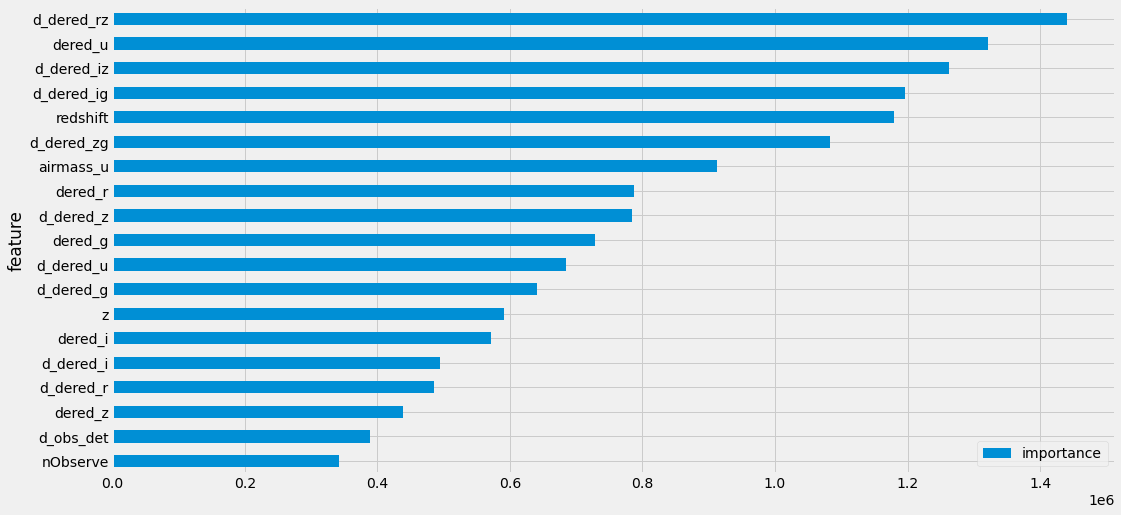

In [40]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [41]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,2.0
320001,0.0
320002,2.0
320003,0.0
320004,2.0


In [42]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [43]:
sub[target_col].value_counts()

2    41026
0    29966
1     9008
Name: class, dtype: int64

In [44]:
sub.to_csv(sub_file)